# PROJECT -  A2Z CUSTOMER SEGMENTATION

## Introduction
Data herein presented pertains to a fictional insurance company in Portugal, A2Z Insurance. The goal is to develop a customer segmentation strategy that will enable the Marketing Department to better understand the different customers' profiles and develop adequate marketing strategies. <br>
This project is done within the cope of the **Data Mining** curricular unit of the Master's Degree in **Data Science and Advanced Analytics**.

#### Group elements:
* Ivan Jure Parać (20210689)
* Nuno de Bourbon e Carvalho Melo (20210681)
* Stuart Gallina Ottersen (20210703)


## Table of Contents
1. [Data exploration](#data-exploration)
2. [Data preprocessing](#data-preprocessing)
    1. [First steps](#preprocessing-first-steps)
    2. [Dealing with outliers](#preprocessing-outliers)
    3. [Handling missing values](#preprocessing-missing-values)
    4. [Feature creation and cross field validation](#preprocessing-transform-validate)
    5. [Feature selection](#preprocessing-feature-selection)
    6. [Feature skewness](#preprocessing-scaling)
3. [Clustering](#data-clustering)
    1. [Sociodemographic clustering](#clustering-sociodemographic)
    2. [Value clustering](#clustering-value)
    3. [Product clustering](#clustering-product)

***

<h2><center>BOILERPLATE</center></h2>

***

In [296]:
# uncomment next line of code to install package required for KPrototypes
# !pip install kmodes

In [297]:
# import major libraries/modules
import pyreadstat
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import statsmodels.api as sm
import sklearn.metrics as metrics
import graphviz
import pydotplus

# others
from math import ceil
from collections import Counter
from regressors import stats
from scipy.cluster import hierarchy
from scipy.stats import chi2_contingency
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation, OPTICS, MeanShift, Birch, SpectralClustering, estimate_bandwidth
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE

# self-organizing maps
# @misc{moosavi2014sompy,
#   title={SOMPY: A Python Library for Self Organizing Map (SOM)},
#   author={Moosavi, V and Packmann, S and Vall{\'e}s, I},
#   note={GitHub.[Online]. Available: https://github. com/sevamoo/SOMPY},
#   year={2014}
# }
import sompy
from sompy.visualization.mapview import View2D, View2DPacked
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

In [298]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

In [299]:
# load SAS file with the insurance company data
df, meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')

# save copy of the original dataframe
original_df = df.copy()

<a class="anchor" id="data-exploration"></a>

***

<h2><center>DATA EXPLORATION</center></h2>

***

In [300]:
# first look at the dataframe
df.head()

CustID  FirstPolYear  BirthYear          EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  2 - High School    2177.0         1.0   
1     2.0        1981.0     1995.0  2 - High School     677.0         4.0   
2     3.0        1991.0     1970.0        1 - Basic    2277.0         3.0   
3     4.0        1990.0     1981.0      3 - BSc/MSc    1099.0         4.0   
4     5.0        1986.0     1973.0      3 - BSc/MSc    1763.0         4.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45

In [301]:
# check number of rows and columns
print("Number of observations:", df.shape[0])
print("Number of features:", df.shape[1])
print("Features:", list(df.columns))

Number of observations: 10296
Number of features: 14
Features: ['CustID', 'FirstPolYear', 'BirthYear', 'EducDeg', 'MonthSal', 'GeoLivArea', 'Children', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']


In [302]:
# describe the data
df.describe(include = "all").T

count unique          top  freq         mean          std  \
CustID         10296.0    NaN          NaN   NaN       5148.5   2972.34352   
FirstPolYear   10266.0    NaN          NaN   NaN  1991.062634   511.267913   
BirthYear      10279.0    NaN          NaN   NaN  1968.007783    19.709476   
EducDeg          10296      5  3 - BSc/MSc  4799          NaN          NaN   
MonthSal       10260.0    NaN          NaN   NaN  2506.667057  1157.449634   
GeoLivArea     10295.0    NaN          NaN   NaN     2.709859     1.266291   
Children       10275.0    NaN          NaN   NaN     0.706764     0.455268   
CustMonVal     10296.0    NaN          NaN   NaN   177.892605  1945.811505   
ClaimsRate     10296.0    NaN          NaN   NaN     0.742772     2.916964   
PremMotor      10262.0    NaN          NaN   NaN   300.470252   211.914997   
PremHousehold  10296.0    NaN          NaN   NaN   210.431192   352.595984   
PremHealth     10253.0    NaN          NaN   NaN   171.580833   296.405976   
PremLife       10192.0    NaN          NaN   NaN    41.855782    47.480632   
PremWork       10210.0    NaN          NaN   NaN    41.277514    51.513572   

                     min      25%     50%       75%       max  
CustID               1.0  2574.75  5148.5   7722.25   10296.0  
FirstPolYear      1974.0   1980.0  1986.0    1992.0   53784.0  
BirthYear         1028.0   1953.0  1968.0    1983.0    2001.0  
EducDeg              NaN      NaN     NaN       NaN       NaN  
MonthSal           333.0   1706.0  2501.5   3290.25   55215.0  
GeoLivArea           1.0      1.0     3.0       4.0       4.0  
Children             0.0      0.0     1.0       1.0       1.0  
CustMonVal    -165680.42    -9.44  186.87  399.7775  11875.89  
ClaimsRate           0.0     0.39    0.72      0.98     256.2  
PremMotor          -4.11   190.59  298.61     408.3  11604.42  
PremHousehold      -75.0    49.45   132.8    290.05   25048.8  
PremHealth         -2.11    111.8  162.81    219.82   28272.0  
PremLife            -7.0     9.89   25.56     57.79     398.3  
PremWork           -12.0    10.67   25.67     56.79    1988.7

In [303]:
# more information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  float64
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10296 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  float64
 6   Children       10275 non-null  float64
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


<a class="anchor" id="data-preprocessing"></a>

***

<h2><center>2. DATA PREPROCESSING</center></h2>

***

In [304]:
def plot_multiple(df, features, plot_type, fig_dimensions = [15, 8], nr_rows = 1):

    '''
    Takes in a dataframe, df, a list of features, features,
    a plot type, plot_type, the dimensions of the figure,
    fig_dimensions, and the number of rows of the figure,
    nr_rows, as argument, and plots the specified plot type
    for the features passed as arguments.

    Arguments:
     df (dataframe): dataframe
     features (list): features from df to plot (min. 2 features)
     plot_type (str): type of plot (box, violin, or histogram)
     fig_dimensions (list, tuple): figure dimensions
     nr_rows (int): number of rows in the figure

    Returns:
     None
    '''

    sns.set(style = "ticks", font_scale = 1.5)

    fig, axes = plt.subplots(nr_rows, ceil(len(features) / nr_rows), figsize = fig_dimensions)
    
    # iterate through axes and associate each plot to one
    for ax, feat in zip(axes.flatten(), features):
        if (plot_type.lower() == "box") or (plot_type.lower() == "boxplot"):
            sns.boxplot(
                data = df,
                x = feat,
                color = "C9",
                ax = ax
            )

        if (plot_type.lower() == "violin" or (plot_type.lower() == "violinplot")):
            sns.violinplot(
                data = df,
                x = feat,
                color = "C9",
                ax = ax
            )

        if (plot_type.lower() == "histogram" or (plot_type.lower() == "histplot")):
            sns.histplot(
                data = df,
                x = feat,
                color = "C9",
                ax = ax
            )

    plt.show()

    return

<a class="anchor" id="preprocessing-first-steps"></a>

<h3><right>2.1. First steps</right></h3>

* Set customer ID as index
* Remove duplicated observations
* Encode EducDeg and change to float
* Swap incoherent birth and first policy years

In [305]:
# set customer ID as index
df.CustID = df.CustID.astype("int")
df.set_index("CustID", inplace = True)

In [306]:
# check for duplicated rows
print("Number of duplicates:", df.duplicated().sum())

# remove duplicate rows
df.drop_duplicates(inplace = True)
print("Removing duplicates...")
print("Number of duplicates:", df.duplicated().sum())

# store initial number of rows (after duplicate removal)
initial_len = len(df)

# check number of rows and columns again
print("\nCurrent number of observations:", df.shape[0])
print("Current number of features:", df.shape[1])

df.head()

Number of duplicates: 3
Removing duplicates...
Number of duplicates: 0

Current number of observations: 10293
Current number of features: 13


FirstPolYear  BirthYear          EducDeg  MonthSal  GeoLivArea  \
CustID                                                                   
1             1985.0     1982.0  2 - High School    2177.0         1.0   
2             1981.0     1995.0  2 - High School     677.0         4.0   
3             1991.0     1970.0        1 - Basic    2277.0         3.0   
4             1990.0     1981.0      3 - BSc/MSc    1099.0         4.0   
5             1986.0     1973.0      3 - BSc/MSc    1763.0         4.0   

        Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
CustID                                                               
1            1.0      380.97        0.39     375.85          79.45   
2            1.0     -131.13        1.12      77.46         416.20   
3            0.0      504.67        0.28     206.15         224.50   
4            1.0      -16.99        0.99     182.48          43.35   
5            1.0       35.23        0.90     338.62          47.80   

        PremHealth  PremLife  PremWork  
CustID                                  
1           146.36     47.01     16.89  
2           116.69    194.48    106.13  
3           124.58     86.35     99.02  
4           311.17     35.34     28.34  
5           182.59     18.78     41.45

In [307]:
# checking data types

# extract number from EducDeg, save as float
df.EducDeg = df.EducDeg.str.extract("(\d+)").astype("float")
# education degree mapper (to replace numbers when needed)
educ_mapper = {1: "Basic", 2: "High School", 3: "BSc/MSc", 4: "PhD"}

# check data types
df.dtypes

FirstPolYear     float64
BirthYear        float64
EducDeg          float64
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

In [308]:
# swaps years if policy seems to be made before birth
nr_incoherences = len(df[df.BirthYear > df.FirstPolYear])
pc_incoherences = round(nr_incoherences/len(df)*100, 1)

print(f"Number of people with a policy before birth: {nr_incoherences} "
    f"({pc_incoherences}% of the dataset)")

# such high number of inconsistencies suggests systematic error
# assumption: in these cases BirthYear and FirstPolYear were introduced in the wrong fields
print("Swapping birth and first policy years...")

# swap FirstPolYear and BirthYear values when birth occurs after first policy creation
row_filter = df.BirthYear > df.FirstPolYear
df.loc[row_filter, ["FirstPolYear", "BirthYear"]] = df.loc[row_filter, ["BirthYear", "FirstPolYear"]].values

# check if the years were correctly swapped
nr_incoherences = len(df[df.BirthYear > df.FirstPolYear])
print(f"Number of people with a policy before birth: {nr_incoherences}")

Number of people with a policy before birth: 1997 (19.4% of the dataset)
Swapping birth and first policy years...
Number of people with a policy before birth: 0


<a class="anchor" id="preprocessing-outliers"></a>

<h3><right>2.2. Dealing with outliers</right></h3>

* Remove outliers and store them in a separate dataframe

In [309]:
def remove_outliers(df, filters):

    # create a separate dataframe for the outliers
    outliers = pd.DataFrame()

    # remove outliers from main dataframe
    # add outliers to a separate dataframe
    for filter_ in filters:
        outliers = outliers.append(df[filter_])
        df = df[~filter_]
        
    # determine number of outliers removed
    n_outliers = len(outliers)
    pc_removed = round(n_outliers/initial_len*100, 2)
    print(f"Number of outliers removed: {n_outliers} ({pc_removed}% of all observations)")

    return (df, outliers)

In [310]:
# define metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "GeoLivArea", "Children"])
non_metric_features = ["EducDeg", "GeoLivArea", "Children"]

# boxplots of metric features
plot_multiple(df, metric_features, "box", [35, 15], nr_rows = 2)

Number of outliers removed: 44 (0.43% of all observations)


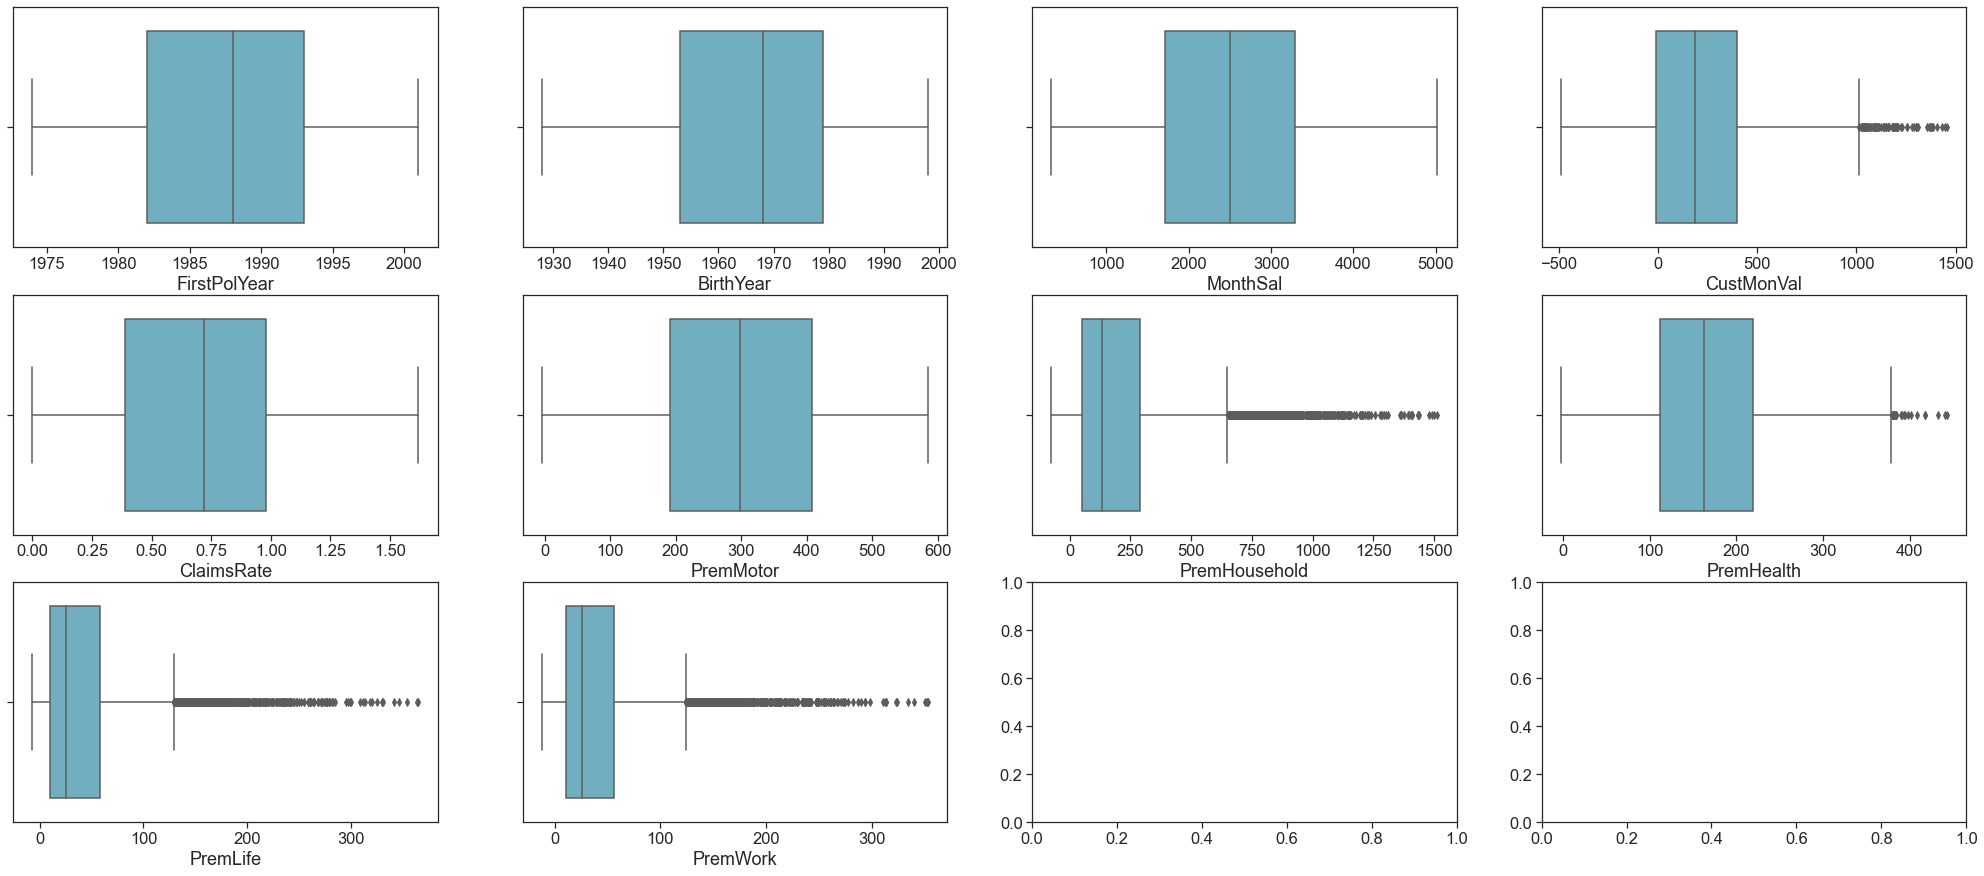

In [311]:
# BirthYear 1028 assumed to be a typo
# 0 and 9 are fairly close in a qwerty keyboard, replaced with 1928
df.loc[df.BirthYear == 1028, "BirthYear"] = 1928

# remove outliers from df, store them in df_outliers1
filters = (
    (df.FirstPolYear.ge(2017)),
    (df.MonthSal.ge(20000)),
    (df.CustMonVal.le(-2000)),
    (df.CustMonVal.ge(1460)),
    (df.ClaimsRate.ge(3)),
    (df.PremMotor.ge(3000)),
    (df.PremHousehold.ge(1700)),
    (df.PremHealth.ge(8000)),
    (df.PremLife.ge(385)),
    (df.PremWork.ge(400)),
)

df, df_outliers1 = remove_outliers(df, filters)

# boxplots of metric features after removing outliers
plot_multiple(df, metric_features, "box", [35, 15], nr_rows = 3)

<a class="anchor" id="preprocessing-missing-values"></a>

<h3><right>2.3. Handling missing values</right></h3>

* Check feature and row completeness (in df and df_outliers)
* Remove customers with no information about Premiums
* Remove customers with missing FirstPolYear or BirthYear
* Remove customers with missing EducDeg
* Fill Premium missing values with zero
* Create Linear Regression model to impute MonthSal
* Create Logistic Regression model to impute Children

In [312]:
def check_completeness(df):

    '''
    Takes in a dataframe, df, as argument and
    computes the number/percentage of missing
    values per feature, and the number of rows
    with the maximum number of missing values.

    Arguments:
     df (dataframe): dataframe

    Returns:
     None
    '''

    # number and percentage of NaN values per feature
    nr_nans = df.isna().sum()
    pc_nans = df.isna().mean()*100
    feature_nans = pd.concat([nr_nans, pc_nans], axis = 1)
    feature_nans.rename(columns = {0: "nr", 1: "%"}, inplace = True)

    # show number of missing values per feature
    print("Missing values per feature:\n", feature_nans)

    # check row completeness
    # max number of NaN values in a row and number of rows with that many NaN
    max_row_nan = df.isnull().sum(axis = 1).max()
    
    print(f"\nMaximum number of NaN values per row: {max_row_nan} "
        f"({len(df[df.isnull().sum(axis = 1) == max_row_nan])} rows)")

    return

In [313]:
def remove_missing_values(df, cols, max_nan_per_row):

    '''
    Takes in a dataframe, df, a list of columns, cols,
    and the maximum number of nan per row, max_nan_per_row,
    and removes rows that have missing values in the columns
    passed on as arguments as well as rows that exceed the
    maximum number of missing values allowed.

    Arguments:
     df (dataframe): dataframe
     cols (list): column(s) in df to remove NaN
     max_nan_per_row (int): max number of NaN allowed per row

    Returns:
     df (dataframe): dataframe after removing NaN
     df_nan (dataframe): dataframe with the NaN rows removed from df
    '''

    # create dataframe to store rows discarded due to missing values
    df_nan = pd.DataFrame()

    # removing rows above the threshold of maximum missing values allowed
    max_nan_rows = df[df.isnull().sum(axis = 1) >= max_nan_per_row]
    df_nan = df_nan.append(max_nan_rows)
    df.drop(max_nan_rows.index, inplace = True)

    print(
        f"Removed {len(max_nan_rows)} row(s) "
        f"(missing {round(max_nan_per_row/len(df.columns)*100, 1)}% of their data)"
    )

    # remove rows with missing values from features passed as arguments
    # add these rows to df_nan
    for col in cols:
        nan_ = df[col].isna()
        nr_removed = sum(nan_)

        df_nan = df_nan.append(df[nan_])
        df = df[~nan_]

        print(f"Removed {nr_removed} row(s) (NaN in {col})")

    # show total number of missing values removed
    nr_rows_removed = len(df_nan)
    total_removed = initial_len - len(df)

    print(
        f"Total number of rows removed: {nr_rows_removed}\n"
        f"Total number of rows removed so far: {total_removed} "
        f"({round(total_removed/initial_len*100, 2)}%)"
    )

    return (df, df_nan)

In [314]:
def zero_imputer(df, cols):

    '''
    Takes in a dataframe, df, and a list of columns,
    cols, and replaces existing missing values in
    those columns with zero.

    Arguments:
     df (dataframe): dataframe
     cols (list): column(s) in df to impute NaN with 0
    
    Returns:
     df (dataframe): dataframe after value imputation
    '''

    # save the total number of imputed values
    total_imputations = 0

    # impute each NaN value in cols with zero
    for col in cols:
        col_nan = sum(df[col].isna())
        df[col].fillna(0, inplace = True)

        # print number of imputed values per column
        print(f"Imputed {col_nan} out of {col_nan} missing value(s) in {col}")
        
        total_imputations += col_nan

    print(f"Total number of imputations: {total_imputations}")

    return df

In [315]:
def linreg_imputer(df, regressors, regressand):

    '''
    Takes in a dataframe, df, a list of regressor names,
    regressors, and the name of the regressand, regressand,
    and uses a linear regression model to predict missing
    values in the regressand based on the regressors.

    Arguments:
     df (dataframe): dataframe
     regressors (str, list): list of columns in df to be used
    in linear regression to predict the regressand
     regressand (str): name of column in df whose missing values
    will be imputed with values predicted by linear regression

    Returns:
     df (dataframe): dataframe after value imputation
    '''

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split train and validation data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 15)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if (type(regressors) is not list) and (type(regressors) is str):
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler() with parameters from X_train
    scaler = StandardScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # create and fit model
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scaled, y_train)

    # predict salary of the validation set
    y_pred = lin_reg.predict(X_val_scaled)

    # compute metrics for the predictions made
    mse = metrics.mean_squared_error(y_val, y_pred)
    rmse = metrics.mean_squared_error(y_val, y_pred, squared = False)
    mae = metrics.mean_absolute_error(y_val, y_pred)

    print("")
    print("======================================================")
    print("                Linear regression model               ")
    print("======================================================")
    print("Mean square error:", round(mse, 2))
    print("Root mean square error:", round(rmse, 2))
    print("Mean absolute error:", round(mae, 2))
    stats.summary(clf = lin_reg, X = X_train_scaled, y = y_train)
    print("======================================================")

    # predict missing values in the regressand column
    X_test = df.loc[df[regressand].isna(), regressors]

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_test = np.array(X_test).reshape(-1, 1)

    X_test_scaled = scaler.transform(X_test)
    y_pred = lin_reg.predict(X_test_scaled)

    # impute missing values in the regressand column
    df.loc[df[regressand].isna(), regressand] = y_pred
    
    print(f"\nImputed {len(y_pred)} values in {regressand}")

    return df

In [316]:
def knreg_choose_k(df, regressors, regressand, max_n_neighbors):

    neighborhood_sizes = np.arange(1, max_n_neighbors+1)

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split train and validation data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 15)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if (type(regressors) is not list) and (type(regressors) is str):
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler() with parameters from X_train
    scaler = StandardScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # set up lists for the metrics
    rmse_values = list()
    mae_values = list()
    adj_r2_values = list()

    for n in neighborhood_sizes:
        # create and fit model for each number of neighbors
        kn_reg = KNeighborsRegressor(n_neighbors = n, weights = "distance")
        kn_reg.fit(X_train_scaled, y_train)
        # predict salary of the validation set
        y_pred = kn_reg.predict(X_val_scaled)

        # compute metrics
        rmse = metrics.mean_squared_error(y_val, y_pred, squared = False)
        mae = metrics.mean_absolute_error(y_val, y_pred)
        r2 = metrics.r2_score(y_val, y_pred)
        adj_r2 = 1 - (1 - r2)*((X_val.shape[0] - 1)/(X_val.shape[0] - X_val.shape[1] - 1))

        # append values to corresponding list
        rmse_values.append(rmse)
        mae_values.append(mae)
        adj_r2_values.append(adj_r2)

    # get number of neighbors that provide the 'best' the metrics evaluated
    n_min_rmse = rmse_values.index(np.min(rmse_values)) + 1
    n_min_mae = mae_values.index(np.min(mae_values)) + 1
    n_max_adj_r2 = adj_r2_values.index(np.max(adj_r2_values)) + 1

    print(
        f"k = {n_min_rmse} minimises RMSE ({round(np.min(rmse_values), 2)})\n"
        f"k = {n_min_mae} minimises MAE ({round(np.min(mae_values), 2)})\n"
        f"k = {n_max_adj_r2} maximises adjusted R-squared ({round(np.max(adj_r2_values), 2)})"
    )

    # list of computed metrics
    metrics_ = [rmse_values, mae_values, adj_r2_values]
    y_labels = ["RMSE", "MAE", "R2 (adjusted)"]

    # plot the error and adjusted R2 values
    sns.set(style = "ticks")

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for ax, metric, y_label in zip(axes.flatten(), metrics_, y_labels):
        sns.lineplot(x = neighborhood_sizes,
            y = metric,
            marker = "o",
            mew = 0,
            ax = ax,
            color = "C9",
            linewidth = 4    
        )
        ax.set_xlabel("Number of neighbors, k")
        ax.set_ylabel(y_label)
    
    return

In [317]:
def logreg_feat_selection(df, regressand):

    # independent, X, and dependent, y, variables
    X = df.dropna().drop(columns = regressand)
    y = df.dropna()[regressand]

    # split data into train (70%) and validation (30%) datasets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5, stratify = y)

    # scale features using MinMaxScaler with parameters from X_train
    scaler = StandardScaler().fit(X_train)
    # scale the training set
    X_train_scaled = scaler.transform(X_train)
    # scale the test set
    X_val_scaled = scaler.transform(X_val)

    # recursive feature elimination
    numfeats_list = np.arange(1, len(df.columns))
    scores = {}

    for n in range(len(numfeats_list)):
        log_reg = LogisticRegression()
        rfe = RFE(estimator=log_reg, n_features_to_select=numfeats_list[n])
        
        X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
        X_val_rfe = rfe.transform(X_val_scaled)
        log_reg.fit(X_train_rfe, y_train)
        
        score = log_reg.score(X_val_rfe, y_val)
        scores[n+1] = score

    # RFE selected 1 single feature
    best_num_feats = max(scores, key = scores.get)
    rfe = RFE(estimator = log_reg, n_features_to_select = best_num_feats)
    rfe.fit(X = X_train_scaled, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns, name = "RFE")

    # compute correlation between Children and other features
    correlations = pd.Series(df.corr()[regressand], name = "Correlation")

    # compute Lasso coefficients
    reg = LassoCV()
    reg.fit(X_train_scaled, y_train)
    lasso_coef = pd.Series(reg.coef_, index = X_train.columns, name = "Lasso")

    # concatenate features selected by rfe, correlations, and lasso coefficients
    selection_df = pd.concat([selected_features, correlations, lasso_coef], axis = 1).drop(regressand)

    # plot correlation and lasso coefficients
    coef_names = ["Correlation", "Lasso"]

    sns.set()
    sns.set_style("white")
    fig, axes = plt.subplots(1, ceil(len(coef_names)), figsize = (24, 10))

    for ax, coef in zip(axes.flatten(), coef_names):
        sns.barplot(data = selection_df,
                    x = coef,
                    y = selection_df.index,
                    hue = "RFE",
                    palette = ["darkgray", "C9"],
                    order = selection_df.sort_values(coef).index,
                    ax = ax)
        ax.axvline(x = 0, linestyle = "--", color = "darkgray", label = "_nolegend_")
        ax.set_xlabel(coef + " coefficient", fontsize = 16)
        ax.legend(title = "RFE", loc = "upper right", fontsize = 14)

    plt.show()

    return

In [318]:
def logreg_imputer(df, regressors, regressand):
            
    # imputing missing Children values
    # conclusion based on previous feature selection: use only BirthYear

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split data into train (70%) and validation (30%) datasets
    # 70% have children, 30% dont, decided to stratify
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5, stratify = y)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler with parameters from X_train
    scaler = StandardScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # create a logistic regression model
    log_reg = LogisticRegression()
    log_reg.fit(X_train_scaled, y_train)

    # predict y
    y_pred = log_reg.predict(X_val_scaled)

    # evaluate the predictions of the logistic reg model
    conf_matrix = metrics.confusion_matrix(y_val, y_pred)
    conf_matrix = pd.DataFrame(conf_matrix)
    accuracy = round(metrics.accuracy_score(y_val, y_pred)*100, 2)
    precision = round(metrics.precision_score(y_val, y_pred)*100, 2)
    recall = round(metrics.recall_score(y_val, y_pred)*100, 2)
    f1 = round(metrics.f1_score(y_val, y_pred)*100, 2)

    print("==============================================")
    print("           Logistic regression model          ")
    print("==============================================")
    print("Accuracy:", accuracy, "%")
    print("Precision:", precision, "%")
    print("Recall:", recall, "%")
    print("F1 score:", f1, "%")
    print("Confusion matrix:\n", conf_matrix)
    print("==============================================")

    # predict missing values in the regressand column
    X_test = df.loc[df[regressand].isna(), regressors]

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_test = np.array(X_test).reshape(-1, 1)
    
    X_test_scaled = scaler.transform(X_test)
    y_pred = log_reg.predict(X_test_scaled)

    # impute missing values in the regressand column
    df.loc[df[regressand].isna(), regressand] = y_pred

    print(f"\nImputed {len(y_pred)} values in {regressand}") 

    return df

In [319]:
def knclassif_choose_k(df, regressors, regressand, max_n_neighbors):

    neighborhood_sizes = np.arange(1, max_n_neighbors+1)

    # independent, X, and dependent, y, variables
    X = df.dropna()[regressors]
    y = df.dropna()[regressand]

    # split data into train (70%) and validation (30%) datasets
    # 70% have children, 30% dont, decided to stratify
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 5, stratify = y)

    # reshaping needed if a string and not a list is passed as argument for regressors
    if type(regressors) is not list:
        X_train = np.array(X_train).reshape(-1, 1)
        X_val = np.array(X_val).reshape(-1, 1)

    # scale features using MinMaxScaler with parameters from X_train
    scaler = StandardScaler().fit(X_train)
    # scale the training and test sets
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # set up lists for metrics
    accuracy_values = list()
    precision_values = list()
    recall_values = list()
    f1_values = list()

    for n in neighborhood_sizes:
        # create a logistic regression model
        log_reg = KNeighborsClassifier(n_neighbors = n, weights = "distance").fit(X_train_scaled, y_train)
        # predict y
        y_pred = log_reg.predict(X_val_scaled)

        # compute metrics
        accuracy = round(metrics.accuracy_score(y_val, y_pred)*100, 2)
        precision = round(metrics.precision_score(y_val, y_pred)*100, 2)
        recall = round(metrics.recall_score(y_val, y_pred)*100, 2)
        f1 = round(metrics.f1_score(y_val, y_pred)*100, 2)

        # append values to corresponding list
        accuracy_values.append(accuracy)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

    # get number of neighbors that provide the 'best' metrics
    n_max_accuracy = accuracy_values.index(np.max(accuracy_values)) + 1
    n_max_precision = precision_values.index(np.max(precision_values)) + 1
    n_max_recall = recall_values.index(np.max(recall_values)) + 1
    n_max_f1 = f1_values.index(np.max(f1_values)) + 1

    print(
        f"k = {n_max_accuracy} maximises accuracy ({round(np.max(accuracy_values), 2)})\n"
        f"k = {n_max_precision} maximises precision ({round(np.max(precision_values), 2)})\n"
        f"k = {n_max_recall} maximises recall ({round(np.max(recall_values), 2)})\n"
        f"k = {n_max_f1} maximises F1 score ({round(np.max(f1_values), 2)})\n"
    )

    # list of computed metrics
    metrics_ = [accuracy_values, precision_values, recall_values, f1_values]
    y_labels = ["Accuracy, %", "Precision, %", "Recall, %", "F1 score"]

    # plot the error and adjusted R2 values
    sns.set(style = "ticks")

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    for ax, metric, y_label in zip(axes.flatten(), metrics_, y_labels):
        sns.lineplot(x = neighborhood_sizes,
            y = metric,
            marker = "o",
            mew = 0,
            ax = ax,
            color = "C9",
            linewidth = 4    
        )
        ax.set_xlabel("Number of neighbors, k")
        ax.set_ylabel(y_label)  

    return

In [320]:
# check missing values in the dataframe
check_completeness(df)

Missing values per feature:
                 nr         %
FirstPolYear    30  0.292711
BirthYear       17  0.165870
EducDeg         17  0.165870
MonthSal        36  0.351254
GeoLivArea       1  0.009757
Children        21  0.204898
CustMonVal       0  0.000000
ClaimsRate       0  0.000000
PremMotor       33  0.321983
PremHousehold    0  0.000000
PremHealth      42  0.409796
PremLife       104  1.014733
PremWork        86  0.839106

Maximum number of NaN values per row: 4 (12 rows)


In [321]:
# drops rows with missing values in FirstPolYear, BirthYear, EducDeg
# drop highly incomplete rows (no information about Premiums)
max_nan_per_row = df.isnull().sum(axis = 1).max()
cols = ["FirstPolYear", "BirthYear", "EducDeg"]
df, df_nan = remove_missing_values(df, cols, max_nan_per_row)

Removed 12 row(s) (missing 30.8% of their data)
Removed 30 row(s) (NaN in FirstPolYear)
Removed 14 row(s) (NaN in BirthYear)
Removed 2 row(s) (NaN in EducDeg)
Total number of rows removed: 58
Total number of rows removed so far: 102 (0.99%)


In [322]:
# impute missing values in the Premium features
cols = [col for col in df if col.startswith("Prem")]
df = zero_imputer(df, cols)

Imputed 21 out of 21 missing value(s) in PremMotor
Imputed 0 out of 0 missing value(s) in PremHousehold
Imputed 29 out of 29 missing value(s) in PremHealth
Imputed 92 out of 92 missing value(s) in PremLife
Imputed 73 out of 73 missing value(s) in PremWork
Total number of imputations: 215


In [323]:
# choose feature(s) to use for linear regression of MonthSal
corr_salary = pd.Series(df.corr().MonthSal, name = "Correlation").sort_values()
print("Correlation between salary and other features:")
print(round(corr_salary, 3))

Correlation between salary and other features:
BirthYear       -0.904
Children        -0.461
FirstPolYear    -0.300
PremLife        -0.242
PremWork        -0.241
PremHousehold   -0.233
CustMonVal      -0.059
ClaimsRate       0.002
GeoLivArea       0.010
PremHealth       0.028
EducDeg          0.180
PremMotor        0.225
MonthSal         1.000
Name: Correlation, dtype: float64


In [324]:
# MonthSal imputation

# Option 1: KNReg
# sal_regressors = df.columns.drop("MonthSal")
# regressand = "MonthSal"
# knreg_choose_k(df, sal_regressors, regressand, max_n_neighbors = 20)


# Option 2: LinReg
# using all features (MSE 171009, RMSE 414, MAE 331, Adj R2 0.817)
# sal_regressors = df.columns.drop("MonthSal")
# regressand = "MonthSal"
# df = linreg_imputer(df, sal_regressors, regressand)

# using BirthYear and Children (MSE 177996, RMSE 422, MAE 334, Adj R2 0.818)
# sal_regressors = ["BirthYear", "Children"]
# regressand = "MonthSal"
# df = linreg_imputer(df, sal_regressors, regressand)

# using BirthYear only (very high correlation of -0.9)
sal_regressors = ["BirthYear"]
regressand = "MonthSal"
df = linreg_imputer(df, sal_regressors, regressand)

# better predictions with linear regression than KNRegressor
# similar results using a simple linear regression with BirthYear and using a multiple regression with all features


                Linear regression model               
Mean square error: 182626.75
Root mean square error: 427.35
Mean absolute error: 336.08
Residuals:
       Min        1Q   Median       3Q       Max
-1509.3943 -288.0634 -14.6173 267.0031 1736.1596


Coefficients:
               Estimate  Std. Error   t value  p value
_intercept  2502.327841    4.952412  505.2745      0.0
x1          -883.400421    4.952412 -178.3778      0.0
---
R-squared:  0.81755,    Adjusted R-squared:  0.81752
F-statistic: 31809.68 on 1 features

Imputed 33 values in MonthSal


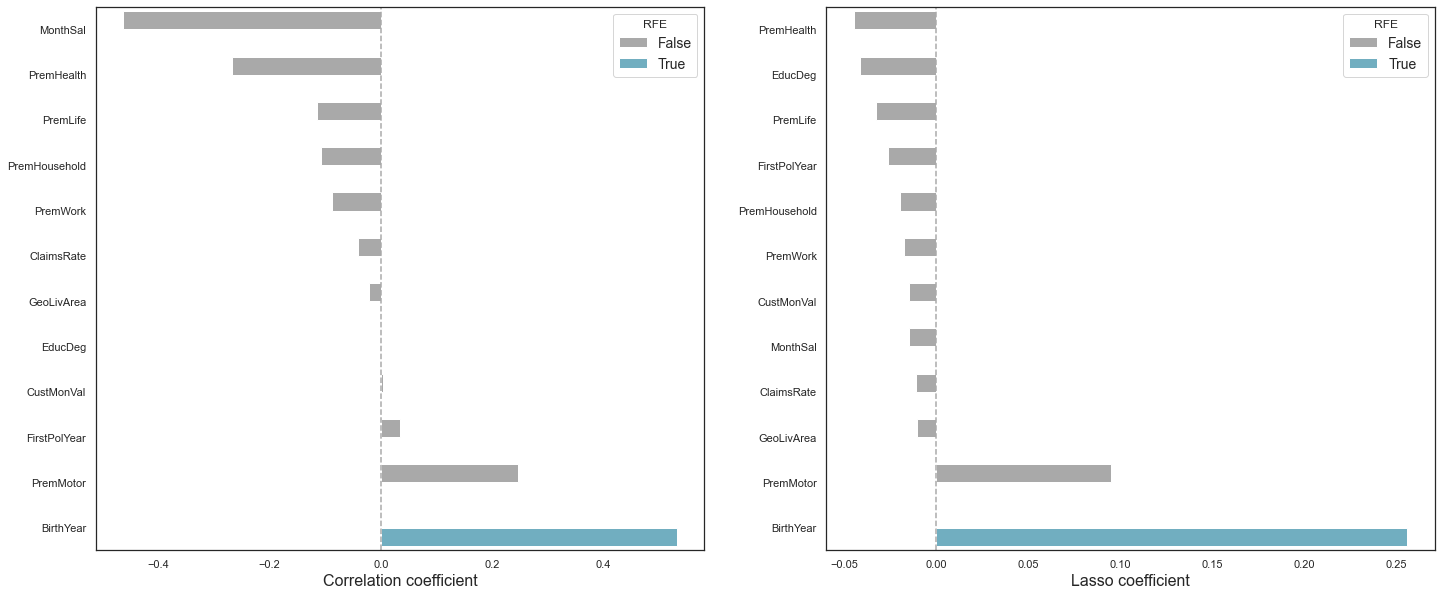

           Logistic regression model          
Accuracy: 84.87 %
Precision: 87.47 %
Recall: 91.76 %
F1 score: 89.56 %
Confusion matrix:
      0     1
0  610   284
1  178  1982

Imputed 13 values in Children


In [325]:
# Children imputation

# Option 1: KNClassifier
# child_regressors = list(df.columns.drop("Children"))
# regressand = "Children"
# knclassif_choose_k(df, child_regressors, regressand, max_n_neighbors = 25)


# Option 2: LogReg
# choose features (RFE, correlations, Lasso)
logreg_feat_selection(df, "Children")

# KNClassifier (all features, k = 23, weights = distance) and logistic regression with BirthYear provide similar predictions
# impute children missing values with Logistic Regression
children_regressors = ["BirthYear"]
df = logreg_imputer(df, children_regressors, "Children")

In [326]:
# check if all NaN values were dealt with
check_completeness(df)

Missing values per feature:
                nr    %
FirstPolYear    0  0.0
BirthYear       0  0.0
EducDeg         0  0.0
MonthSal        0  0.0
GeoLivArea      0  0.0
Children        0  0.0
CustMonVal      0  0.0
ClaimsRate      0  0.0
PremMotor       0  0.0
PremHousehold   0  0.0
PremHealth      0  0.0
PremLife        0  0.0
PremWork        0  0.0

Maximum number of NaN values per row: 0 (10191 rows)


In [327]:
# check missing values in df_outliers1
check_completeness(df_outliers1)

# deal with Premium missing values in df_outliers1
cols = ["PremMotor", "PremHealth", "PremLife", "PremWork"]
df_outliers1 = zero_imputer(df_outliers1, cols)

Missing values per feature:
                nr         %
FirstPolYear    0  0.000000
BirthYear       0  0.000000
EducDeg         0  0.000000
MonthSal        0  0.000000
GeoLivArea      0  0.000000
Children        0  0.000000
CustMonVal      0  0.000000
ClaimsRate      0  0.000000
PremMotor       1  2.272727
PremHousehold   0  0.000000
PremHealth      1  2.272727
PremLife        0  0.000000
PremWork        0  0.000000

Maximum number of NaN values per row: 2 (1 rows)
Imputed 1 out of 1 missing value(s) in PremMotor
Imputed 1 out of 1 missing value(s) in PremHealth
Imputed 0 out of 0 missing value(s) in PremLife
Imputed 0 out of 0 missing value(s) in PremWork
Total number of imputations: 2


<a class="anchor" id="preprocessing-transform-validate"></a>

<h3><right>2.4. Feature creation</right></h3>

* Add columns: Age, FirstPolAge, CustYears, Generation, PremTotal, Premium ratios
* Check if EducDeg makes sense given the customer's age
* Convert MonthSal to YearSal
* Remove outliers from newly created features
* Transform skewed metric features

In [328]:
def feature_creator(df):
    
    # save columns originally present in the dataframe
    initial_cols = df.columns

    # create Age column
    # (customers age as of 2016)
    curr_year = 2016
    cust_ages = curr_year - df.BirthYear
    df["Age"] = cust_ages
    
    # create FirstPolAge column
    # (customers age at the time of the first policy creation)
    firstpol_ages = df.FirstPolYear - df.BirthYear
    df["FirstPolAge"] = firstpol_ages
    
    # create CustYears column
    # (number of years as a customer to the company)
    df["CustYears"] = curr_year - df.FirstPolYear
    
    # create Generation column
    # (generation customers belongs to)
    df.loc[(df.BirthYear >= 1928) & (df.BirthYear <= 1945), "Generation"] = 1 # Silent Gen
    df.loc[(df.BirthYear >= 1946) & (df.BirthYear <= 1964), "Generation"] = 2 # Baby Boomer
    df.loc[(df.BirthYear >= 1965) & (df.BirthYear <= 1980), "Generation"] = 3 # Gen X
    df.loc[(df.BirthYear >= 1981) & (df.BirthYear <= 1996), "Generation"] = 4 # Millennial
    df.loc[(df.BirthYear >= 1997) & (df.BirthYear <= 2012), "Generation"] = 5 # Gen Z
    df.Generation = df.Generation.astype("float")
    
    # create YearSal column
    # (customers yearly income)
    year_sals = df.MonthSal * 12
    df["YearSal"] = year_sals
    
    # create a PremTotal column
    # (customers total money spent on premiums)
    premium_cols = ["PremMotor", "PremHousehold", "PremHealth", "PremLife", "PremWork"]
    df["PremTotal"] = df[premium_cols].sum(axis = 1)

    # create Effort column
    # (proportion of the yearly salary each customer spends on the company)
    efforts = df.PremTotal / df.YearSal
    df["EffortRatio"] = efforts
    
    # create PremiumRatio columns
    # (proportion of the total premium spent on each type of policy)
    for col in premium_cols:
        newcol_vals = df[col]/df["PremTotal"]
        newcol_name = col + "Ratio"
        df[newcol_name] = newcol_vals

    # verbose: list of newly created columns
    new_cols = df.columns.drop(initial_cols)
    print(f"Created {len(new_cols)} new features:\n{list(new_cols)}")
        
    return df

In [329]:
# update dataframe with new features
df = feature_creator(df)

# also add the new features to df_outliers1
# needed so that they can be assigned to clusters later on
df_outliers1 = feature_creator(df_outliers1)

# update metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "GeoLivArea", "Children", "Generation"])
non_metric_features = ["EducDeg", "GeoLivArea", "Children", "Generation"]

Created 12 new features:
['Age', 'FirstPolAge', 'CustYears', 'Generation', 'YearSal', 'PremTotal', 'EffortRatio', 'PremMotorRatio', 'PremHouseholdRatio', 'PremHealthRatio', 'PremLifeRatio', 'PremWorkRatio']
Created 12 new features:
['Age', 'FirstPolAge', 'CustYears', 'Generation', 'YearSal', 'PremTotal', 'EffortRatio', 'PremMotorRatio', 'PremHouseholdRatio', 'PremHealthRatio', 'PremLifeRatio', 'PremWorkRatio']


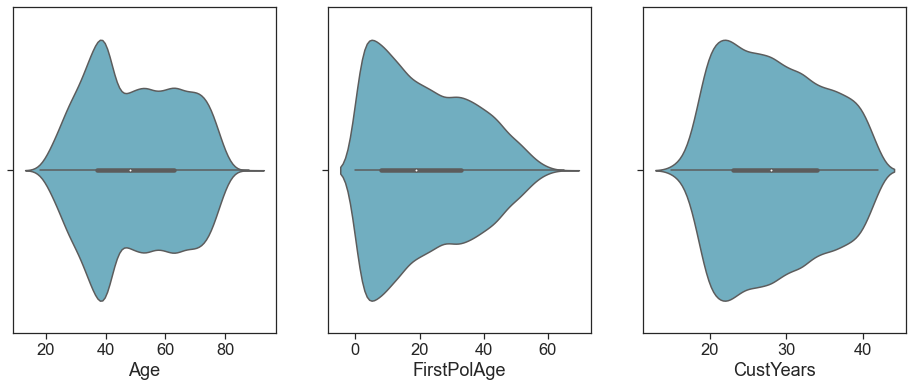

In [330]:
# violinplots of the newly created year-related features
features = ["Age", "FirstPolAge", "CustYears"]
plot_multiple(df, features, "violin", fig_dimensions = [16, 6])

Text(0, 0.5, 'Count')

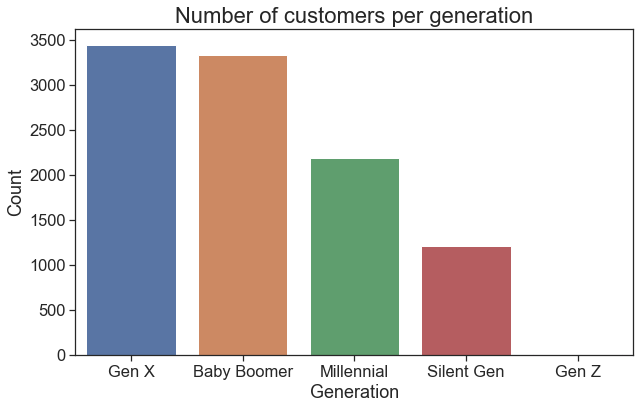

In [331]:
# visualize Generation feature
# generation mapper
gen_mapper = {
    1: "Silent Gen",
    2: "Baby Boomer",
    3: "Gen X",
    4: "Millennial",
    5: "Gen Z"
}

# count number of customers per generation
gen_count = df.groupby("Generation").size().sort_values(ascending = False)
gen_count.rename(index = gen_mapper, inplace = True)

# visualize number of customers per generation
fig, ax = plt.subplots(figsize = (10, 6))
sns.barplot(x = gen_count.index, y = gen_count.values, order = gen_count.index)
plt.title("Number of customers per generation", fontsize = 22)
plt.xlabel("Generation", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

# plt.show()

# almost no customers from the younger generation, Gen Z

In [332]:
# cross-validate EducDeg and Age
# minimum age is 18 - meaning everyone can have an education up to High School
# minimum age of 20 for a BSc
# minimum age of 23 for a PhD (skipping MSc and finishing in 3 years, UK or outside of the EU)
educdeg_min_age = df.groupby("EducDeg").Age.min().rename(index = educ_mapper)
print("======================================")
print("   Cross-validating EducDeg and Age   ")
print("======================================")
print("Minimum age associated to each EducDeg")
print(educdeg_min_age)

# no incoherences found

   Cross-validating EducDeg and Age   
Minimum age associated to each EducDeg
EducDeg
Basic          18.0
High School    19.0
BSc/MSc        20.0
PhD            23.0
Name: Age, dtype: float64


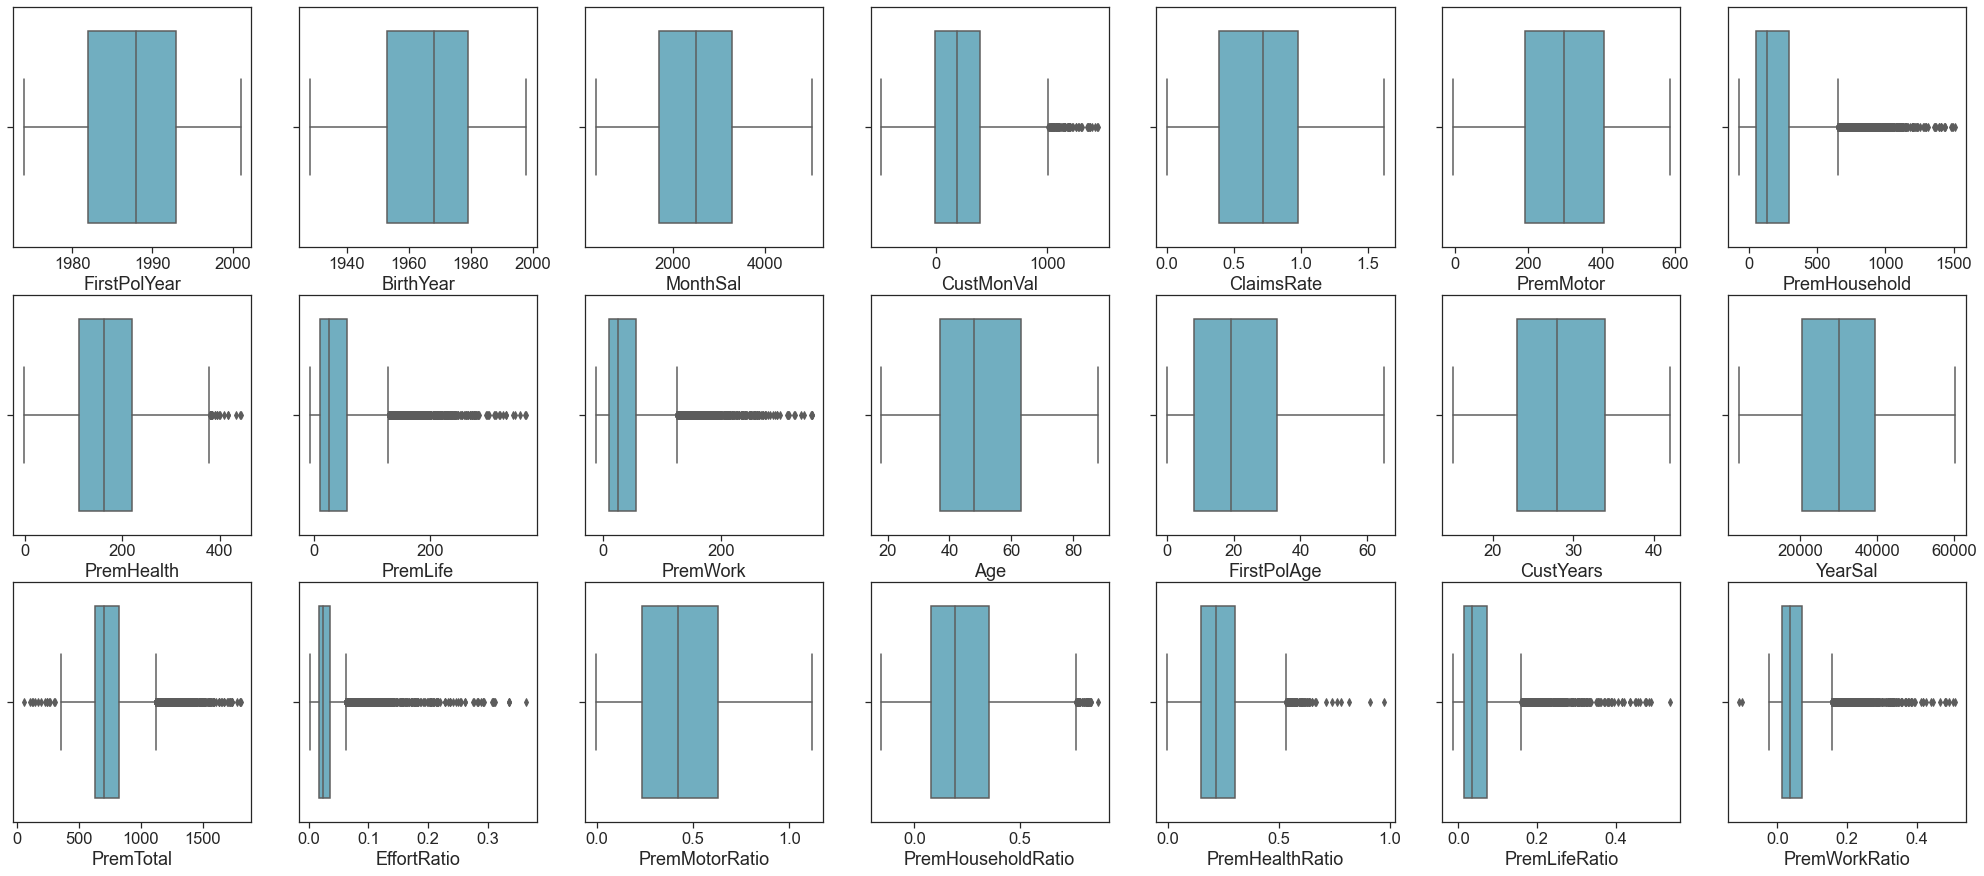

In [333]:
# plot metric features
plot_multiple(df, metric_features, "box", fig_dimensions = [35, 15], nr_rows = 3)

Number of outliers removed: 27 (0.26% of all observations)


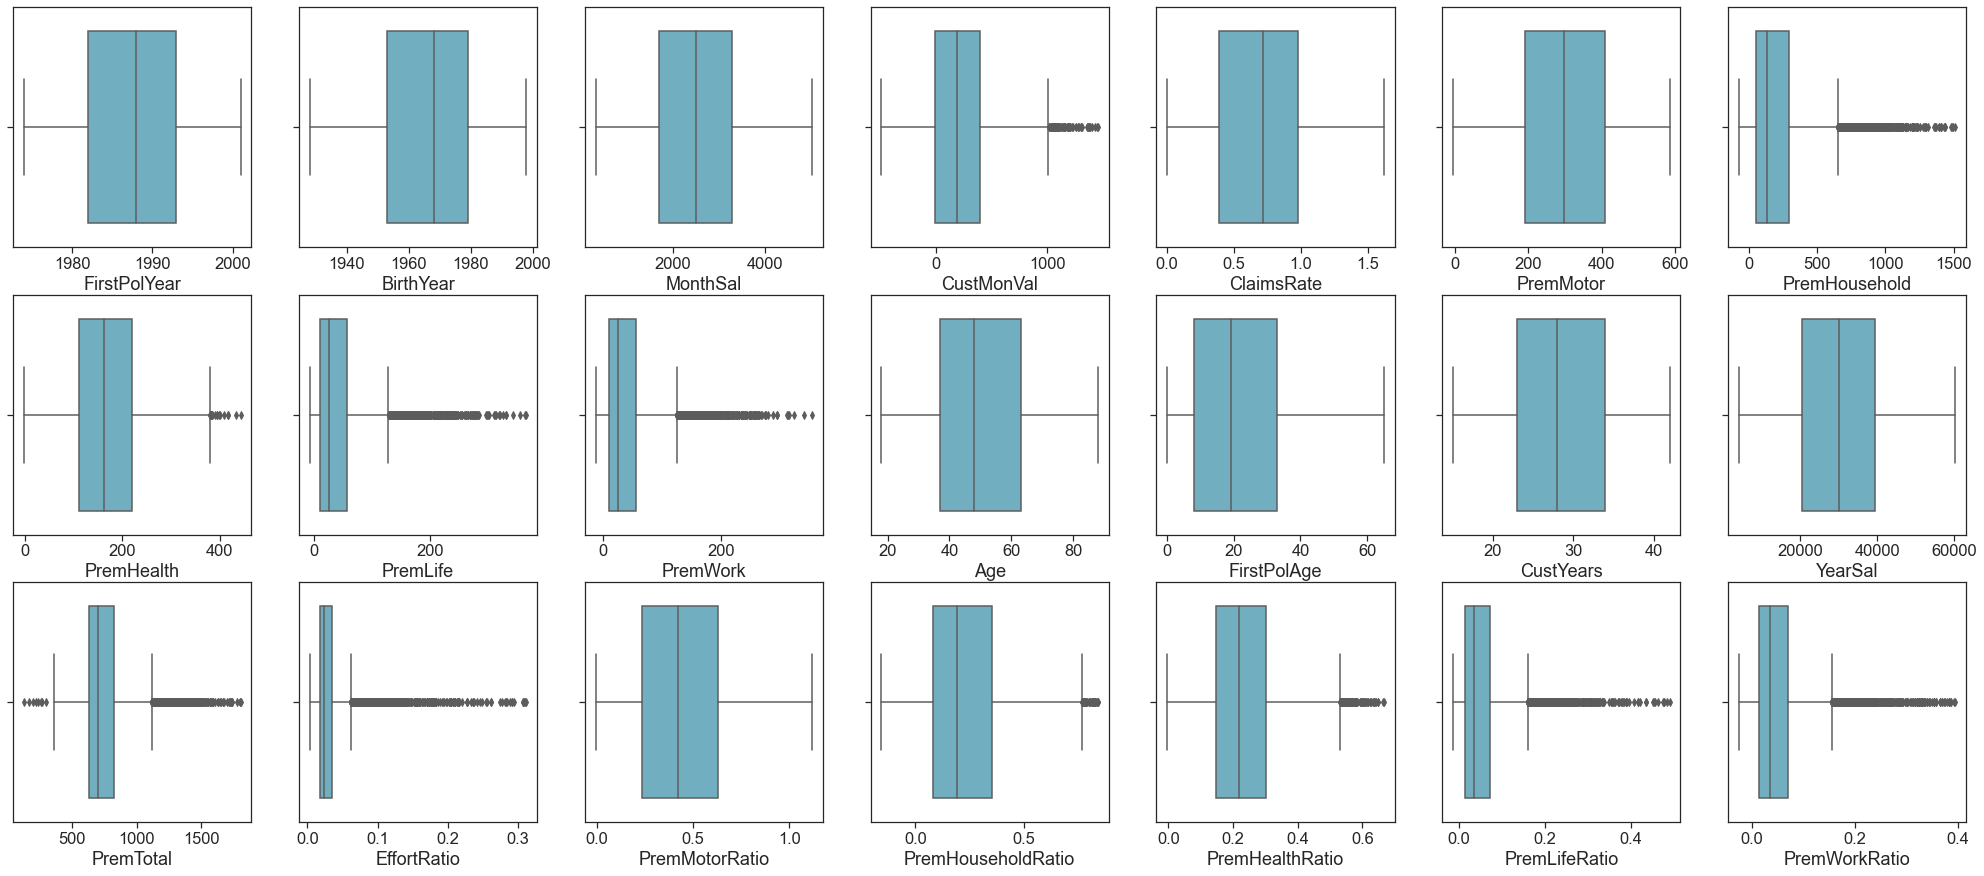

In [334]:
# conditions to remove outliers
filters = (
    (df.PremHouseholdRatio.ge(0.85)),
    (df.PremHealthRatio.ge(0.70)),
    (df.PremLifeRatio.ge(0.50)),
    (df.PremWorkRatio.ge(0.40)),
    (df.PremWorkRatio.le(-0.05)),
    # (df.PremTotal.le(2000)),
    (df.PremTotal.ge(1900)),
    (df.EffortRatio.ge(0.32))
)

# remove outliers from newly created features, store them in outliers2
df, df_outliers2 = remove_outliers(df, filters)

# merge the two outliers dataframes
df_outliers = pd.concat([df_outliers1, df_outliers2])

# boxplot of metric features after removing outliers
plot_multiple(df, metric_features, "box", [35, 15], 3)

<a class="anchor" id="preprocessing-feature-selection"></a>

<h3><right>2.5. Feature selection</right></h3>

* Remove redundant features
* Remove irrelevant features
* Prepare dataframe for cluster analysis

In [335]:
def corr_heatmap(df, corrlimit, method = "pearson"):

    '''
    Takes in a dataframe, df, and a coefficient, method,
    as arguments and creates a correlation heatmap showing
    the correlations between all pairs of features in the
    dataframe.
    '''

    sns.set(style = "ticks")
    plt.subplots(figsize = (20, 15))

    mask = np.triu(np.ones_like(df.corr(method = method), dtype = bool))
    correlationmatrix=df.corr(method = method)
    annot_labels = correlationmatrix
    annot_mask = abs(correlationmatrix) <corrlimit
    annot_labels=round(annot_labels,2).astype(str)
    annot_labels[annot_mask] ='' 
    corr_heatmap = sns.heatmap(correlationmatrix, mask = mask, vmin = -1, vmax = 1, annot = annot_labels, cmap = 'BrBG',fmt='')
    corr_heatmap.set_title('Triangle Correlation Heatmap', fontdict = {'fontsize': 14}, pad = 8)

    return

In [336]:
def restructure_df(df):
    
    # reorganise column order
    df = df.loc[:, [
        "Generation",
        "Age",
        "YearSal",
        "EducDeg",
        "Children",
        "FirstPolAge",
        "CustYears",
        "CustMonVal",
        "ClaimsRate",
        "PremMotor",
        "PremMotorRatio",
        "PremHousehold",
        "PremHouseholdRatio",
        "PremHealth",
        "PremHealthRatio",
        "PremLife",
        "PremLifeRatio",
        "PremWork",
        "PremWorkRatio",
        "PremTotal",
        "EffortRatio"
        ]
    ]
    
    # rename a few columns
    df = df.rename(columns = {
        "CustMonVal": "CMV",
        "PremMotor": "Motor",
        "PremMotorRatio": "MotorRatio",
        "PremHousehold": "House",
        "PremHouseholdRatio": "HouseRatio",
        "PremHealth": "Health",
        "PremHealthRatio": "HealthRatio",
        "PremLife": "Life",
        "PremLifeRatio": "LifeRatio",
        "PremWork": "Work",
        "PremWorkRatio": "WorkRatio"
        }
    )
    
    return df

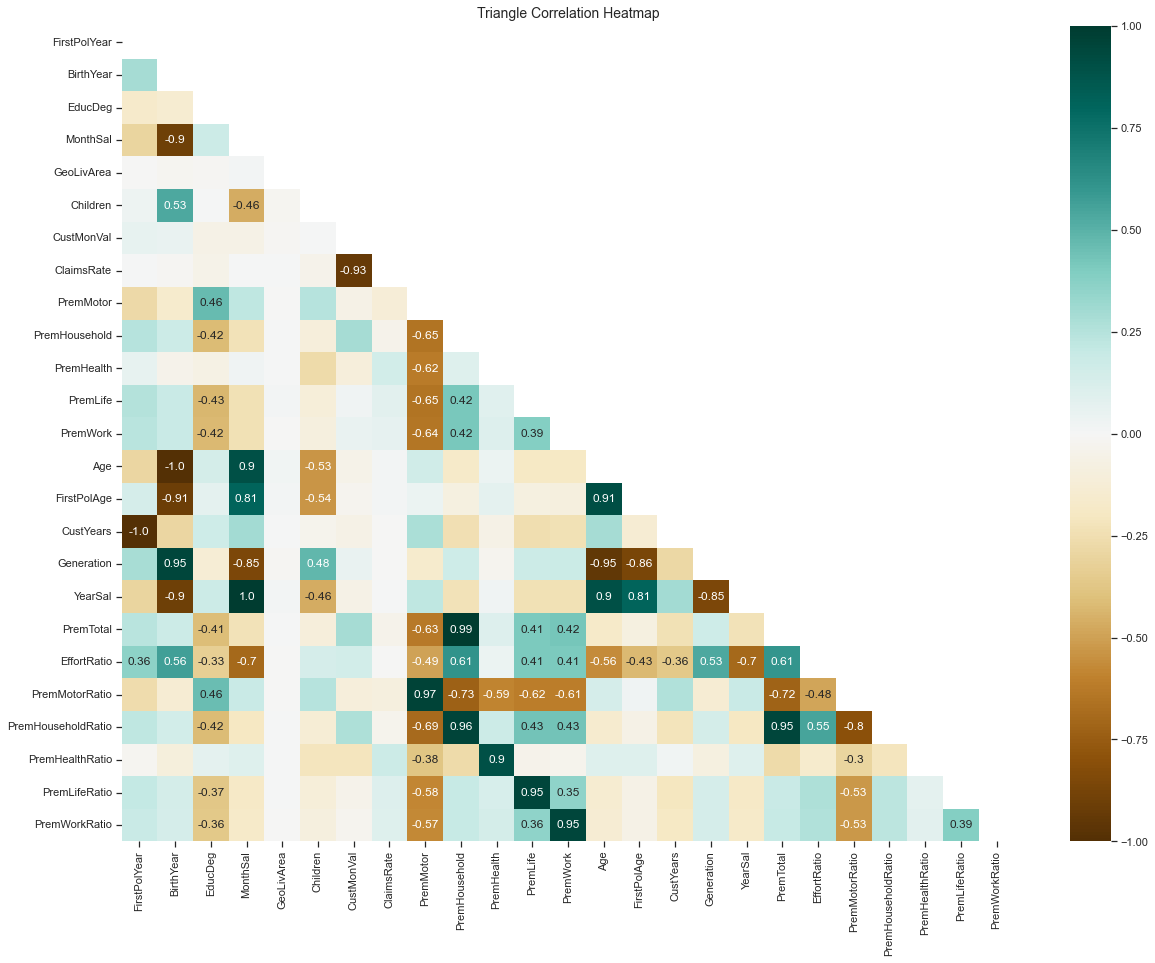

In [337]:
# correlation heatmap of features in the dataframe
# show value only for correlations higher than 0.4 or lower than -0.4
corr_heatmap(df, 0.3)

In [338]:
# remove perfetly redundant features from main dataframe
df.drop(columns = ["FirstPolYear", "BirthYear", "MonthSal"], inplace = True)

# TO BE DECIDED (based on future clustering) !!!!!!!!!!!!!!
# Age vs FirstPolAge vs Generation vs YearSal
# ClaimsRate vs CustMonVal
# PremTotal vs PremHousehold
# PremTotal vs PremHousehold_ratio
# Prem ratios vs Prem values

Metric features: ['CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork', 'Age', 'FirstPolAge', 'CustYears', 'YearSal', 'PremTotal', 'EffortRatio', 'PremMotorRatio', 'PremHouseholdRatio', 'PremHealthRatio', 'PremLifeRatio', 'PremWorkRatio']
Non-metric features: ['EducDeg', 'GeoLivArea', 'Children', 'Generation']


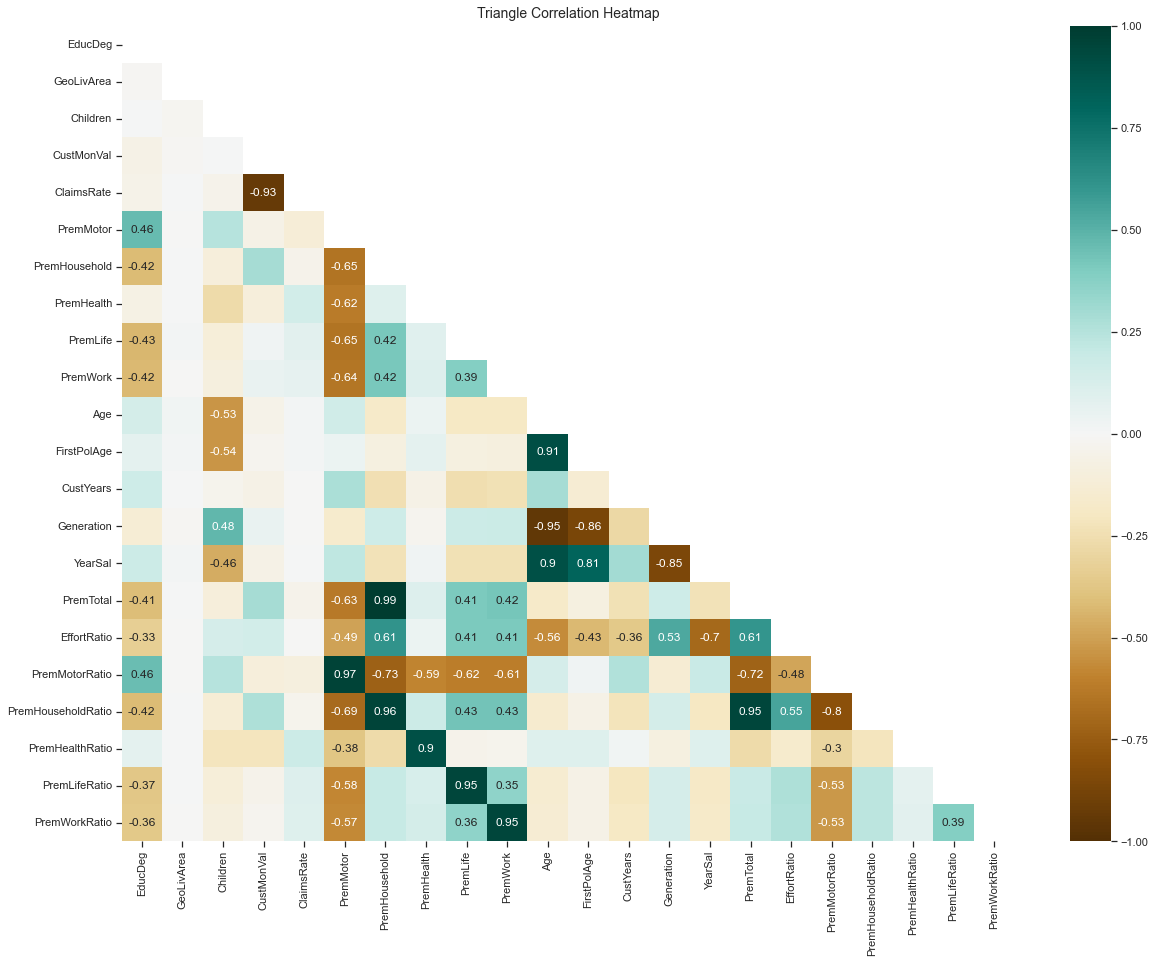

In [339]:
# correlation heatmap after updating features
corr_heatmap(df, 0.3)

# update metric and non-metric features
metric_features = list(df.columns.drop(["EducDeg", "GeoLivArea", "Children", "Generation"]))
non_metric_features = ["EducDeg", "GeoLivArea", "Children", "Generation"]

print("Metric features:", metric_features)
print("Non-metric features:", non_metric_features)

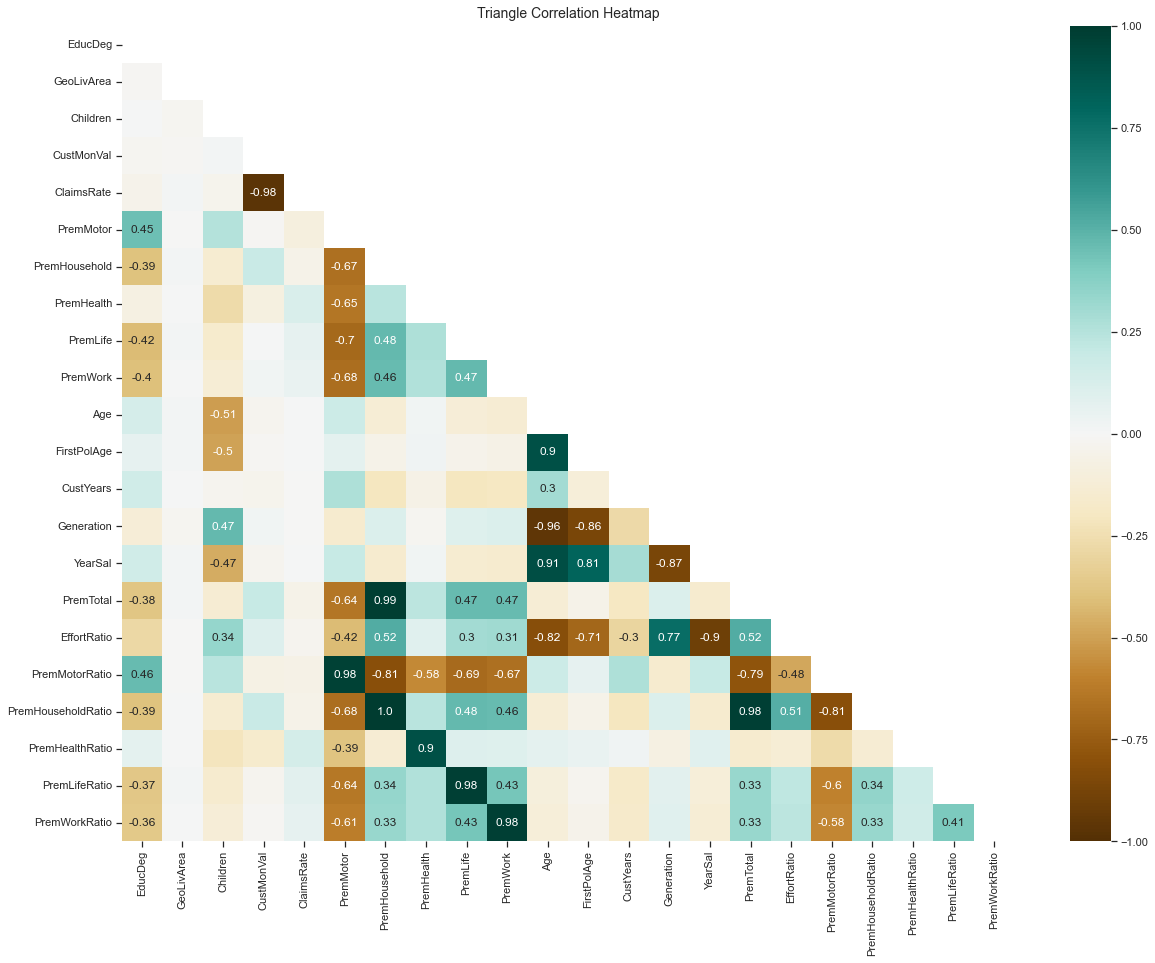

In [340]:
# correlation heatmap after updating features (spearman)
corr_heatmap(df, 0.3, "spearman")

In [341]:
# pairplot of current (metric) features
sns.pairplot(df[metric_features])

Error in callback <function flush_figures at 0x000001F14C3B3AF0> (for post_execute):


KeyboardInterrupt: 

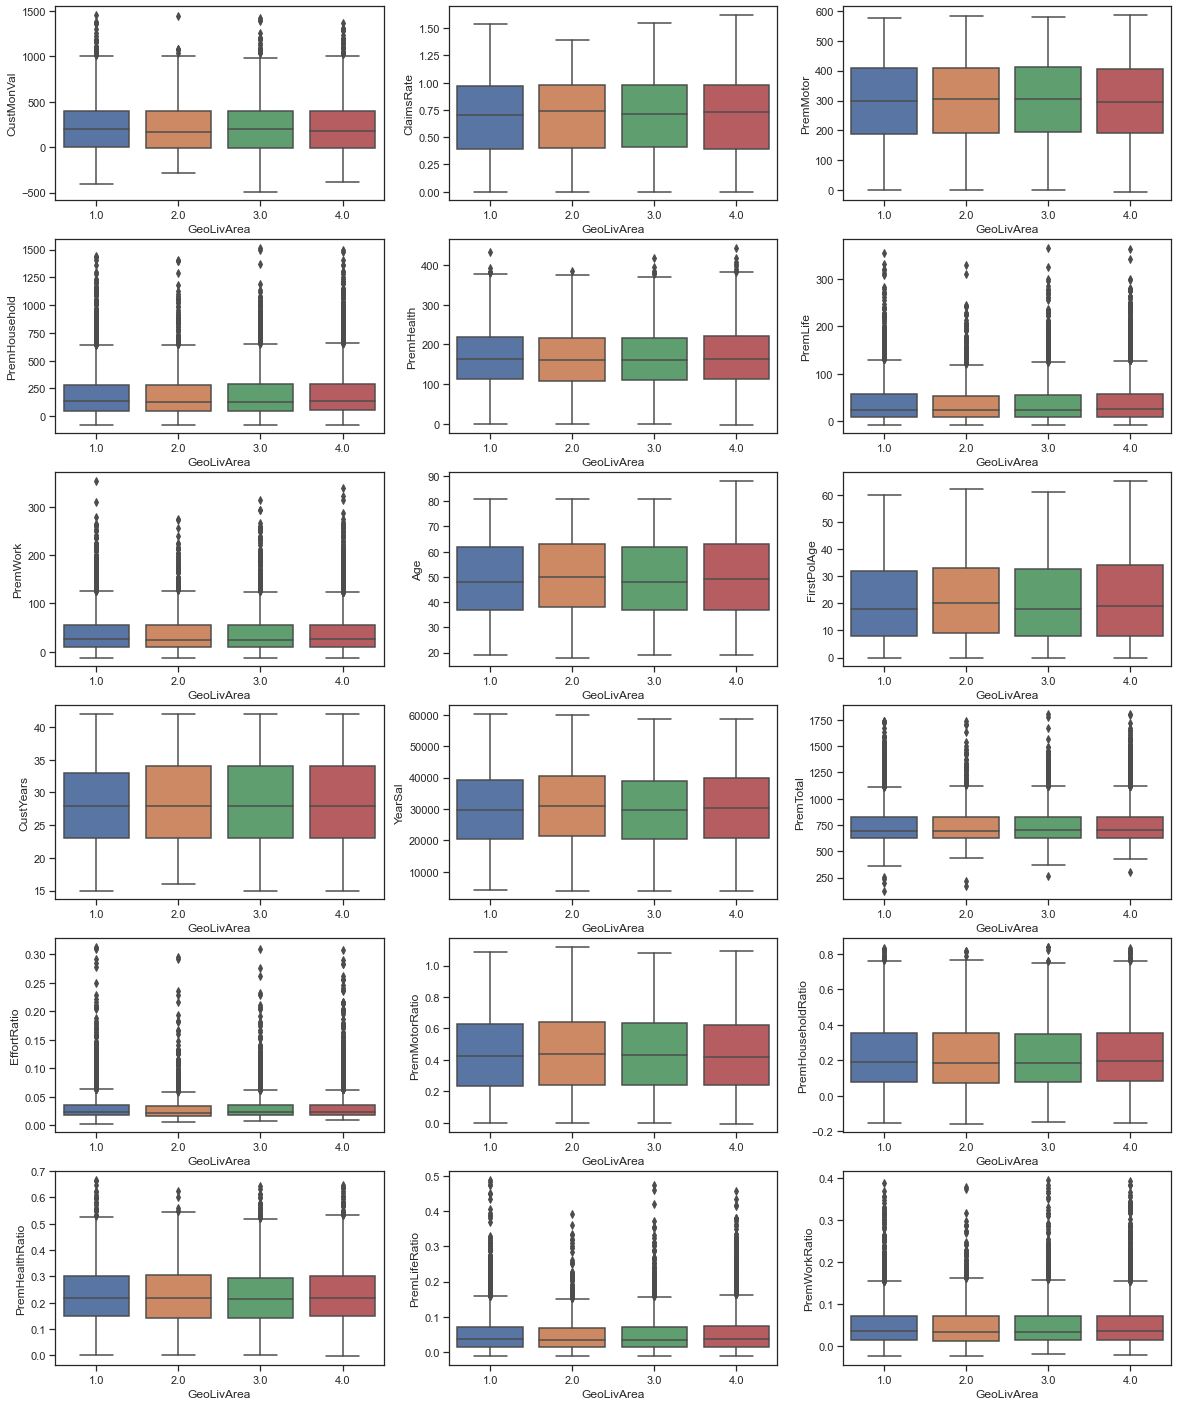

In [342]:
# Correlation heatmap hinted at GeoLivArea having no meaningful correlation with any of the features
# visual representation of GeoLivArea and its relation with other features
sns.set(style = "ticks")

fig, axes = plt.subplots(6, 3, figsize=(20, 25))

for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x = df["GeoLivArea"], y = df[feat], ax = ax)
    
plt.show()

# confirms that GeoLivArea appears to have no discriminative power

In [343]:
# remove GeoLivArea from the main dataframe
df.drop(columns = "GeoLivArea", inplace = True)

# remove GeoLivArea from df_outliers
df_outliers.drop(columns = "GeoLivArea", inplace = True)

In [344]:
# restructure and visualize the main dataframe before cluster analysis
df = restructure_df(df)
df.head()

Generation   Age  YearSal  EducDeg  Children  FirstPolAge  CustYears  \
CustID                                                                         
1              4.0  34.0  26124.0      2.0       1.0          3.0       31.0   
2              4.0  35.0   8124.0      2.0       1.0         14.0       21.0   
3              3.0  46.0  27324.0      1.0       0.0         21.0       25.0   
4              4.0  35.0  13188.0      3.0       1.0          9.0       26.0   
5              3.0  43.0  21156.0      3.0       1.0         13.0       30.0   

           CMV  ClaimsRate   Motor  ...   House  HouseRatio  Health  \
CustID                              ...                               
1       380.97        0.39  375.85  ...   79.45    0.119373  146.36   
2      -131.13        1.12   77.46  ...  416.20    0.456881  116.69   
3       504.67        0.28  206.15  ...  224.50    0.303133  124.58   
4       -16.99        0.99  182.48  ...   43.35    0.072168  311.17   
5        35.23        0.90  338.62  ...   47.80    0.075965  182.59   

        HealthRatio    Life  LifeRatio    Work  WorkRatio  PremTotal  \
CustID                                                                 
1          0.219905   47.01   0.070632   16.89   0.025377     665.56   
2          0.128096  194.48   0.213489  106.13   0.116503     910.96   
3          0.168215   86.35   0.116595   99.02   0.133702     740.60   
4          0.518030   35.34   0.058833   28.34   0.047180     600.68   
5          0.290175   18.78   0.029846   41.45   0.065873     629.24   

        EffortRatio  
CustID               
1          0.025477  
2          0.112132  
3          0.027104  
4          0.045547  
5          0.029743  

[5 rows x 21 columns]

In [345]:
# restructure and visualize the outliers dataframe before cluster analysis
df_outliers = restructure_df(df_outliers)
df_outliers.head()

Generation   Age   YearSal  EducDeg  Children  FirstPolAge  CustYears  \
CustID                                                                          
9295           2.0  68.0   39216.0      3.0       0.0      51836.0   -51768.0   
5883           2.0  60.0  662580.0      2.0       1.0         39.0       21.0   
8262           4.0  35.0  413880.0      2.0       0.0         10.0       25.0   
52             3.0  50.0   38808.0      3.0       1.0         16.0       34.0   
113            3.0  37.0   28248.0      4.0       1.0         18.0       19.0   

             CMV  ClaimsRate   Motor  ...   House  HouseRatio  Health  \
CustID                                ...                               
9295      348.85        0.37  351.40  ...   15.00    0.025253  187.37   
5883      122.25        0.79  281.83  ...  147.25    0.207161  130.58   
8262      608.89        0.28   57.01  ...  358.95    0.405062  195.26   
52     -14714.08       25.36  557.44  ...   20.00    0.033167   29.56   
113     -8719.04       15.65  518.32  ...    4.45    0.007499   55.90   

        HealthRatio    Life  LifeRatio    Work  WorkRatio  PremTotal  \
CustID                                                                 
9295       0.315438   22.45   0.037795   17.78   0.029933     594.00   
5883       0.183708   84.46   0.118824   66.68   0.093810     710.80   
8262       0.220344  113.80   0.128419  161.14   0.181841     886.16   
52         0.049022    5.00   0.008292   -9.00  -0.014925     603.00   
113        0.094195    3.89   0.006555   10.89   0.018350     593.45   

        EffortRatio  
CustID               
9295       0.015147  
5883       0.001073  
8262       0.002141  
52         0.015538  
113        0.021009  

[5 rows x 21 columns]

<a class="anchor" id="preprocessing-scaling"></a>

<h3><right>2.6. Feature skewness</right></h3>

In [346]:
def transform_skewed_features(df, features, transformation):

    # create dataframe with the transformed features
    df_transformed = df.copy()

    for feat in features:
        # ensure all values are non-negative and apply square root transformation
        if transformation.lower() == "sqrt":
            df_transformed[feat] = np.sqrt(df_transformed[feat] + abs(df_transformed[feat].min()))

        # ensure all values are positive and apply log10 transformation
        if transformation.lower() == "log10":
            df_transformed[feat] = np.log10(df_transformed[feat] + abs(df_transformed[feat].min()) + 1)

    return df_transformed

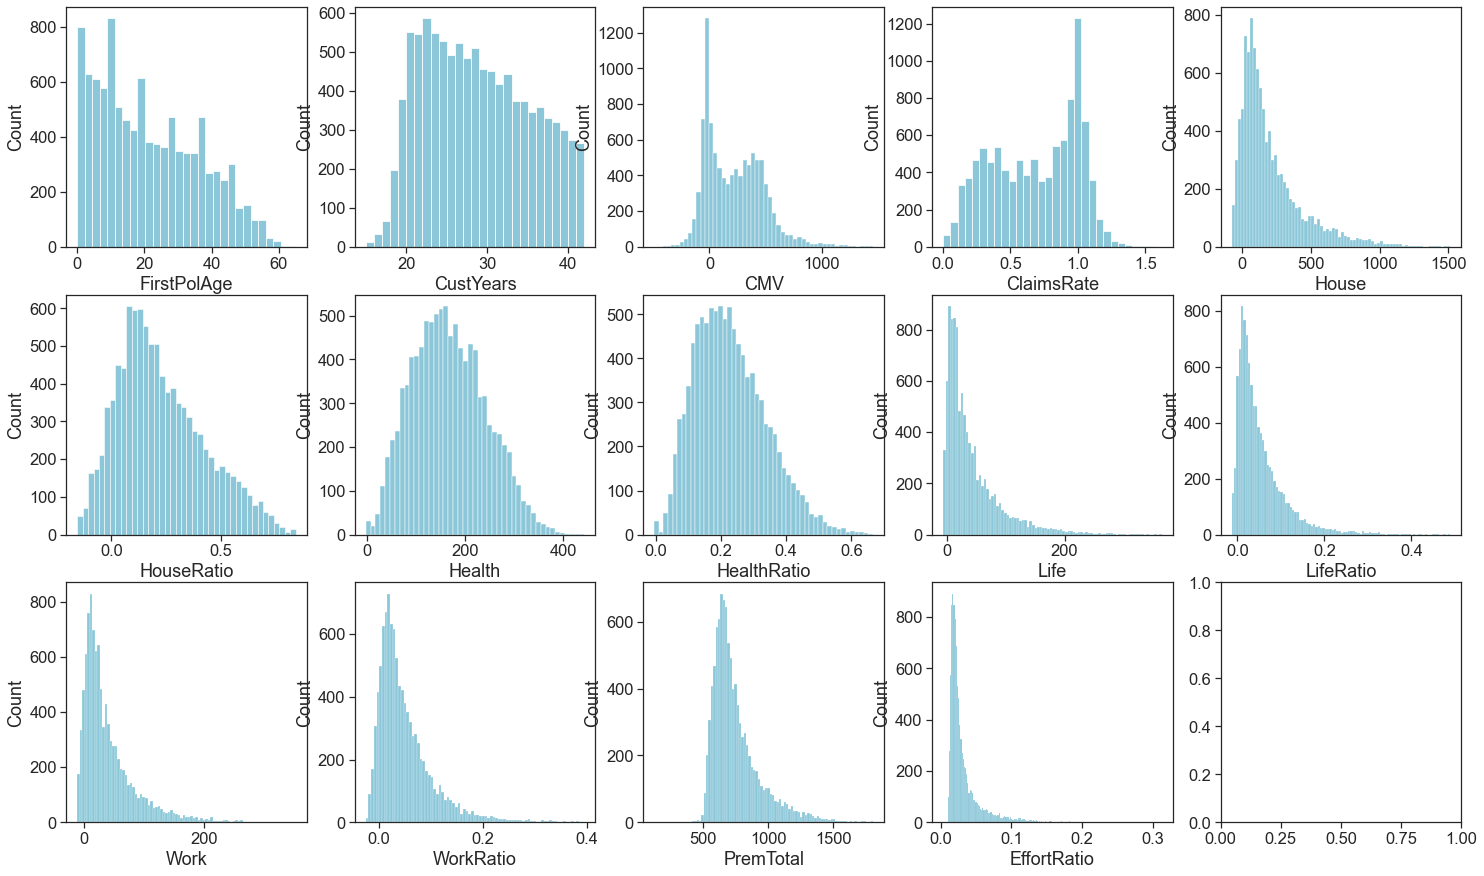

In [347]:
features = [
    "FirstPolAge",
    "CustYears",
    "CMV",
    "ClaimsRate",
    "House",
    "HouseRatio",
    "Health",
    "HealthRatio",
    "Life",
    "LifeRatio",
    "Work",
    "WorkRatio",
    "PremTotal",
    "EffortRatio"
]

# plot histogram of the potentially skewed metric features
plot_multiple(df, features, "histogram", [25, 15], nr_rows = 3)

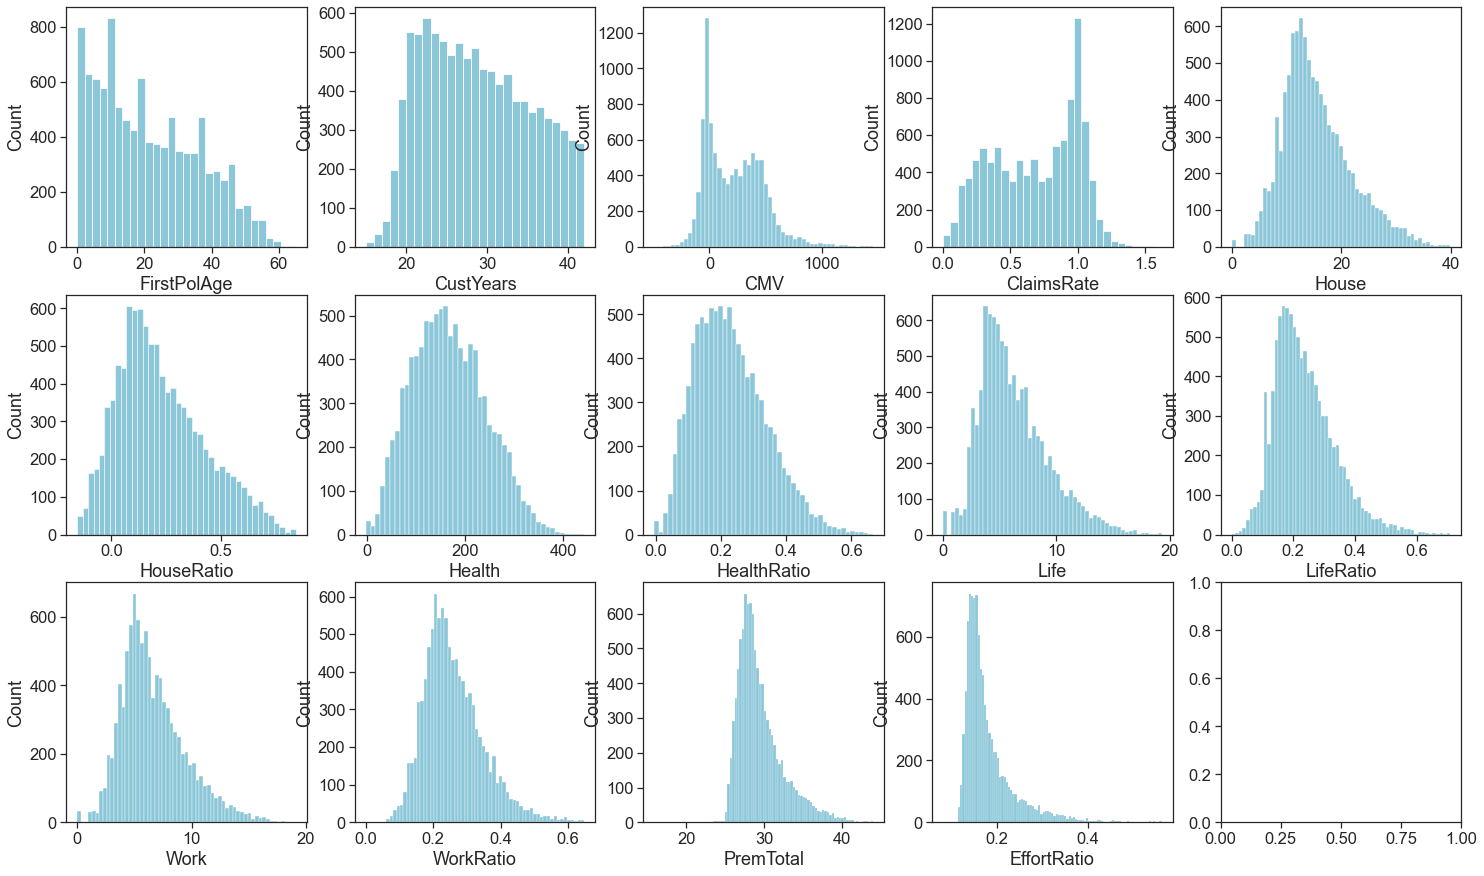

In [348]:
# list of skewed metric features
skewed_features = [
    "House",
    "Life",
    "LifeRatio",
    "Work",
    "WorkRatio",
    "PremTotal",
    "EffortRatio"
]

# apply transformation to the skewed features  (could maybe apply log10 to PremTotal alone???????????????????????)
# save transformed features (and the others) in a copy of the original dataframe to preserve original values
df_transformed = transform_skewed_features(df, skewed_features, transformation = "sqrt")

# plot histogram of transformed features
plot_multiple(df_transformed, features, "histogram", [25, 15], nr_rows = 3)

In [349]:
# seeing PremTotal and EffortRatio still had big right tails, decided to clip
df_transformed.EffortRatio = df_transformed.EffortRatio.clip(upper = 0.4)
df_transformed.PremTotal = df_transformed.PremTotal.clip(upper = 40)

In [350]:
# At this point there are 3 important dataframes
#  df             - original, not transformed values (no square root transformation of skewed features)
#  df_transformed - identical to df except that square root transformation was applied to skewed metric features
#  df_outliers    - all of the outliers removed from df

<a class="anchor" id="data-clustering"></a>

***

<h2><center>3. CLUSTERING</center></h2>

***

In [351]:
def data_scaler(df, scaler_name):

    '''
    Takes in a dataframe, df, and the name of the scaler,
    scaler_name, as arguments and applies the corresponding
    scaling method to the dataframe.

    Arguments:
     df (dataframe): dataframe without the target, y
     scaler_name (str): name of the scaler (minmax,
    standard, robust)

    Returns:
     df_scaled (dataframe): scaled version of the original df
    '''

    df_scaled = df.copy()
    features = list(df.columns)

    if scaler_name.lower() == "minmax":
        scaler = MinMaxScaler().fit(df)
        df_scaled[features] = scaler.transform(df)

    if scaler_name.lower() == "standard":
        scaler = StandardScaler().fit(df)
        df_scaled[features] = scaler.transform(df)

    if scaler_name.lower() == "robust":
        scaler = RobustScaler().fit(df)
        df_scaled[features] = scaler.transform(df)
    
    return (scaler, df_scaled)

In [352]:
def kmeans_clustering(df, k):

    '''
    Takes in a dataframe, df, and a number of clusters, k,
    and assigns rows of the dataframe to clusters based on
    the KMeans algorithm.

    Arguments:
     df (dataframe): dataframe
     k (int): number of clusters

    Returns:
     centroids (ndarray): center of each cluster
     labels (ndarray): label of each row indicating the
    cluster it was assigned to
    '''
    
    clusters = KMeans(
        n_clusters = k,
        init = "k-means++",
        random_state = 15
    ).fit(df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_

    return (centroids, labels)

In [353]:
def kprototypes_clustering(df, k, cat_index, init = "Huang"):

    clusters = KPrototypes(
        n_clusters = k,
        init = init,
        random_state = 15
    ).fit(df, categorical = cat_index)
    labels = clusters.labels_
    centroids = clusters.cluster_centroids_

    return (centroids, labels)

In [354]:
def hierarchical_clustering(df, n_clusters = None, threshold = 10000, affinity = "euclidean", linkage = "ward"):
    
    # determine clusters
    clusters = AgglomerativeClustering(
        n_clusters = n_clusters,
        affinity = affinity,
        linkage = linkage,
        distance_threshold = threshold
    ).fit(df)
    
    # retrieve cluster labels and distances
    labels = clusters.labels_
    distances = clusters.distances_
    
    counts = np.zeros(clusters.children_.shape[0])
    n_samples = len(labels)
    
    for i, merge in enumerate(clusters.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([clusters.children_, distances, counts]).astype(float)
    
    return (distances, labels, linkage_matrix)

In [355]:
def db_scan(df, k):
    for eps in range(1,8):
        for min_samples in range(1,10):
            clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
            print(set(clustering.labels_))
            if len(set(clustering.labels_))==k+1:
                return (None, clustering.labels_)
            if len(set(clustering.labels_))==2 or len(set(clustering.labels_))==1:
                return None
    return (None)


In [356]:
def plot_elbow(df, nmax_clusters, algorithm, cat_index = None, init = "Huang"):
    
    # store inertia values in a list
    y_vals = []
    
    # determine inertia for each number of clusters
    for n in np.arange(2, nmax_clusters + 1):
        if algorithm.lower() == "kmeans":
            km_clusters = KMeans(n_clusters = n, random_state = 15).fit(df)
            inertia = km_clusters.inertia_
            y_vals.append(inertia)

        if algorithm.lower() == "kprototypes":
            if type(cat_index) is int:
                cat_index = [cat_index]
            kp_clusters = KPrototypes(
                n_clusters = n,
                init = init,
                random_state = 15
            ).fit(df, categorical = cat_index)
            cost = kp_clusters.cost_
            y_vals.append(cost)
    
    # plot elbow graph
    sns.set_style("ticks")
    plt.subplots(figsize = (8, 6))
    sns.lineplot(x = np.arange(2, nmax_clusters + 1),
        y = y_vals,
        color = "k",
        marker = 'o',
        mew = 0,
        linewidth = 3)
    plt.title("Elbow plot", fontsize = 22)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlim([0, nmax_clusters+1])
    plt.xlabel("Number of clusters, k", fontsize = 18)

    if algorithm.lower() == "kmeans":
        plt.ylabel("Inertia", fontsize = 18)
    elif algorithm.lower() == "kprototypes":
        plt.ylabel("Cost", fontsize = 18)

    return

In [357]:
# Adapted from the following link and DM practical class:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

def plot_silhouette(df, nmax_clusters):

    # Storing average silhouette metric
    avg_silhouette = []
    for nclus in np.arange(1, nmax_clusters + 1):
        # Skip nclus == 1
        if nclus == 1:
            continue
        
        # Create a figure
        fig = plt.figure(figsize=(13, 7))

        # Initialize the KMeans object with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
        cluster_labels = kmclust.fit_predict(df)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = metrics.silhouette_score(df, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = metrics.silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(nclus):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            
            # Get y_upper to demarcate silhouette y range size
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            # Filling the silhouette
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        
        # The silhouette coefficient can range from -1, 1
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])
        
        # The (nclus+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(df) + (nclus + 1) * 10])

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks(np.arange(xmin, xmax, 0.1))

    return

In [358]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    hierarchy.dendrogram(linkage_matrix, **kwargs)

    return

In [359]:
#takes in the results from one of the clustering algorithms and the data and presents the means
def summarise_clustering(df, labels, sort_by = None):

    df_temp = df.copy()
    df_temp["Cluster"] = labels

    # number of observations per cluster
    cluster_obs_num = pd.Series(df_temp.groupby("Cluster").size(), name = "obs")
    cluster_obs_pc = pd.Series(round(cluster_obs_num / df_temp.shape[0] * 100, 1), name = "%")
    cluster_size = pd.concat([cluster_obs_num, cluster_obs_pc], axis = 1)

    print("Cluster sizes:\n", cluster_size)

    # mean value of features for each cluster
    if sort_by == None:
        return df_temp.groupby("Cluster").mean()
    else:
        return df_temp.groupby("Cluster").mean().sort_values(sort_by)

In [360]:
def evaluate_clustering(df, labels):

    # remove points regarded as outliers
    df["Label"] = labels
    df_nonoise = df.loc[df["Label"] != -1]
    # update labels after removing outliers
    labels = df_nonoise["Label"]
    # drop Label column
    df_nonoise.drop(columns = "Label", inplace = True)

    # cluster metrics
    silhouette = metrics.silhouette_score(df_nonoise, labels, random_state = 15)
    dbs = metrics.davies_bouldin_score(df_nonoise, labels)
    chs = metrics.calinski_harabasz_score(df_nonoise, labels)

    print(
        f"Silhouette score: {round(silhouette, 2)}\n"
        f"Davies-Bouldin score: {round(dbs, 2)}\n"
        f"Calinski-Harabasz score: {round(chs, 2)}"
    )

    return

In [361]:
def visualize_clustering(df, labels, metric_features, categorical_features = None):

    temp_df = df.copy()
    temp_df["Label"] = labels

    for label in set(temp_df.Label):
        label_df = temp_df[temp_df.Label == label]

        fig, axes = plt.subplots(1, len(metric_features), figsize = [15, 4])

        for ax, feat in zip(axes.flatten(), metric_features):
            sns.histplot(
                data = label_df,
                x = feat,
                hue = "Label",
                alpha = 1,
                bins = 20,
                ax = ax
            )

            ax.set_xlim([temp_df[feat].min()*0.9, temp_df[feat].max()*1.1])

    return

In [362]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars


def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

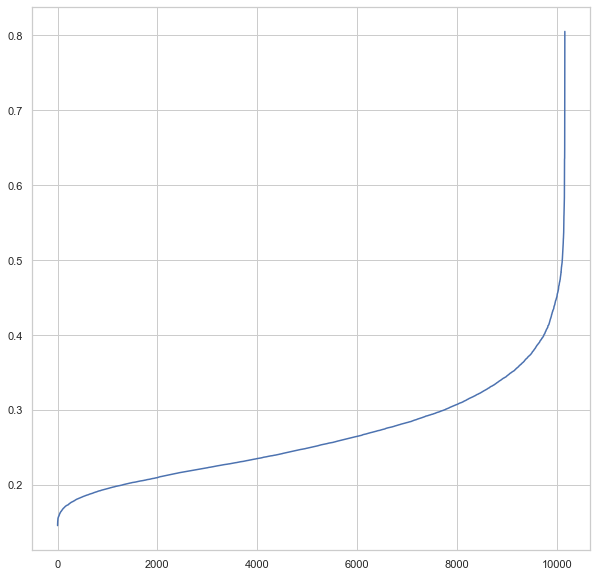

Counter({0: 10038, -1: 126})

In [363]:
# detecting outliers using DBSCAN
# only removed outliers based on univariate analysis so far
metric_features = [
    "Age",
    "YearSal",
    "FirstPolAge",
    "CustYears",
    "CMV",
    # "ClaimsRate", 
    "Motor", 
    "House", 
    "Health", 
    "Life", 
    "Work", 
    "PremTotal", 
    "EffortRatio"
]

df_temp = df_transformed[metric_features]
scaler, df_temp_scaled = data_scaler(df_temp, "minmax")

sns.set(style = "whitegrid")
plt.subplots(figsize = (10, 10))
neigh = NearestNeighbors(n_neighbors=30)
neigh.fit(df_temp_scaled)
distances, _ = neigh.kneighbors(df_temp_scaled)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

dbscan = DBSCAN(eps=0.35, min_samples=30, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df_temp_scaled)

# overview of the cluster
Counter(dbscan_labels)

In [371]:
# add outliers (126, as per DBSCAN) to df_outliers
df["Label"] = dbscan_labels
df_outliers = pd.concat([df_outliers, df[(df.Label == -1)].drop(columns = "Label")])

# remove outliers from df and df_transformed
df_transformed["Label"] = dbscan_labels

df = df[~(df.Label == -1)].drop(columns = "Label")
df_transformed = df_transformed[~(df_transformed.Label == -1)].drop(columns = "Label")

# drop Label columns
# df.drop(columns = "Label")
# df_transformed.drop(columns = "Label")

In [372]:
# update metric and non-metric features
metric_features = df.columns.drop(["EducDeg", "Children", "Generation"])
non_metric_features = ["EducDeg", "Children", "Generation"]

# compute total number of observations removed
nr_rows_removed = initial_len - len(df)
pc_rows_removed = round((nr_rows_removed / initial_len) * 100, 2)

print(
    f"Total number of observations removed: {nr_rows_removed} ({pc_rows_removed}%)\n"
    f"Final number of observations: {df.shape[0]} ({100 - pc_rows_removed}%)\n"
    f"Current number of features: {df.shape[1]}\n"
    "Features:",
    list(df.columns)
)

Total number of observations removed: 255 (2.48%)
Final number of observations: 10038 (97.52%)
Current number of features: 21
Features: ['Generation', 'Age', 'YearSal', 'EducDeg', 'Children', 'FirstPolAge', 'CustYears', 'CMV', 'ClaimsRate', 'Motor', 'MotorRatio', 'House', 'HouseRatio', 'Health', 'HealthRatio', 'Life', 'LifeRatio', 'Work', 'WorkRatio', 'PremTotal', 'EffortRatio']


<a class="anchor" id="clustering-sociodemographic"></a>

<h3><right>3.1. Sociodemographic clustering</right></h3>

In [412]:
# All sociodemographic features - Generation, Age, YearSal, EducDeg, Children
# Age, YearSal, Generation -> highly correlated, YearSal considered to be safer since we swapped BithYear and FirstPolYear earlier
# YearSal also has higher cardinality which is often advantageous
# Age highly correlated with Generation, YearSal - very identical clusters, decided to use Age
df_sociodem = df[["YearSal", "EducDeg", "Children"]]

#### 3.1.1. KMeans (YearSal, EducDeg)

Silhouette score: 0.47
Davies-Bouldin score: 0.82
Calinski-Harabasz score: 10210.64
Cluster sizes:
           obs     %
Cluster            
0        2738  27.3
1        2691  26.8
2        2356  23.5
3        2253  22.4


YearSal   EducDeg
Cluster                        
2        18060.192294  1.653650
0        22316.457536  3.122352
3        39280.078741  1.837994
1        40781.186436  3.131550

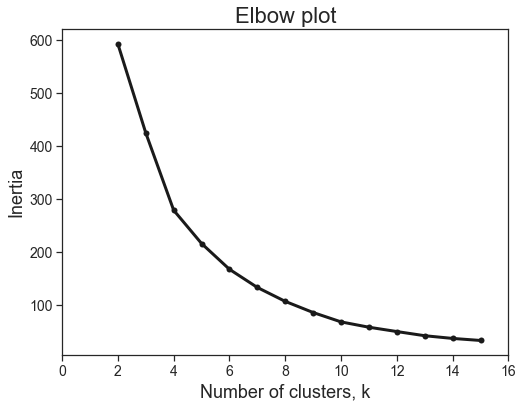

In [413]:
# scaling dataframe
# for KMeans, despite low cardinality, EducDeg was used as it an ordinal variable
km_sociodem = df_sociodem[["YearSal", "EducDeg"]]
minmax_scaler, km_sociodem_minmax = data_scaler(km_sociodem, "minmax")
standard_scaler, km_sociodem_standard = data_scaler(km_sociodem, "standard")

# # choose number of clusters
plot_elbow(km_sociodem_minmax, 15, "kmeans") 
# plot_silhouette(km_sociodem, 15)

# get cluster centroids and labels
km_sociodem_centroids, km_sociodem_labels = kmeans_clustering(km_sociodem_minmax, 4)

# cluster overview
df["Label"] = km_sociodem_labels
evaluate_clustering(km_sociodem_minmax, df.Label)
summarise_clustering(km_sociodem, df.Label, "YearSal")

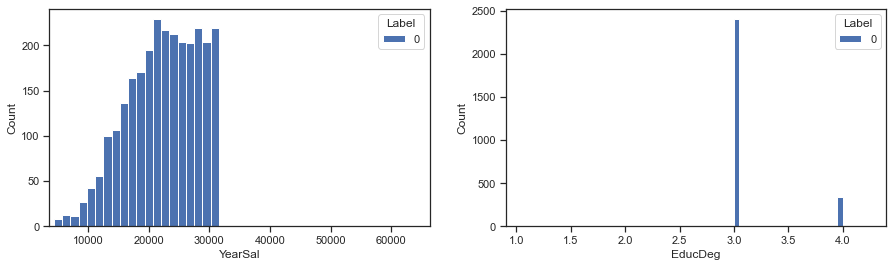

Error in callback <function flush_figures at 0x000001F14C3B3AF0> (for post_execute):


KeyboardInterrupt: 

In [414]:
visualize_clustering(km_sociodem, df.Label, ["YearSal", "EducDeg"])

#### 3.1.2. KMeans + Hierarchical (YearSal, EducDeg)

In [ ]:
# scale data
km_sociodem = df_sociodem[["YearSal", "EducDeg"]]
minmax_scaler, km_sociodem_minmax = data_scaler(km_sociodem, "minmax")
standard_scaler, km_sociodem_standard = data_scaler(km_sociodem, "standard")

# get cluster centroids and labels
km_sociodem_centroids, km_sociodem_labels = kmeans_clustering(km_sociodem_minmax, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_sociodem_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_sociodem_linkage = hierarchy.linkage(km_sociodem_centroids, method = "ward")
hierarchy.dendrogram(
    km_sociodem_linkage,
    orientation = "left",
    color_threshold = 0.85
)

# hierarchical clustering of the centroids obtained
hc_sociodem_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(km_sociodem_centroids)
hc_sociodem_labels = pd.Series(hc_sociodem_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_sociodem_centroids = pd.DataFrame(minmax_scaler.inverse_transform(km_sociodem_centroids), columns = ["YearSal", "EducDeg"])
km_sociodem_centroids = pd.concat([km_sociodem_centroids, hc_sociodem_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_sociodem_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_sociodem_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_sociodem_minmax, df.Label)
summarise_clustering(km_sociodem, df.Label, "YearSal")

In [ ]:
visualize_clustering(km_sociodem, df.Label, ["Age", "EducDeg"])

#### 3.1.3. Hierarchical (YearSal, EducDeg)

In [ ]:
# scale data
hc_sociodem = df_sociodem[["YearSal", "EducDeg"]]
minmax_scaler, hc_sociodem_minmax = data_scaler(hc_sociodem, "minmax")
standard_scaler, hc_sociodem_standard = data_scaler(hc_sociodem, "standard")

# visualize dendrogram
hc_sociodem_distances, hc_sociodem_labels, hc_sociodem_linkage = hierarchical_clustering(
    hc_sociodem_minmax, 
    n_clusters = None, 
    threshold = 0, 
    affinity = "euclidean", 
    linkage = "ward"
)

sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
hierarchy.dendrogram(
    hc_sociodem_linkage,
    orientation = "left",
    p = 4,
    truncate_mode = "level",
    color_threshold = 15
)

# perform AgglomerativeClustering
hc_sociodem_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(hc_sociodem_minmax)
hc_sociodem_labels = hc_sociodem_clusters.labels_

# overview of the clusters
df["Label"] = hc_sociodem_labels
evaluate_clustering(hc_sociodem_minmax, df.Label)
summarise_clustering(hc_sociodem, df.Label, "YearSal")

#### 3.1.4. DBSCAN (YearSal, EducDeg)

In [ ]:
# scale data
db_sociodem = df_sociodem[["YearSal", "EducDeg"]]
minmax_scaler, db_sociodem_minmax = data_scaler(db_sociodem, "minmax")
standard_scaler, db_sociodem_standard = data_scaler(db_sociodem, "standard")

# # find possible values for eps
# for eps in np.arange(0.05, 0.41, 0.05):
#     db_sociodem_clusters = DBSCAN(eps = eps).fit(db_sociodem_minmax)
#     print(f"Clusters with eps = {round(eps, 2)}: {set(db_sociodem_clusters.labels_)}")

# get clusters and labels based on selected eps
db_sociodem_clusters = DBSCAN(eps = 0.20).fit(db_sociodem_minmax)
db_sociodem_labels = db_sociodem_clusters.labels_

# overview of the cluster
df["Label"] = db_sociodem_labels
evaluate_clustering(db_sociodem_minmax, df.Label)
summarise_clustering(db_sociodem, df.Label, "YearSal")

#### 3.1.5. KPrototypes (YearSal, EducDeg, Children)

In [ ]:
# kprototypes: https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.15.4028&rep=rep1&type=pdf

# scale data
kp_sociodem = df_sociodem[["YearSal", "EducDeg", "Children"]]
minmax_scaler, kp_sociodem_minmax = data_scaler(kp_sociodem, "minmax")
standard_scaler, kp_sociodem_standard = data_scaler(kp_sociodem, "standard")

# # elbow plot
# # suggests 4-8 clusters
# plot_elbow(kp_sociodem_minmax, nmax_clusters = 15, algorithm = "kprototypes", cat_index = [1, 2])

# compute centroids and labels with k = 4
kp_sociodem_centroids, kp_sociodem_labels = kprototypes_clustering(kp_sociodem_minmax, k = 4, cat_index = [1, 2], init = "Huang")

# cluster overview
df["Label"] = kp_sociodem_labels
evaluate_clustering(kp_sociodem_minmax, kp_sociodem_labels)
summarise_clustering(kp_sociodem, df.Label, sort_by = "YearSal")

In [ ]:
visualize_clustering(kp_sociodem, df.Label, ["YearSal", "EducDeg", "Children"])

In [ ]:
# compute centroids and labels with k = 6
kp_sociodem_centroids, kp_sociodem_labels = kprototypes_clustering(kp_sociodem_minmax, k = 6, cat_index = [1, 2], init = "Huang")

# cluster overview
df["Label"] = kp_sociodem_labels
evaluate_clustering(kp_sociodem_minmax, kp_sociodem_labels)
summarise_clustering(df, df.Label, sort_by = "YearSal")

In [ ]:
visualize_clustering(kp_sociodem, df.Label, ["YearSal", "EducDeg", "Children"])

In [ ]:
# strip plot for cluster visualization?
# sns.set_style("ticks")

# # test = df.copy()
# # test.EducDeg = test.EducDeg.replace(educ_mapper)

# x_vars = ["Age", "EducDeg"]

# g = sns.PairGrid(df.sort_values("Age", ascending = False),
#                  x_vars = x_vars, y_vars = ["Cluster"],
#                  hue = "Children",
#                  height = 8,
#                  aspect = 0.85)

# g.map(sns.stripplot, size = 12, orient = "h", jitter = True,
#       palette = ["gray", "palevioletred"], alpha = 0.1)

# # add better labels
# g.set(ylabel = "Clusters")

# titles = ["Age", "EducDeg"]

# for ax, title in zip(g.axes.flat, titles):

#     # set axis titles
#     ax.set(title = title)

#     # horizontal grid
#     ax.xaxis.grid(False)
#     ax.yaxis.grid(True, lw = 1.5)
    
# plt.legend(title = "Children")

#### 3.1.6. Birch (Age, EducDeg)

In [ ]:
# scale data
birch_sociodem = df_sociodem[["YearSal", "EducDeg"]]
minmax_scaler, birch_sociodem_minmax = data_scaler(birch_sociodem, "minmax")
standard_scaler, birch_sociodem_standard = data_scaler(birch_sociodem, "standard")
robust_scaler, birch_sociodem_robust = data_scaler(birch_sociodem, "robust")

# find suitable threshold values
# for t in np.arange(0.01, 0.50, 0.05):
#     birch_sociodem_clusters = Birch(threshold = t).fit(birch_sociodem_minmax)
#     birch_sociodem_labels = birch_sociodem_clusters.labels_
#     print(t)
#     print(set(birch_sociodem_labels))

# obtain clusters and labels
birch_sociodem_clusters = Birch(threshold = 0.2).fit(birch_sociodem_minmax)
birch_sociodem_labels = birch_sociodem_clusters.labels_

# overview of the clusters
df["Label"] = birch_sociodem_labels
evaluate_clustering(birch_sociodem_minmax, df.Label)
summarise_clustering(df, df.Label, "CMV")

In [ ]:
visualize_clustering(birch_sociodem, birch_sociodem_labels, ["YearSal", "EducDeg"])

#### 3.1.7. KModes (Generation, EducDeg, Children)

In [ ]:
from kmodes.kmodes import KModes

kmodes_sociodem = df[["Generation", "EducDeg", "Children"]]

cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1, random_state = 123)
    kmode.fit_predict(kmodes_sociodem)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
kmode = KModes(n_clusters=6, init = "random", n_init = 5, verbose=1, random_state = 123)
kmodes_sociodem_clusters = kmode.fit_predict(kmodes_sociodem)

# overview of the cluster
df["Label"] = kmodes_sociodem_clusters
evaluate_clustering(kmodes_sociodem, df.Label)
summarise_clustering(kmodes_sociodem, df.Label, "Generation")

In [ ]:
visualize_clustering(kmodes_sociodem, df.Label, ["Generation", "EducDeg", "Children"])

<a class="anchor" id="clustering-sociodemographic"></a>

<h3><right>3.2. Value clustering</right></h3>

In [ ]:
# potentially relevant features for customer segmentation based on value
df_value = df_transformed[[
    "FirstPolAge",
    "CustYears",
    "CMV",
    "ClaimsRate",
    "PremTotal",
    "EffortRatio"
]]

corr_heatmap(df_value, 0.2, "pearson")

In [ ]:
# ClaimsRate and CMV are highly correlated with each other but have no correlation with anything else - discarded
# features for customer segmentation based on value
df_value = df_transformed[[
    "FirstPolAge",
    "CustYears",
    "CMV",
    "PremTotal",
    "EffortRatio"
]]
corr_heatmap(df_value, 0.2, "pearson")

#### 3.2.1. KMeans (FirstPolAge, PremTotal, EffortRatio)

In [462]:
# scale data
km_value = df_value[["FirstPolAge", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# elbow plot
# plot_elbow(km_value_standard, 20, "kmeans")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_standard, 6)

# cluster overview
df["Label"] = km_value_labels
evaluate_clustering(km_value_standard, df.Label)
summarise_clustering(km_value, df.Label, sort_by = "FirstPolAge")

Silhouette score: 0.33
Davies-Bouldin score: 0.91
Calinski-Harabasz score: 8064.8
Cluster sizes:
           obs     %
Cluster            
0        2502  24.9
1         676   6.7
2        1074  10.7
3        2445  24.4
4        1506  15.0
5        1835  18.3


FirstPolAge  PremTotal  EffortRatio
Cluster                                     
4           7.744356  31.140560     0.232019
0           7.953637  27.749917     0.178584
1           9.467456  35.844099     0.321182
3          24.193047  27.750890     0.150465
2          34.639665  32.641412     0.164210
5          42.827793  28.356819     0.138012

In [463]:
# CMV has little importance for clustering using KMeans
r2_variables(df[[ "FirstPolAge", "PremTotal", "EffortRatio", "Label"]], 'Label').drop("Label")

FirstPolAge    0.840865
PremTotal      0.733939
EffortRatio    0.727102
dtype: float64

#### 3.2.2. KMeans ( PremTotal, EffortRatio)

Silhouette score: 0.36
Davies-Bouldin score: 0.92
Calinski-Harabasz score: 8198.0
Cluster sizes:
           obs     %
Cluster            
0        3463  34.5
1        1850  18.4
2        2794  27.8
3         767   7.6
4        1164  11.6


FirstPolAge  PremTotal  EffortRatio
Cluster                                     
1           7.263784  30.491980     0.223458
3           9.375489  35.538449     0.315489
0          13.231591  27.560459     0.165291
4          34.846220  32.498115     0.163457
2          37.901217  28.118584     0.140592

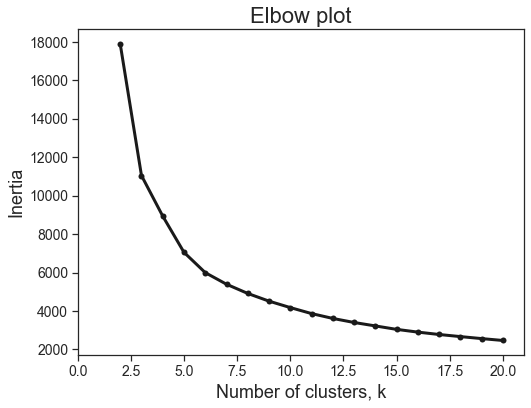

In [464]:
# scale data
km_value = df_value[["FirstPolAge", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# elbow plot
plot_elbow(km_value_standard, 20, "kmeans")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_standard, 5)

# cluster overview
df["Label"] = km_value_labels
evaluate_clustering(km_value_standard, df.Label)
summarise_clustering(km_value, df.Label, sort_by = "FirstPolAge")

In [465]:
r2_variables(df[["FirstPolAge", "PremTotal", "EffortRatio", "Label"]], 'Label').drop("Label")

FirstPolAge    0.752950
PremTotal      0.721008
EffortRatio    0.714584
dtype: float64

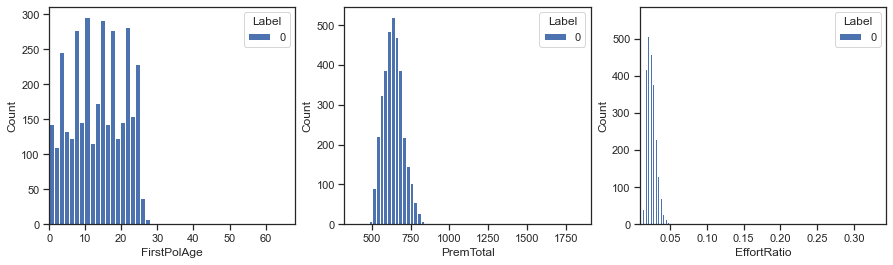

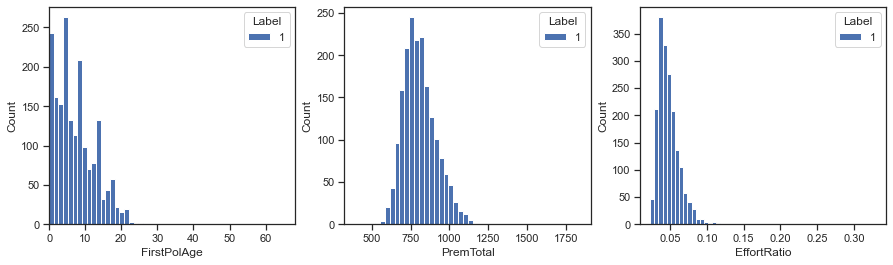

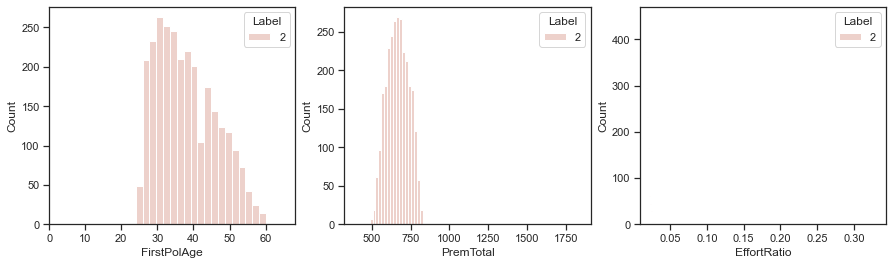

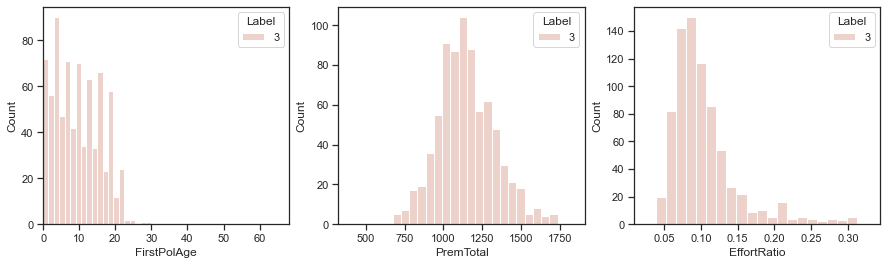

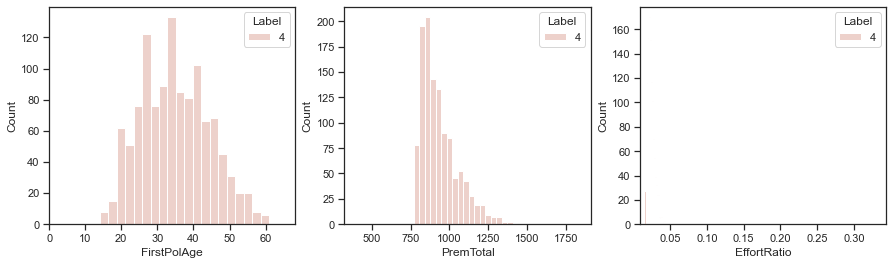

In [466]:
visualize_clustering(df, df.Label, ["FirstPolAge", "PremTotal", "EffortRatio"])

#### 3.2.5. KMeans + Hierarchical ("FirstPolAge", "PremTotal", "EffortRatio")

Silhouette score: 0.35
Davies-Bouldin score: 0.93
Calinski-Harabasz score: 6279.08
Cluster sizes:
           obs     %
Cluster            
0        5963  59.4
1         616   6.1
2        3459  34.5


FirstPolAge  PremTotal  EffortRatio
Cluster                                     
2           6.943047  29.202261     0.206013
1           9.478896  36.140091     0.322054
0          30.697971  28.882817     0.150909

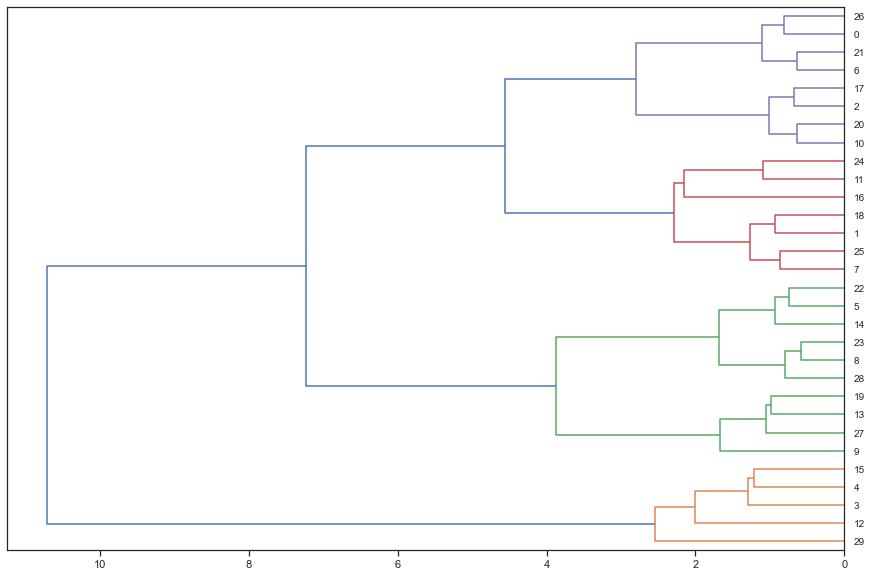

In [468]:
# scale data
km_value = df_value[["FirstPolAge", "PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_standard, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_value_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_value_linkage = hierarchy.linkage(km_value_centroids, method = "ward")
hierarchy.dendrogram(
    km_value_linkage,
    orientation = "left",
    color_threshold = 4.5
)

# hierarchical clustering of the centroids obtained
hc_value_clusters = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward").fit(km_value_centroids)
hc_value_labels = pd.Series(hc_value_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_value_centroids = pd.DataFrame(standard_scaler.inverse_transform(km_value_centroids), columns = ["FirstPolAge", "PremTotal", "EffortRatio"])
km_value_centroids = pd.concat([km_value_centroids, hc_value_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_value_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_value_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_value_standard, df.Label)
summarise_clustering(km_value, df.Label, "FirstPolAge")

In [469]:
r2_variables(df[["FirstPolAge", "PremTotal", "EffortRatio", "Label"]], 'Label').drop("Label")

FirstPolAge    0.593240
PremTotal      0.401484
EffortRatio    0.649198
dtype: float64

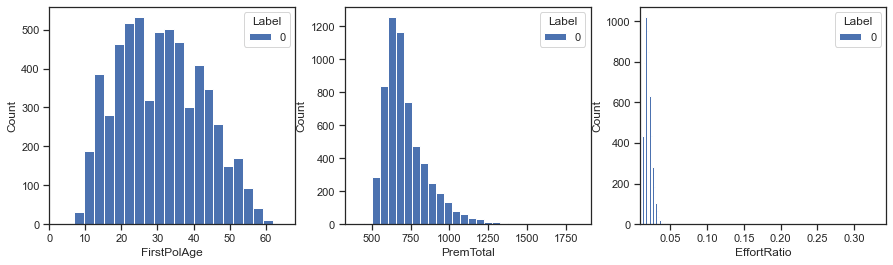

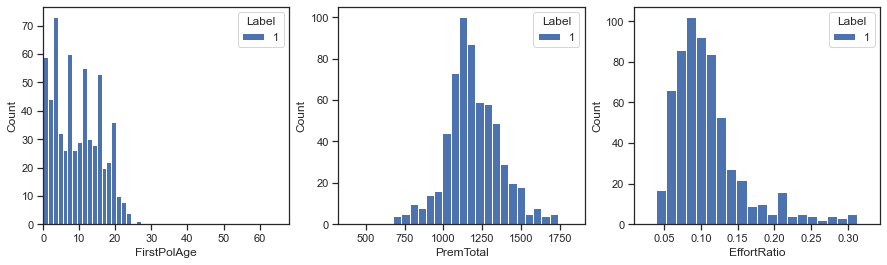

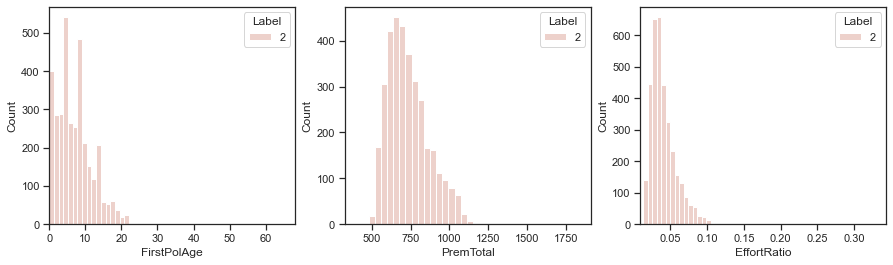

In [470]:
visualize_clustering(df, df.Label, ["FirstPolAge", "PremTotal", "EffortRatio"])

#### 3.2.6. KMeans + Hierarchical (PremTotal, EffortRatio)

Silhouette score: 0.43
Davies-Bouldin score: 0.88
Calinski-Harabasz score: 10330.31
Cluster sizes:
           obs     %
Cluster            
0        3650  36.4
1         645   6.4
2        5743  57.2


PremTotal  EffortRatio
Cluster                        
0        30.960680     0.201243
1        35.926294     0.323178
2        27.741983     0.151118

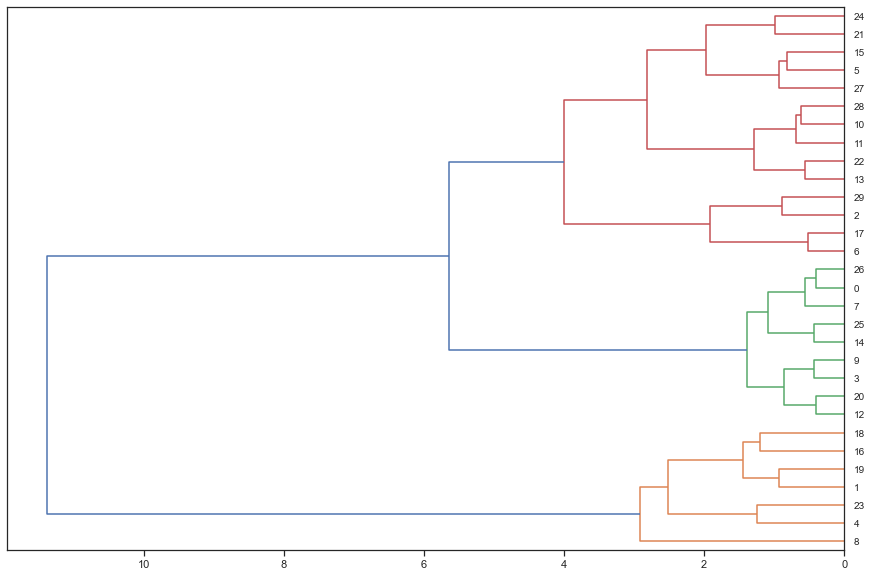

In [472]:
# scale data
km_value = df_value[["PremTotal", "EffortRatio"]]
minmax_scaler, km_value_minmax = data_scaler(km_value, "minmax")
standard_scaler, km_value_standard = data_scaler(km_value, "standard")
robust_scaler, km_value_robust = data_scaler(km_value, "robust")

# get cluster centroids and labels
km_value_centroids, km_value_labels = kmeans_clustering(km_value_standard, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_value_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_value_linkage = hierarchy.linkage(km_value_centroids, method = "ward")
hierarchy.dendrogram(
    km_value_linkage,
    orientation = "left",
    color_threshold = 5
)

# hierarchical clustering of the centroids obtained
hc_value_clusters = AgglomerativeClustering(n_clusters = 3, affinity = "euclidean", linkage = "ward").fit(km_value_centroids)
hc_value_labels = pd.Series(hc_value_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_value_centroids = pd.DataFrame(standard_scaler.inverse_transform(km_value_centroids), columns = ["PremTotal", "EffortRatio"])
km_value_centroids = pd.concat([km_value_centroids, hc_value_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_value_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_value_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_value_standard, df.Label)
summarise_clustering(km_value, df.Label)

In [473]:
r2_variables(df[["PremTotal", "EffortRatio", "Label"]], 'Label').drop("Label")

PremTotal      0.647184
EffortRatio    0.655974
dtype: float64

#### 3.2.7. Hierarchical

Silhouette score: 0.32
Davies-Bouldin score: 0.97
Calinski-Harabasz score: 6931.41
Cluster sizes:
           obs     %
Cluster            
0        3888  38.7
1        3795  37.8
2        1022  10.2
3        1333  13.3


FirstPolAge  PremTotal  EffortRatio
Cluster                                     
2           8.149706  34.849678     0.297269
0           8.709619  28.711289     0.192098
1          31.419236  27.884123     0.144824
3          38.618905  31.834239     0.157961

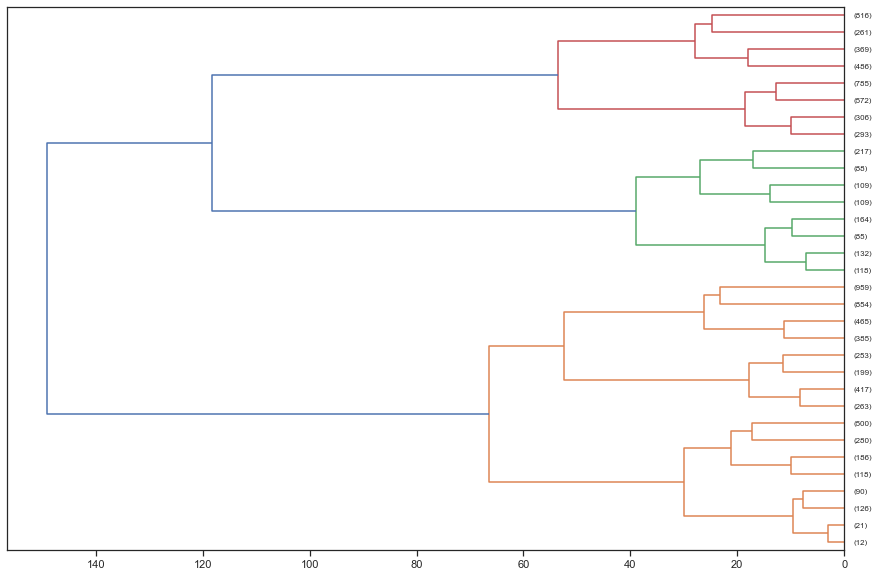

In [474]:
# scale data
hc_value = df_value[["FirstPolAge", "PremTotal", "EffortRatio"]]
minmax_scaler, hc_value_minmax = data_scaler(hc_value, "minmax")
standard_scaler, hc_value_standard = data_scaler(hc_value, "standard")
robust_scaler, hc_value_robust = data_scaler(hc_value, "robust")

hc_value_distances, hc_value_labels, hc_value_linkage = hierarchical_clustering(
    hc_value_standard, 
    n_clusters = None, 
    threshold = 0, 
    affinity = "euclidean", 
    linkage = "ward"
)

sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
hierarchy.dendrogram(
    hc_value_linkage,
    orientation = "left",
    p = 4,
    truncate_mode = "level",
    color_threshold = 100
)

# perform AgglomerativeClustering
hc_value_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(hc_value_standard)
hc_value_labels = hc_value_clusters.labels_

# overview of the clusters
df["Label"] = hc_value_labels
evaluate_clustering(hc_value_standard, df.Label)
summarise_clustering(hc_value, df.Label, "FirstPolAge")

In [475]:
r2_variables(df[["PremTotal", "EffortRatio", "Label"]], 'Label').drop("Label")

PremTotal      0.608511
EffortRatio    0.614092
dtype: float64

#### 3.2.8. DBSCAN

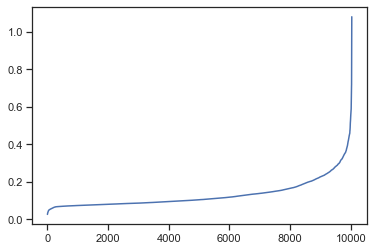

Counter({0: 9985, -1: 37, 1: 5, 2: 11})

Silhouette score: 0.43
Davies-Bouldin score: 0.7
Calinski-Harabasz score: 45.33
Cluster sizes:
           obs     %
Cluster            
-1         37   0.4
 0       9985  99.5
 1          5   0.0
 2         11   0.1


FirstPolAge  PremTotal  EffortRatio
Cluster                                     
-1         15.594595  32.003431     0.286441
 0         21.251778  29.427586     0.179672
 1         10.200000  30.667497     0.367211
 2          7.272727  29.931110     0.399596

In [482]:
# scale data
db_value = df_value[["FirstPolAge", "PremTotal", "EffortRatio"]]
minmax_scaler, db_value_minmax = data_scaler(db_value, "minmax")
standard_scaler, db_value_standard = data_scaler(db_value, "standard")
robust_scaler, db_value_robust = data_scaler(db_value, "robust")

# find adequate values for eps
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(db_value_standard)
distances, _ = neigh.kneighbors(db_value_standard)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

# get clusters and labels based on selected eps
db_value_clusters = DBSCAN(eps = 0.4, min_samples = 5).fit(db_value_standard)
db_value_labels = db_value_clusters.labels_
display(Counter(db_value_clusters.labels_))
# overview of the clusters
df["Label"] = db_value_labels
evaluate_clustering(db_value_standard, df.Label)
summarise_clustering(db_value, df.Label)

In [483]:
r2_variables(df[["PremTotal", "EffortRatio", "Label"]], 'Label').drop("Label")

PremTotal      0.003954
EffortRatio    0.052099
dtype: float64

#### 3.2.9. BIRCH

In [484]:
# scale data
birch_value = df_value[["FirstPolAge", "PremTotal", "EffortRatio"]]
minmax_scaler, birch_value_minmax = data_scaler(birch_value, "minmax")
standard_scaler, birch_value_standard = data_scaler(birch_value, "standard")
robust_scaler, birch_value_robust = data_scaler(birch_value, "robust")

# model and labels
birch_value_clusters = Birch(threshold = 0.2).fit(birch_value_standard)
birch_value_labels = birch_value_clusters.labels_
set(birch_value_labels)

# overview of the clusters
df["Label"] = birch_value_labels
evaluate_clustering(birch_value_standard, df.Label)
summarise_clustering(birch_value, df.Label, "FirstPolAge")

Silhouette score: 0.37
Davies-Bouldin score: 0.9
Calinski-Harabasz score: 7791.31
Cluster sizes:
           obs     %
Cluster            
0        1311  13.1
1        4905  48.9
2        3822  38.1


FirstPolAge  PremTotal  EffortRatio
Cluster                                     
0           8.919908  34.206979     0.283950
2           9.094453  28.262643     0.186233
1          33.935576  29.079711     0.148179

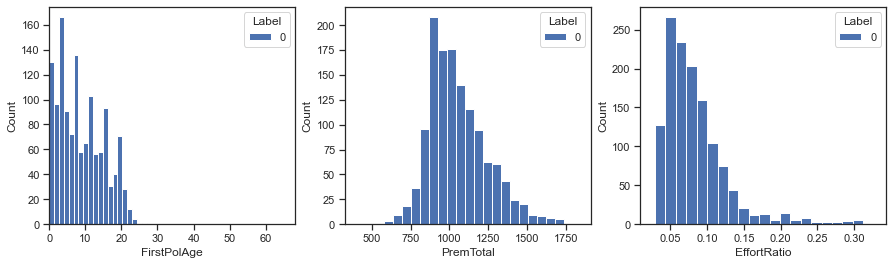

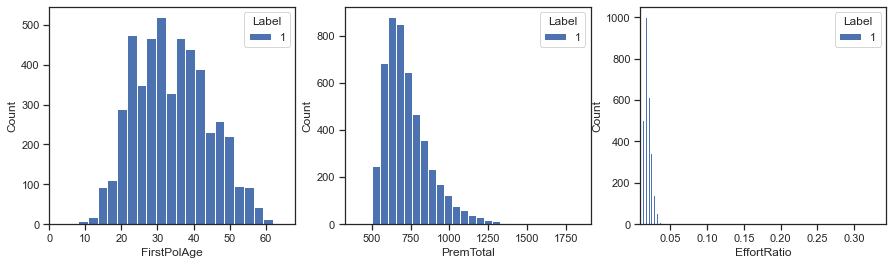

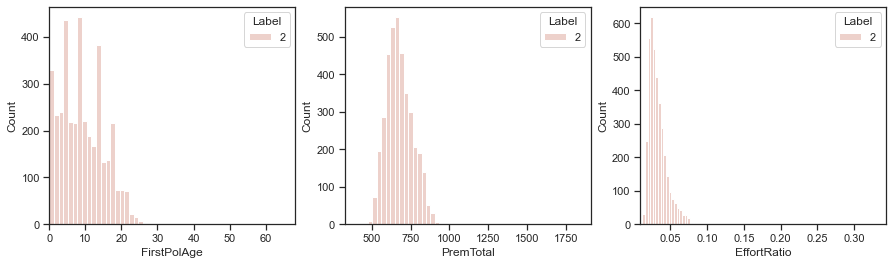

In [485]:
visualize_clustering(df, df.Label, ["FirstPolAge", "PremTotal", "EffortRatio"])

In [486]:
r2_variables(df[["PremTotal", "EffortRatio", "Label"]], 'Label').drop("Label")

PremTotal      0.452042
EffortRatio    0.578596
dtype: float64

#### 3.2.10. SOM + HC

In [487]:
# scale data
som_value = df_value[["FirstPolAge", "PremTotal", "EffortRatio"]]
minmax_scaler, som_value_minmax = data_scaler(som_value, "minmax")
standard_scaler, som_value_standard = data_scaler(som_value, "standard")
robust_scaler, som_value_robust = data_scaler(som_value, "robust")

names = ["CMV", "FirstPolAge", "PremTotal", "EffortRatio"]

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_value_standard.values,
    mapsize = (20, 20),
    # normalization = "var",
    initialization = "random",
    component_names = names,
    lattice = "rect",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

 Training...
 random_initialization took: 0.004000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  0.247000, quantization error: 0.403449

 epoch: 2 ---> elapsed time:  0.116000, quantization error: 1.368486

 epoch: 3 ---> elapsed time:  0.137000, quantization error: 0.860800

 epoch: 4 ---> elapsed time:  0.122000, quantization error: 0.757148

 epoch: 5 ---> elapsed time:  0.121000, quantization error: 0.705495

 epoch: 6 ---> elapsed time:  0.158000, quantization error: 0.681119

 epoch: 7 ---> elapsed time:  0.137000, quantization error: 0.669221

 epoch: 8 ---> elapsed time:  0.168000, quantization error: 0.661329

 epoch: 9 ---> elapsed time:  0.153000, quantization error: 0.655632

 epoch: 10 ---> elapsed time:  0.141000, quantization error: 0.651382

 epoch: 11 ---> elapsed time:  0.140000, quantization error: 0.647433

 epoch: 12 ---> elapsed time:  0.119000, quantization error: 0.643883

 epoch: 13 ---> 

ValueError: Number of rows must be a positive integer, not 2.333333333333333

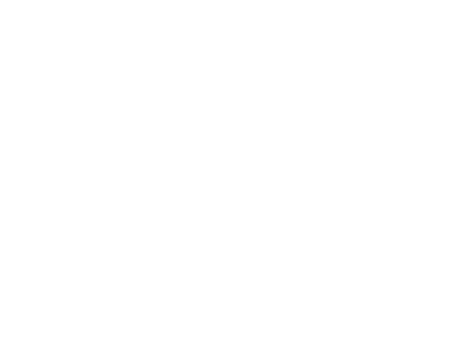

In [439]:
# SOM results
final_clusters = pd.DataFrame(sm._data, columns = ["CMV", "FirstPolAge", "PremTotal", "EffortRatio"])
my_labels = pd.Series(sm._bmu[0], name = "Label")
final_clusters = pd.concat([final_clusters, my_labels], axis = 1)

# visualization 1
view2D  = View2DPacked(10, 10, "", text_size = 7)
view2D.show(sm, col_sz = 3, what = 'codebook',) #which_dim="all", denormalize=True)
plt.show()

# visualization 2
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=10, cmap="Blues", logaritmic=False)

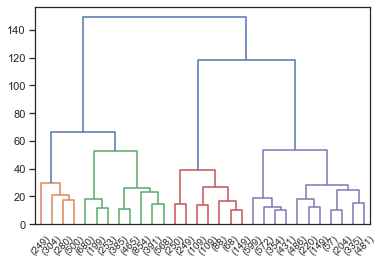

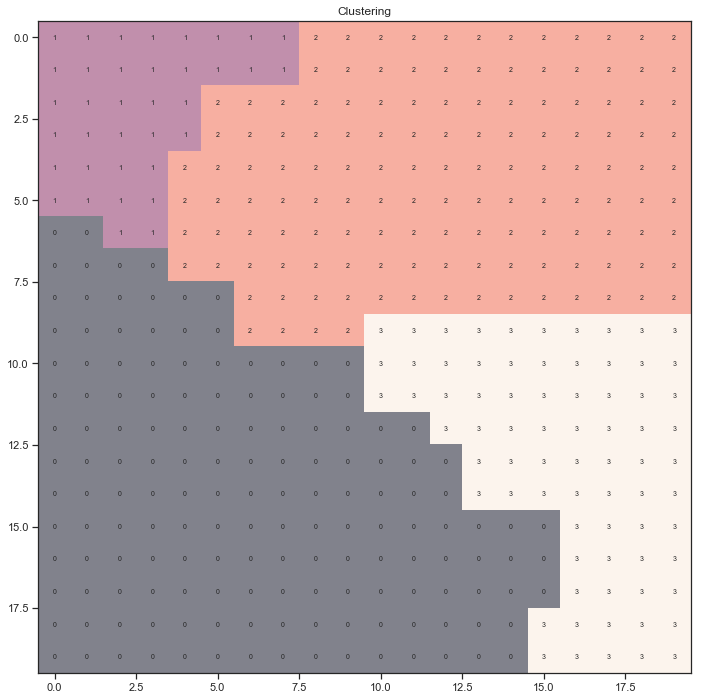

In [488]:
# apply HC to SOM results
som_value_linkage = hierarchy.linkage(sm._data, method = "ward")
hierarchy.dendrogram(
    som_value_linkage,
    truncate_mode = "lastp",
    p = 30,
    orientation = "top",
    color_threshold = 60
)

# k = 2 or k = 4 (from dendrogram)
hc_value_labels = AgglomerativeClustering(4).fit_predict(sm.codebook.matrix)
sm.cluster_labels = hc_value_labels

# visualize clusters
hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [489]:
# final SOM + HC clusters
hc_final_clusters = AgglomerativeClustering(4).fit(sm._data)
hc_final_labels = hc_final_clusters.labels_

# overview of the clusters
df["Label"] = hc_final_labels
evaluate_clustering(som_value_minmax, df.Label)
summarise_clustering(som_value, df.Label, "FirstPolAge")

Silhouette score: 0.32
Davies-Bouldin score: 1.05
Calinski-Harabasz score: 7336.49
Cluster sizes:
           obs     %
Cluster            
0        3888  38.7
1        3795  37.8
2        1022  10.2
3        1333  13.3


FirstPolAge  PremTotal  EffortRatio
Cluster                                     
2           8.149706  34.849678     0.297269
0           8.709619  28.711289     0.192098
1          31.419236  27.884123     0.144824
3          38.618905  31.834239     0.157961

In [490]:
r2_variables(df[["PremTotal", "EffortRatio", "Label"]], 'Label').drop("Label")

PremTotal      0.608511
EffortRatio    0.614092
dtype: float64

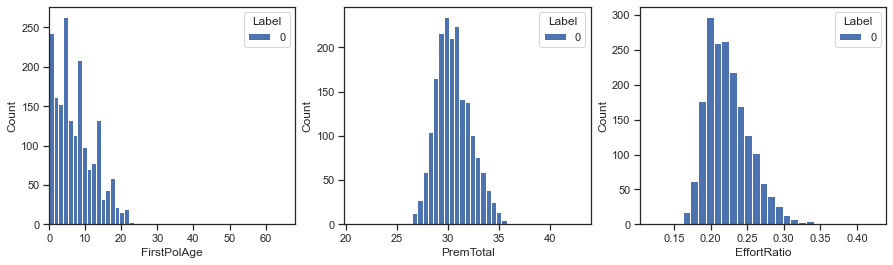

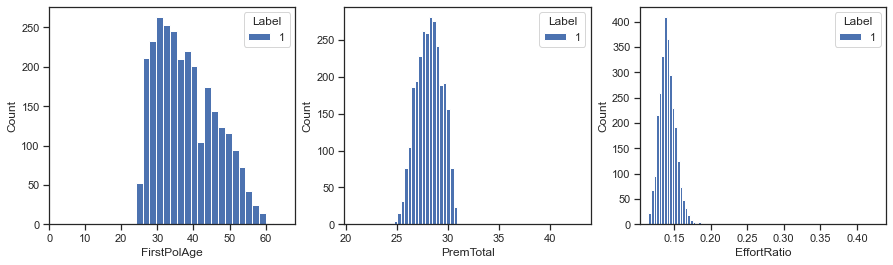

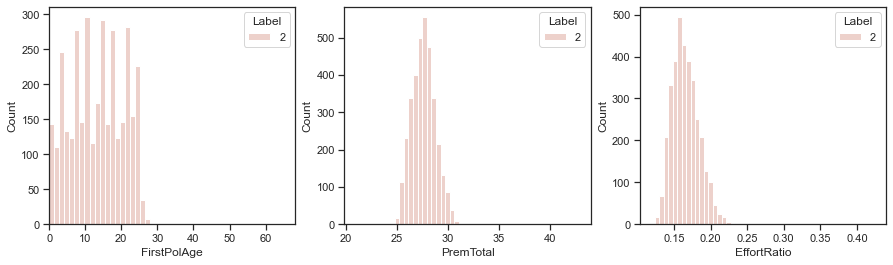

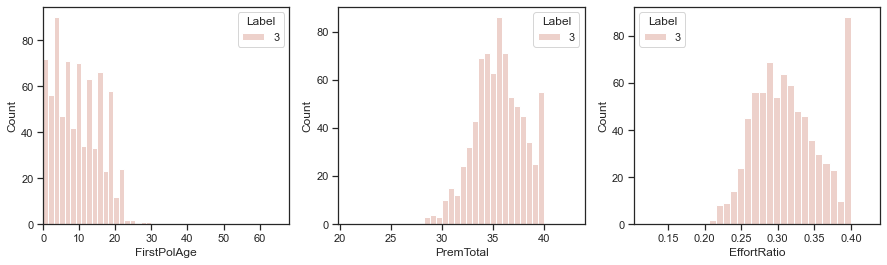

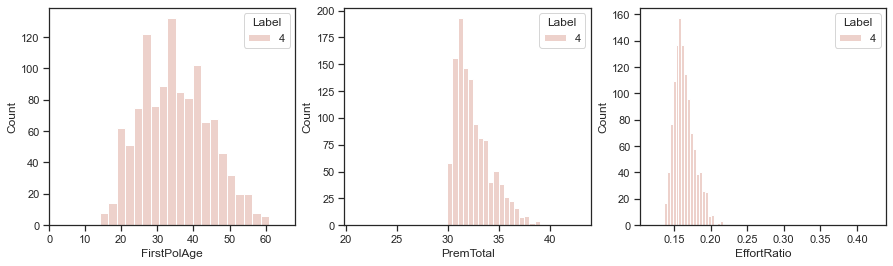

In [494]:
# visualize clusters
visualize_clustering(som_value, df.Label, ["FirstPolAge","PremTotal", "EffortRatio"])

#### 3.2.11. SOM + KMeans

In [491]:
# scale data
som_value = df_value[["FirstPolAge", "PremTotal", "EffortRatio"]]
minmax_scaler, som_value_minmax = data_scaler(som_value, "minmax")
standard_scaler, som_value_standard = data_scaler(som_value, "standard")
robust_scaler, som_value_robust = data_scaler(som_value, "robust")

names = ["FirstPolAge", "PremTotal", "EffortRatio"]

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_value_standard.values,
    mapsize = (20, 20),
    # normalization = "var",
    initialization = "random",
    component_names = names,
    lattice = "rect",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  0.157000, quantization error: 0.403449

 epoch: 2 ---> elapsed time:  0.090000, quantization error: 1.368486

 epoch: 3 ---> elapsed time:  0.115000, quantization error: 0.860800

 epoch: 4 ---> elapsed time:  0.156000, quantization error: 0.757148

 epoch: 5 ---> elapsed time:  0.121000, quantization error: 0.705495

 epoch: 6 ---> elapsed time:  0.149000, quantization error: 0.681119

 epoch: 7 ---> elapsed time:  0.165000, quantization error: 0.669221

 epoch: 8 ---> elapsed time:  0.130000, quantization error: 0.661329

 epoch: 9 ---> elapsed time:  0.125000, quantization error: 0.655632

 epoch: 10 ---> elapsed time:  0.140000, quantization error: 0.651382

 epoch: 11 ---> elapsed time:  0.113000, quantization error: 0.647433

 epoch: 12 ---> elapsed time:  0.120000, quantization error: 0.643883

 epoch: 13 ---> 

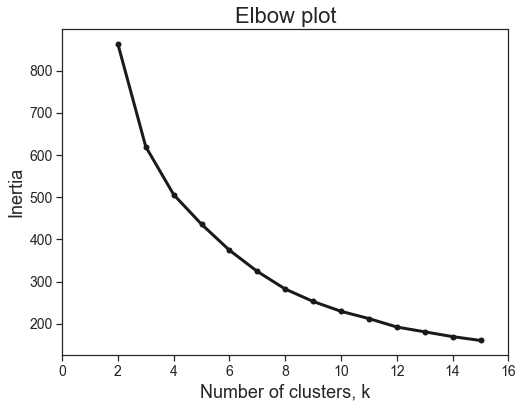

In [446]:
# SOM + KMeans
plot_elbow(sm.codebook.matrix, 15, "kmeans")

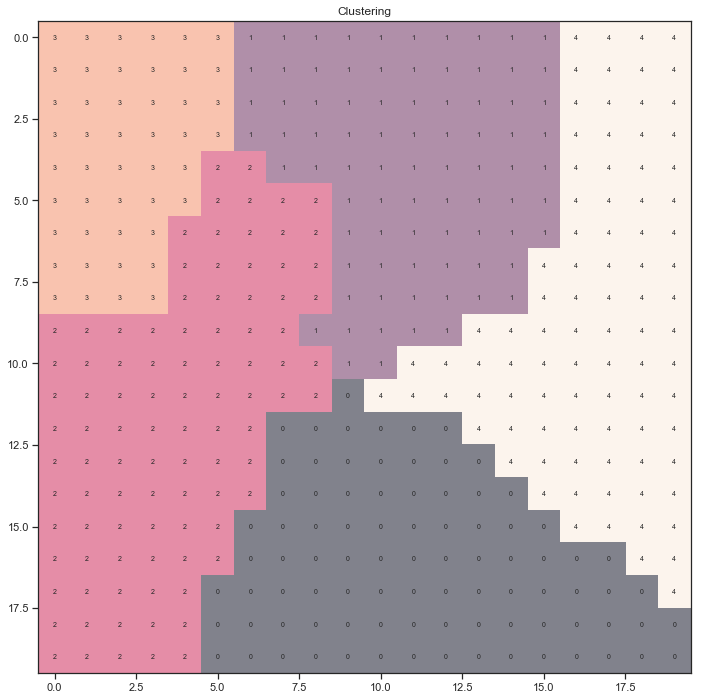

In [447]:
kmeans = KMeans(n_clusters = 5, random_state = 15)
km_value_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = km_value_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate = True, onlyzeros = False, labelsize = 7, cmap = "Pastel1")

plt.show()

In [492]:
# final SOM + KMeans clusters
km_final_clusters = KMeans(5).fit(sm._data)
km_final_labels = km_final_clusters.labels_

df["Label"] = km_final_labels
evaluate_clustering(som_value_standard, df.Label)
summarise_clustering(som_value, df.Label, "FirstPolAge")

Silhouette score: 0.36
Davies-Bouldin score: 0.92
Calinski-Harabasz score: 8198.07
Cluster sizes:
           obs     %
Cluster            
0        1851  18.4
1        2800  27.9
2        3457  34.4
3         767   7.6
4        1163  11.6


FirstPolAge  PremTotal  EffortRatio
Cluster                                     
0           7.269044  30.492694     0.223431
3           9.375489  35.538449     0.315489
2          13.210298  27.559214     0.165308
4          34.896819  32.499607     0.163447
1          37.860000  28.118550     0.140624

In [493]:
r2_variables(df[["FirstPolAge", "PremTotal", "EffortRatio", "Label"]], 'Label').drop("Label")

FirstPolAge    0.752933
PremTotal      0.721130
EffortRatio    0.714522
dtype: float64

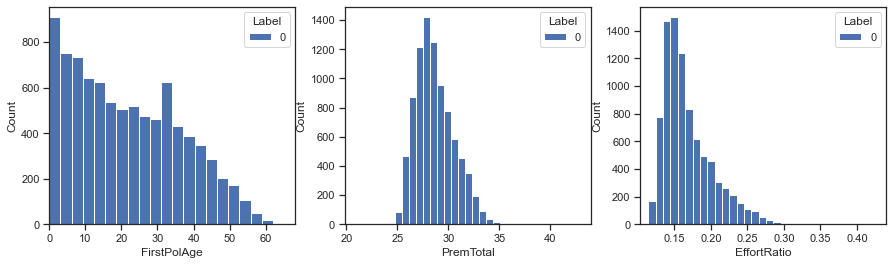

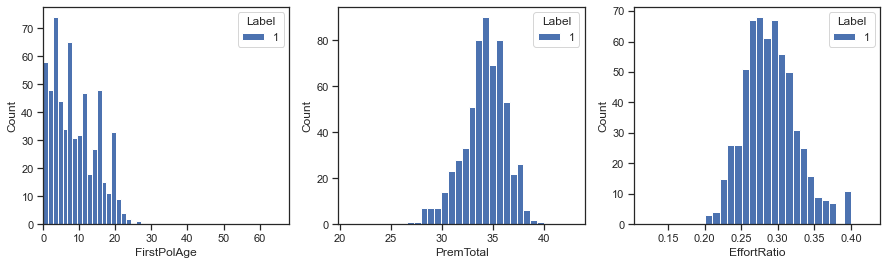

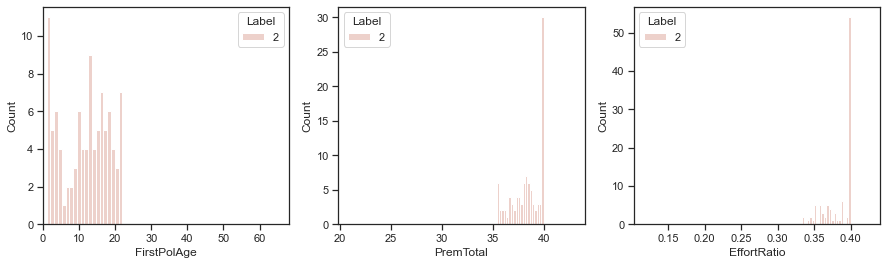

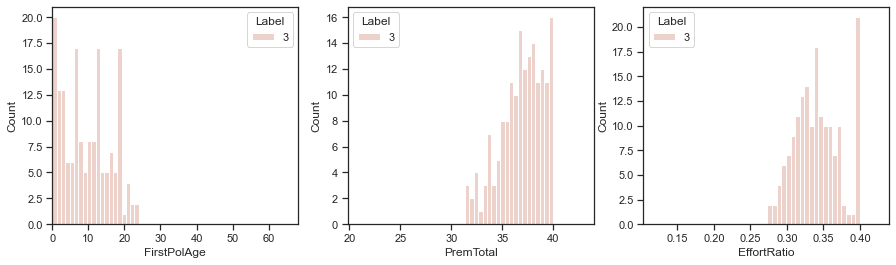

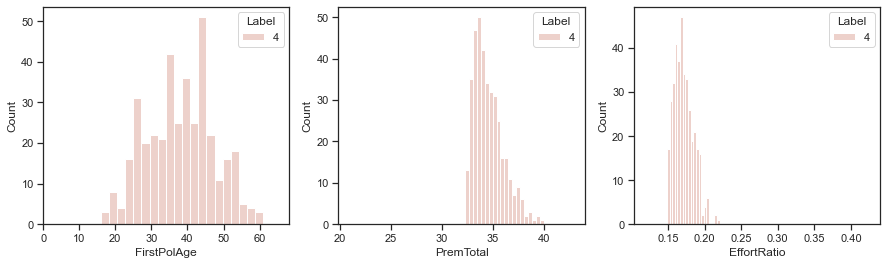

In [501]:
# visualize clusters
visualize_clustering(som_value, df.Label, ["FirstPolAge", "PremTotal", "EffortRatio"])

#### 3.2.12. AffinityPropagation ("FirstPolAge", "PremTotal", "EffortRatio")

In [495]:
# scale data
ap_value = df_value[["FirstPolAge", "PremTotal", "EffortRatio"]]
minmax_scaler, ap_value_minmax = data_scaler(ap_value, "minmax")
standard_scaler, ap_value_standard = data_scaler(ap_value, "standard")
robust_scaler, ap_value_robust = data_scaler(ap_value, "robust")

# get clusters and labels based on selected eps
ap_value_clusters = AffinityPropagation(damping = 0.7, verbose = True).fit(ap_value_standard)
ap_value_labels = ap_value_clusters.labels_

# overview of the clusters
df["Label"] = ap_value_labels
evaluate_clustering(ap_value_standard, df.Label)
summarise_clustering(ap_value, df.Label, "FirstPolAge")

Converged after 79 iterations.
Silhouette score: 0.23
Davies-Bouldin score: 1.05
Calinski-Harabasz score: 3199.6
Cluster sizes:
          obs    %
Cluster          
0         63  0.6
1        115  1.1
2         47  0.5
3        111  1.1
4         77  0.8
...      ...  ...
139       50  0.5
140       52  0.5
141       87  0.9
142       45  0.4
143      186  1.9

[144 rows x 2 columns]


FirstPolAge  PremTotal  EffortRatio
Cluster                                     
47          2.152542  30.021604     0.233396
27          2.171875  27.712383     0.178749
23          2.295238  30.034402     0.198201
125         2.500000  31.827322     0.234145
134         2.517647  29.049203     0.175002
...              ...        ...          ...
141        51.678161  30.296451     0.142894
11         52.404762  33.222732     0.157014
124        53.582090  26.354488     0.122787
138        54.027778  31.671256     0.146536
16         55.687500  28.659574     0.135083

[144 rows x 3 columns]

In [496]:
r2_variables(df[["PremTotal", "EffortRatio", "Label"]], 'Label').drop("Label")

PremTotal      0.975496
EffortRatio    0.957237
dtype: float64

#### 3.2.14. Spectral clustering ("FirstPolAge", "PremTotal", "EffortRatio")

In [497]:
# scale data
spectral_value = df_value[["FirstPolAge", "PremTotal", "EffortRatio"]]
minmax_scaler, spectral_value_minmax = data_scaler(spectral_value, "minmax")
standard_scaler, spectral_value_standard = data_scaler(spectral_value, "standard")
robust_scaler, spectral_value_robust = data_scaler(spectral_value, "robust")

spectral_value_clusters = SpectralClustering(5).fit(spectral_value_standard)
spectral_value_labels = spectral_value_clusters.labels_

df["Label"] = spectral_value_labels
evaluate_clustering(spectral_value_standard, df.Label)
summarise_clustering(spectral_value, df.Label, "FirstPolAge")

Silhouette score: 0.3
Davies-Bouldin score: 1.3
Calinski-Harabasz score: 1875.17
Cluster sizes:
           obs     %
Cluster            
0        8787  87.5
1         601   6.0
2          98   1.0
3         169   1.7
4         383   3.8


FirstPolAge  PremTotal  EffortRatio
Cluster                                     
1           8.710483  34.141981     0.289626
3           9.384615  36.915345     0.341360
2          11.510204  38.385954     0.384880
0          21.672698  28.649781     0.167956
4          37.911227  34.557901     0.171169

In [499]:
r2_variables(df[["PremTotal", "EffortRatio", "Label"]], 'Label').drop("Label")

PremTotal      0.607223
EffortRatio    0.696313
dtype: float64

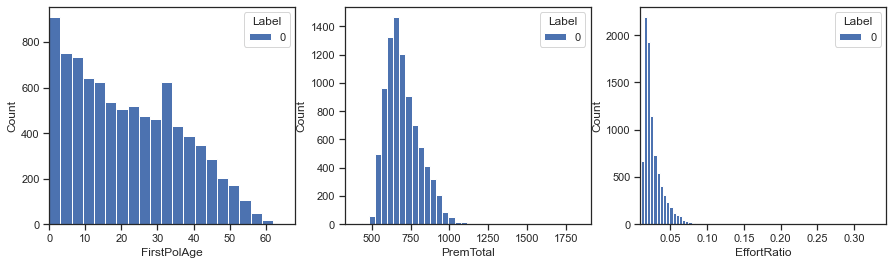

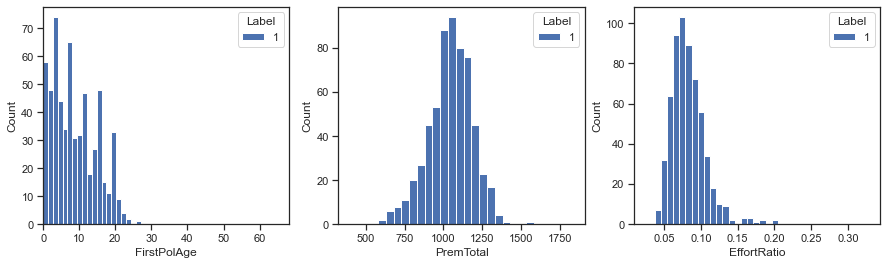

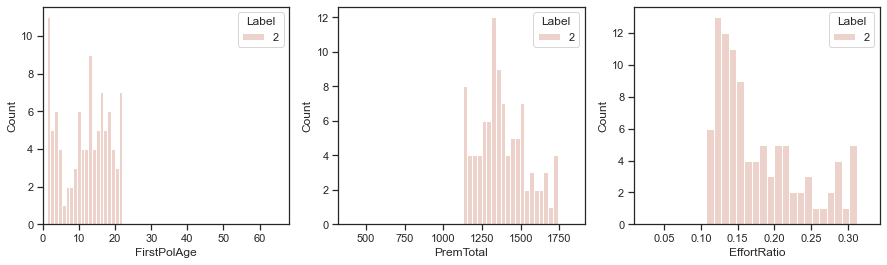

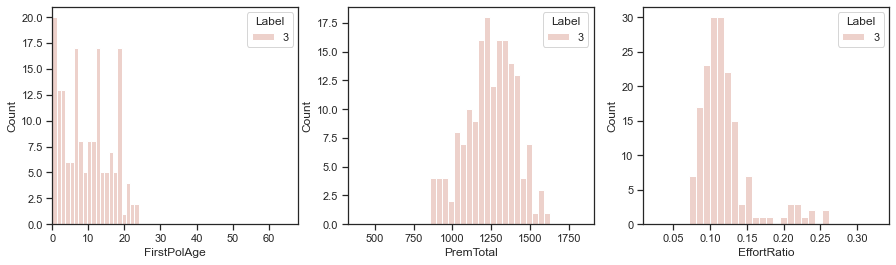

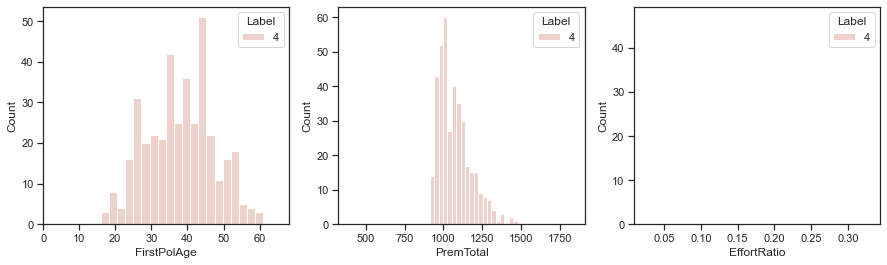

In [498]:
visualize_clustering(df, df.Label, ["FirstPolAge", "PremTotal", "EffortRatio"])

<a class="anchor" id="clustering-product"></a>

<h3><right>Product clustering</right></h3>

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    hierarchy.dendrogram(linkage_matrix, **kwargs)

    return

In [ ]:
df_product = df[[
    "Motor",
    "MotorRatio",
    "House",
    "HouseRatio",
    "Health",
    "HealthRatio",
    "Life",
    "LifeRatio",
    "Work",
    "WorkRatio",
]]

# potentially relevant features to perform customer segmentation based on product
df_product_raw = df_transformed[[
    "Motor",
    "House",
    "Health",
    "Life",
    "Work"
]]

df_product_ratios = df_transformed[[
    "MotorRatio",
    "HouseRatio",
    "HealthRatio",
    "LifeRatio",
    "WorkRatio"
]]

raw_features = ["Motor", "House", "Health", "Life", "Work"]
ratio_features = ["MotorRatio", "HouseRatio", "HealthRatio", "LifeRatio", "WorkRatio"]

corr_heatmap(df_product_raw, 0.2, "pearson")

#### 3.3.1. KMeans

In [ ]:
## non-ratios premiums

# scale data
minmax_scaler, km_product_minmax = data_scaler(df_product_raw, "minmax")
standard_scaler, km_product_standard = data_scaler(df_product_raw, "standard")
robust_scaler, km_product_robust = data_scaler(df_product_raw, "robust")

# elbow plot (suggests 4-8 clusters)
# plot_elbow(km_product_robust, 20, "kmeans")

# get cluster centroids and labels
km_product_centroids, km_product_labels = kmeans_clustering(km_product_standard, 4)

# cluster overview
df["Label"] = km_product_labels
evaluate_clustering(km_product_standard, df.Label)
summarise_clustering(df_product[raw_features], df.Label, "Motor")

Silhouette score: 0.25
Davies-Bouldin score: 1.34
Calinski-Harabasz score: 5154.16
Cluster sizes:
           obs     %
Cluster            
0        1861  18.5
1        2596  25.9
2        3282  32.7
3        2299  22.9


Motor       House      Health        Life       Work
Cluster                                                           
0        132.507378  502.423912  158.244567  100.757114  97.636454
3        191.804793  214.063963  265.276172   45.047569  43.655876
2        334.675259  145.893723  167.311304   28.928623  29.052566
1        471.027423   38.826194   90.721826    8.267292   8.311040

In [ ]:
r2_variables(df[["Motor", "House", "Health", "Life", "Work", "Label"]], 'Label').drop("Label")

Motor     0.847213
House     0.508242
Health    0.674865
Life      0.472997
Work      0.466265
dtype: float64

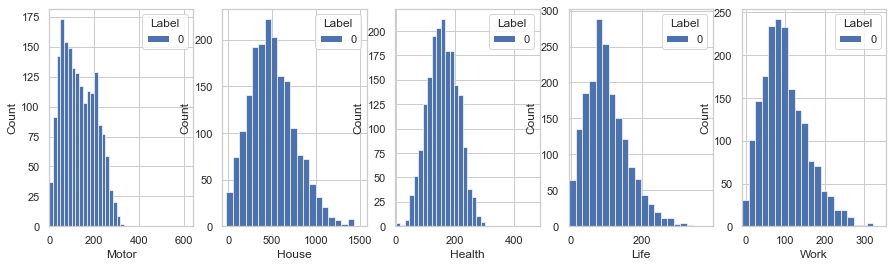

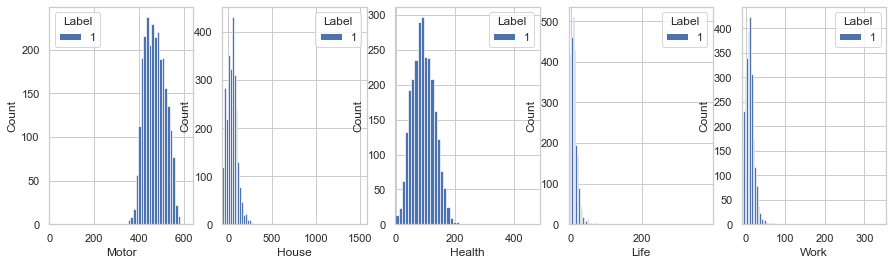

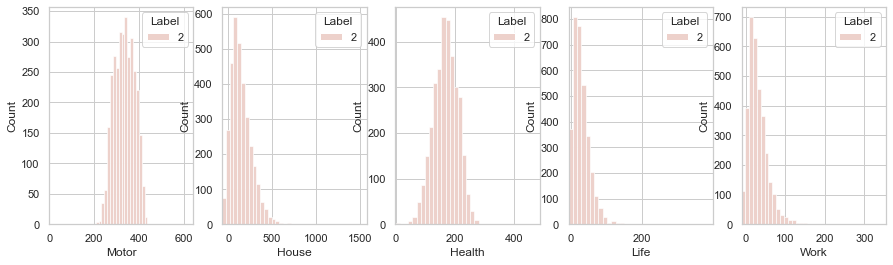

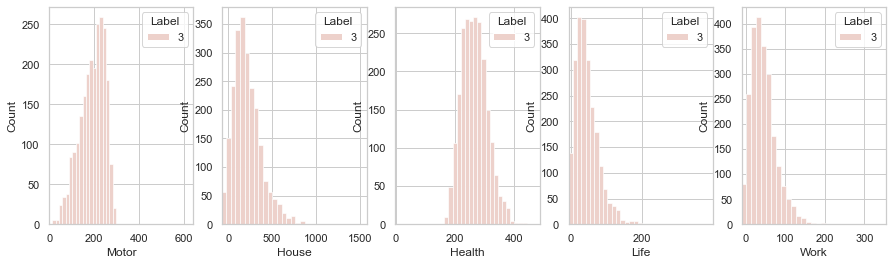

In [ ]:
visualize_clustering(df_product[raw_features], df.Label, raw_features)

In [ ]:
## ratios premiums

# scale data
minmax_scaler, km_product_minmax = data_scaler(df_product_ratios, "minmax")
standard_scaler, km_product_standard = data_scaler(df_product_ratios, "standard")
robust_scaler, km_product_robust = data_scaler(df_product_ratios, "robust")

# elbow plot (suggests 4-8 clusters)
# plot_elbow(km_product_minmax, 20, "kmeans")

# get cluster centroids and labels
km_product_centroids, km_product_labels = kmeans_clustering(km_product_minmax, 4)

# cluster overview
df["Label"] = km_product_labels
evaluate_clustering(km_product_minmax, df.Label)
summarise_clustering(df_product[ratio_features], df.Label, "MotorRatio")

Silhouette score: 0.27
Davies-Bouldin score: 1.28
Calinski-Harabasz score: 5803.83
Cluster sizes:
           obs     %
Cluster            
0        2180  21.7
1        2280  22.7
2        3070  30.6
3        2508  25.0


MotorRatio  HouseRatio  HealthRatio  LifeRatio  WorkRatio
Cluster                                                           
3          0.171814    0.488424     0.179646   0.081176   0.078940
0          0.294605    0.177544     0.371353   0.079794   0.076704
2          0.513922    0.175801     0.239419   0.035401   0.035457
1          0.793146    0.036005     0.144348   0.013177   0.013324

In [ ]:
r2_variables(df[["Motor", "House", "Health", "Life", "Work", "Label"]], 'Label').drop("Label")

Motor     0.803391
House     0.671527
Health    0.573883
Life      0.344852
Work      0.342382
dtype: float64

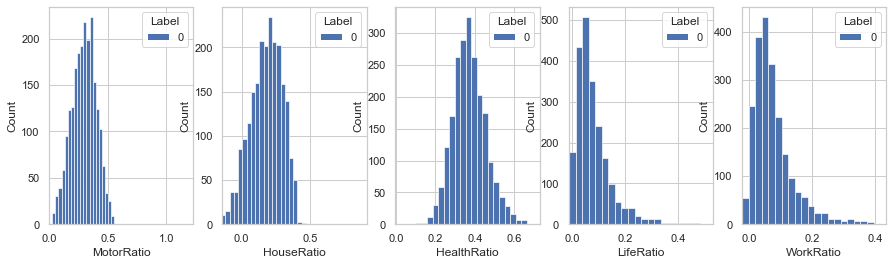

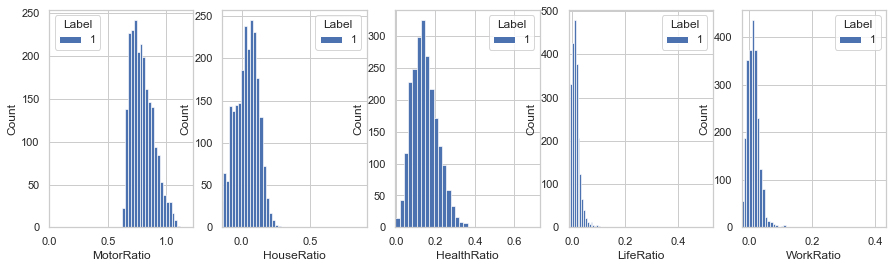

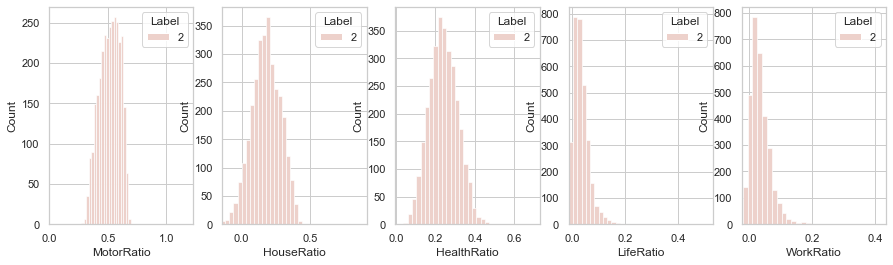

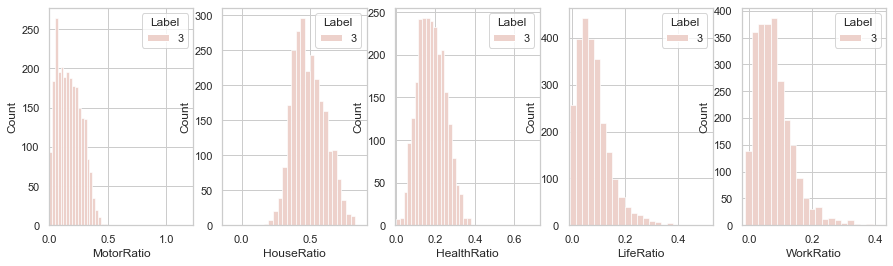

In [ ]:
visualize_clustering(df_product[ratio_features], df.Label, ratio_features)

#### 3.3.2. KMeans + Hierarchical

Silhouette score: 0.26
Davies-Bouldin score: 1.59
Calinski-Harabasz score: 3591.13
Cluster sizes:
           obs     %
Cluster            
0        3634  36.2
1        4862  48.4
2        1045  10.4
3         497   5.0


Motor       House      Health        Life        Work
Cluster                                                            
3         74.184547  556.367304  131.568753  113.127706  160.510584
2        121.983627  578.500718  205.283474   86.839665   59.271014
0        228.617771  210.743010  214.118192   53.688819   50.224444
1        414.152046   74.017287  129.777090   13.451643   15.377351

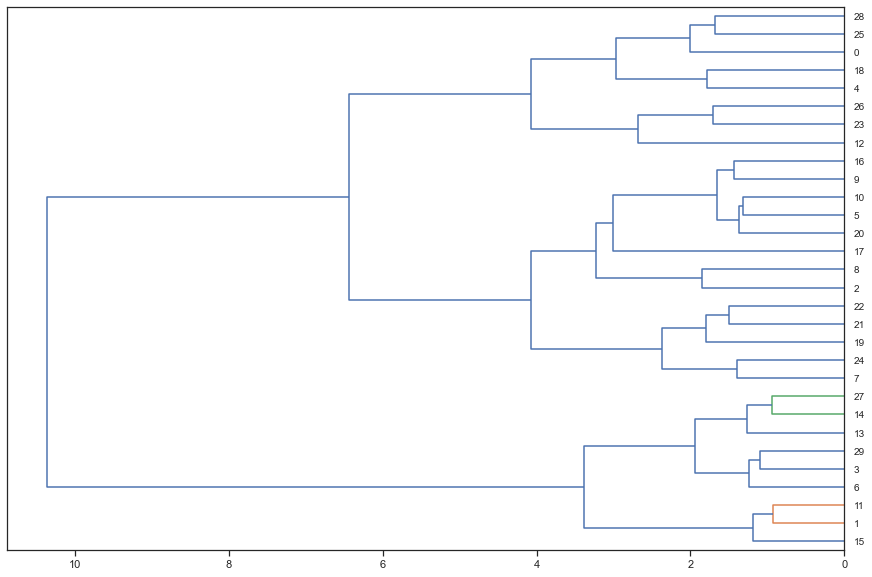

In [460]:
## non-ratio premiums

# scale data
minmax_scaler, km_product_minmax = data_scaler(df_product_raw, "minmax")
standard_scaler, km_product_standard = data_scaler(df_product_raw, "standard")
robust_scaler, km_product_robust = data_scaler(df_product_raw, "robust")

# get cluster centroids and labels
km_product_centroids, km_product_labels = kmeans_clustering(km_product_standard, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_product_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_product_linkage = hierarchy.linkage(km_product_centroids, method = "ward")
hierarchy.dendrogram(
    km_product_linkage,
    orientation = "left",
    color_threshold = 1.0
)

# hierarchical clustering of the centroids obtained
hc_product_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(km_product_centroids)
hc_product_labels = pd.Series(hc_product_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_product_centroids = pd.DataFrame(standard_scaler.inverse_transform(km_product_centroids), columns = raw_features)
km_product_centroids = pd.concat([km_product_centroids, hc_product_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_product_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_product_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_product_standard, df.Label)
summarise_clustering(df_product[raw_features], df.Label, "Motor")

In [461]:
r2_variables(df[["Motor", "House", "Health", "Life", "Work", "Label"]], 'Label').drop("Label")

Motor     0.747734
House     0.595870
Health    0.305455
Life      0.430820
Work      0.553339
dtype: float64

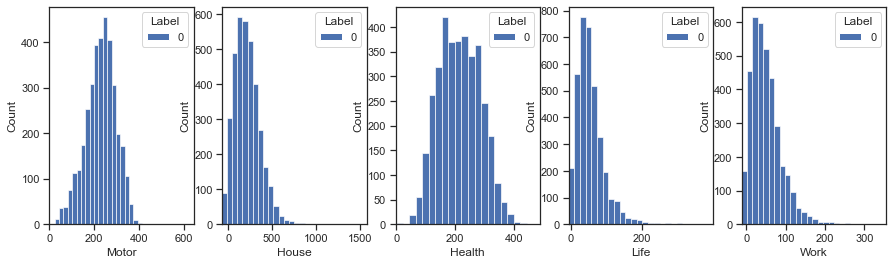

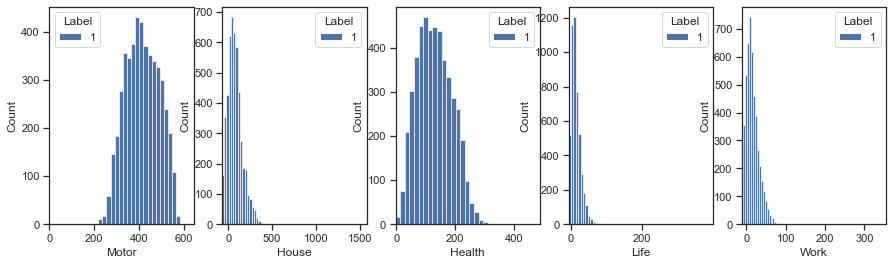

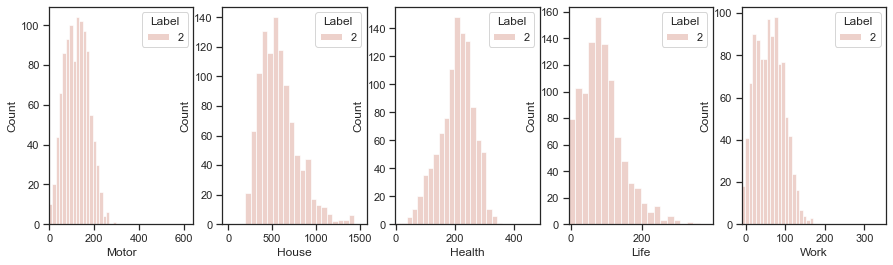

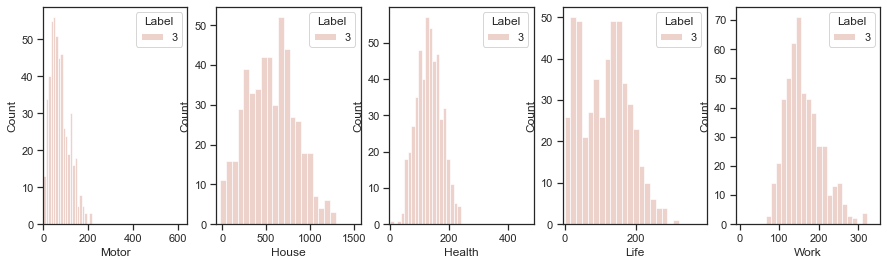

In [ ]:
visualize_clustering(df_product[raw_features], df.Label, raw_features)

Silhouette score: 0.19
Davies-Bouldin score: 1.56
Calinski-Harabasz score: 3424.3
Cluster sizes:
           obs     %
Cluster            
0        2158  21.5
1        3295  32.8
2        2194  21.9
3        2391  23.8


MotorRatio  HouseRatio  HealthRatio  LifeRatio  WorkRatio
Cluster                                                           
2          0.172628    0.500481     0.173444   0.079732   0.073714
0          0.290772    0.188333     0.334268   0.092409   0.094219
1          0.480131    0.192076     0.261818   0.034199   0.031776
3          0.782517    0.040338     0.150419   0.012224   0.014502

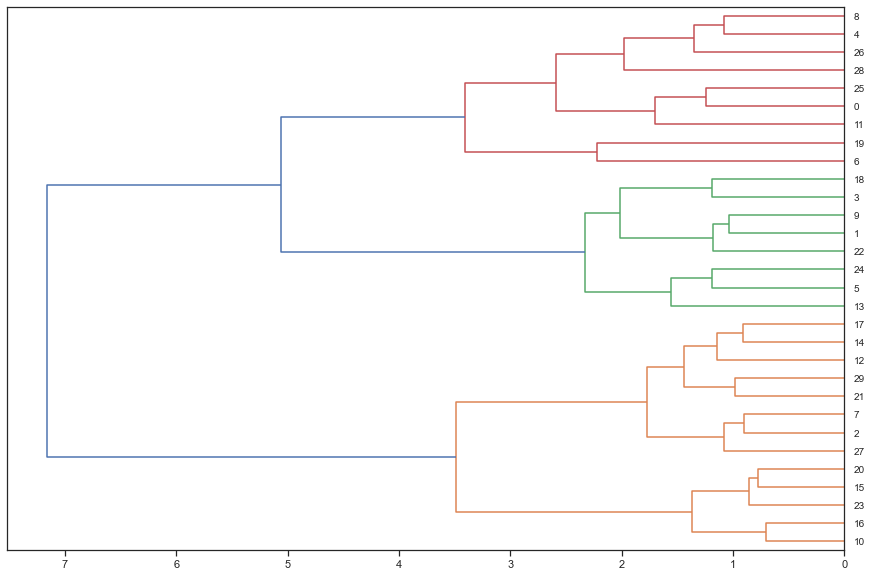

In [ ]:
## ratio premiums

# scale data
minmax_scaler, km_product_minmax = data_scaler(df_product_ratios, "minmax")
standard_scaler, km_product_standard = data_scaler(df_product_ratios, "standard")
robust_scaler, km_product_robust = data_scaler(df_product_ratios, "robust")

# get cluster centroids and labels
km_product_centroids, km_product_labels = kmeans_clustering(km_product_robust, 30)

# add labels obtained with KMeans to main df
df["Label"] = km_product_labels

# plot dendrogram with centroid clusters
sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
km_product_linkage = hierarchy.linkage(km_product_centroids, method = "ward")
hierarchy.dendrogram(
    km_product_linkage,
    orientation = "left",
    color_threshold = 3.5
)

# hierarchical clustering of the centroids obtained
hc_product_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(km_product_centroids)
hc_product_labels = pd.Series(hc_product_clusters.labels_, name = "hc_label")

# obtain dataframe with centroids (pre-scaling) and labels
km_product_centroids = pd.DataFrame(minmax_scaler.inverse_transform(km_product_centroids), columns = raw_features)
km_product_centroids = pd.concat([km_product_centroids, hc_product_labels], axis = 1)

# iterate through labels in df and replace with label from AgglomerativeClustering
label_col_index = df.columns.get_loc("Label")
hclabel_col_index = km_product_centroids.columns.get_loc("hc_label")
for i in np.arange(0, len(df)):
    df.iloc[i, label_col_index] = km_product_centroids.iloc[df.iloc[i, label_col_index], hclabel_col_index]

# cluster overview
evaluate_clustering(km_product_robust, df.Label)
summarise_clustering(df_product[ratio_features], df.Label, "MotorRatio")

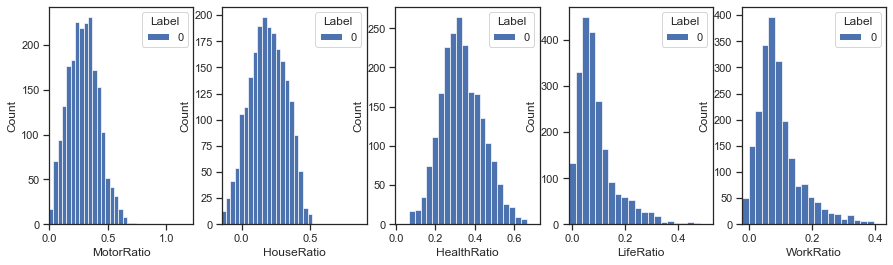

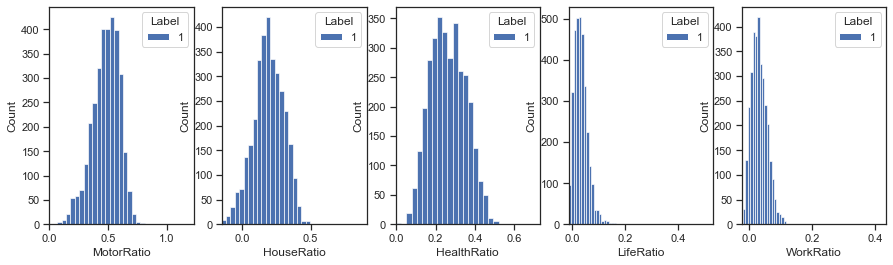

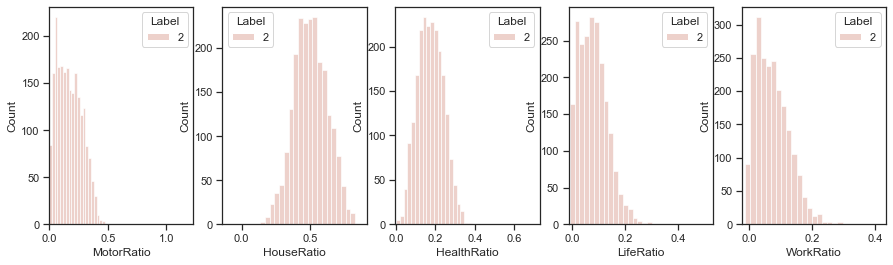

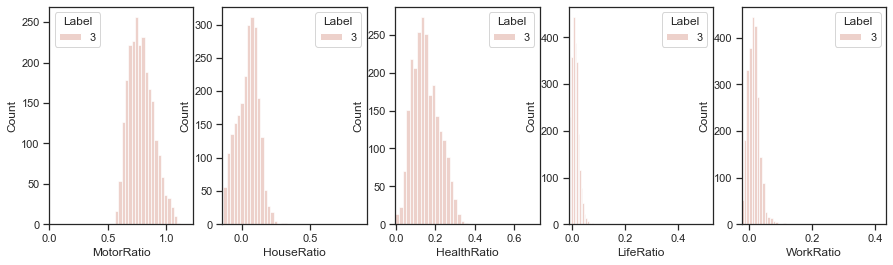

In [ ]:
visualize_clustering(df_product[ratio_features], df.Label, ratio_features)

#### 3.3.3. Hierarchical

Silhouette score: 0.19
Davies-Bouldin score: 1.69
Calinski-Harabasz score: 3620.49
Cluster sizes:
           obs     %
Cluster            
0        4297  42.8
1        3212  32.0
2         809   8.1
3        1720  17.1


Motor       House      Health        Life       Work
Cluster                                                           
2         98.201965  602.584858  145.204561  129.073857  96.236897
1        194.656803  260.099798  212.865760   61.959645  67.561192
3        271.931145  224.043227  225.591692   22.533297  23.107279
0        427.354487   69.460996  116.308960   15.193526  14.983840

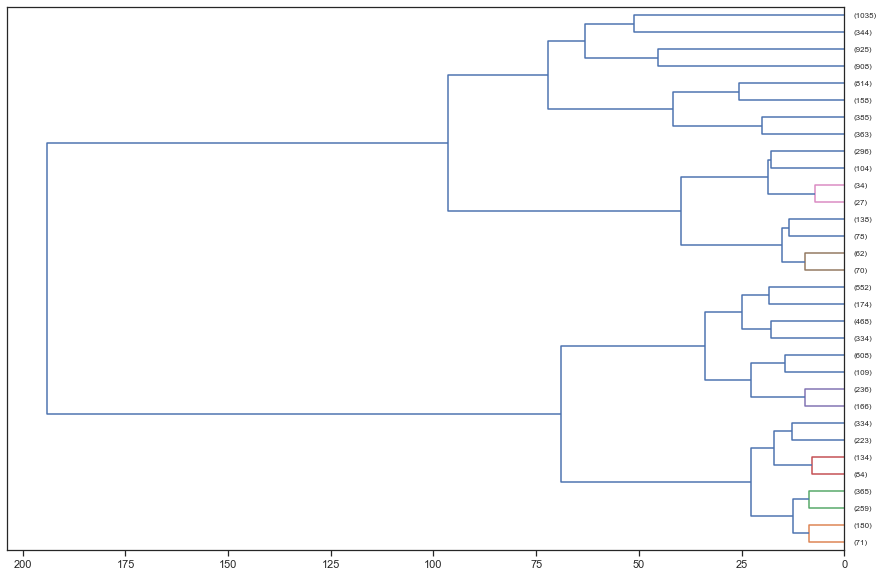

In [458]:
## non-ratio premiums

# scale data
minmax_scaler, hc_product_minmax = data_scaler(df_product_raw, "minmax")
standard_scaler, hc_product_standard = data_scaler(df_product_raw, "standard")
robust_scaler, hc_product_robust = data_scaler(df_product_raw, "robust")

hc_product_distances, hc_product_labels, hc_product_linkage = hierarchical_clustering(
    hc_product_standard, 
    n_clusters = None, 
    threshold = 0, 
    affinity = "euclidean", 
    linkage = "ward"
)

sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
hierarchy.dendrogram(
    hc_product_linkage,
    orientation = "left",
    p = 4,
    truncate_mode = "level",
    color_threshold = 10
)

# perform AgglomerativeClustering
hc_product_clusters = AgglomerativeClustering(n_clusters = 4, affinity = "euclidean", linkage = "ward").fit(hc_product_standard)
hc_product_labels = hc_product_clusters.labels_

# overview of the clusters
df["Label"] = hc_product_labels
evaluate_clustering(hc_product_standard, df.Label)
summarise_clustering(df_product[raw_features], df.Label, "Motor")

In [459]:
r2_variables(df[["Motor", "House", "Health", "Life", "Work", "Label"]], 'Label').drop("Label")

Motor     0.744038
House     0.445109
Health    0.433946
Life      0.529707
Work      0.413894
dtype: float64

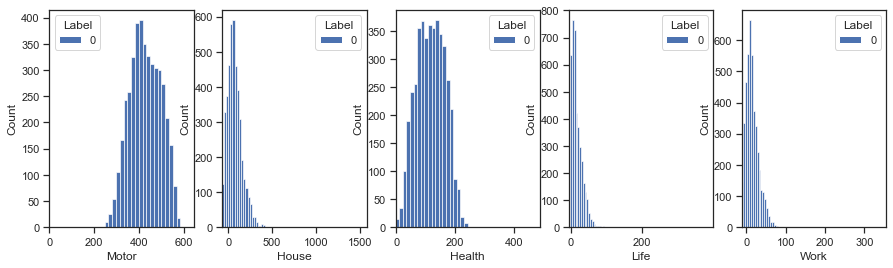

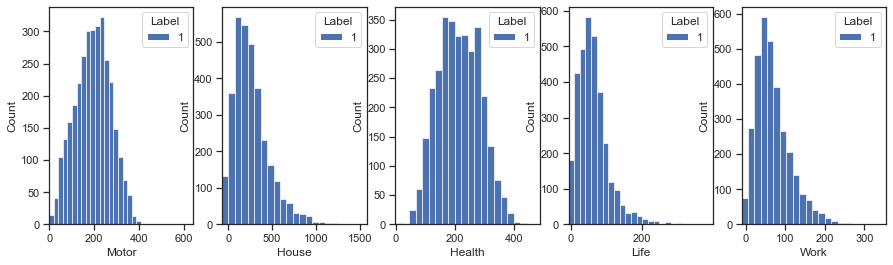

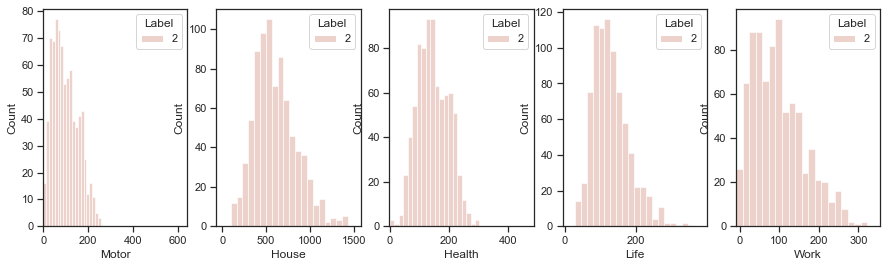

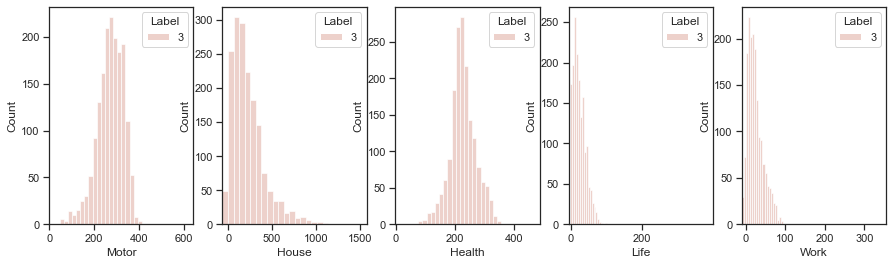

In [ ]:
visualize_clustering(df_product[raw_features], df.Label, raw_features)

Silhouette score: 0.18
Davies-Bouldin score: 1.43
Calinski-Harabasz score: 3897.47
Cluster sizes:
           obs     %
Cluster            
0        2712  27.0
1        2634  26.2
2        1233  12.3
3        1818  18.1
4        1060  10.6
5         581   5.8


MotorRatio  HouseRatio  HealthRatio  LifeRatio  WorkRatio
Cluster                                                           
5          0.124219    0.403846     0.173605   0.130872   0.167458
2          0.141128    0.556885     0.162397   0.081197   0.058393
0          0.311933    0.202775     0.348331   0.066474   0.070488
4          0.340562    0.368684     0.196478   0.053150   0.041126
1          0.575980    0.121325     0.241179   0.031394   0.030122
3          0.819026    0.028736     0.129221   0.011444   0.011573

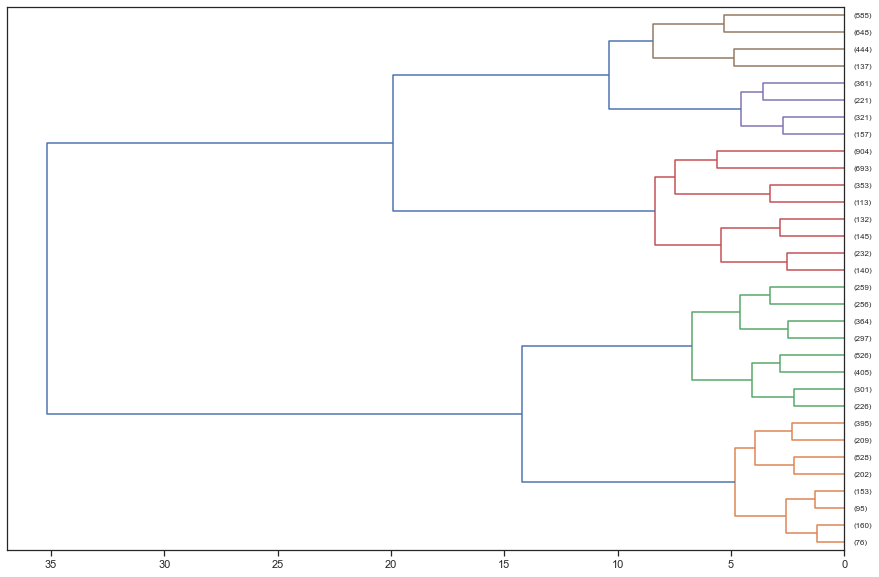

In [ ]:
## ratio premiums

# scale data
minmax_scaler, hc_product_minmax = data_scaler(df_product_ratios, "minmax")
standard_scaler, hc_product_standard = data_scaler(df_product_ratios, "standard")
robust_scaler, hc_product_robust = data_scaler(df_product_ratios, "robust")

hc_product_distances, hc_product_labels, hc_product_linkage = hierarchical_clustering(
    hc_product_minmax, 
    n_clusters = None, 
    threshold = 0, 
    affinity = "euclidean", 
    linkage = "ward"
)

sns.set(style = "ticks")
plt.subplots(figsize = (15, 10))
hierarchy.dendrogram(
    hc_product_linkage,
    orientation = "left",
    p = 4,
    truncate_mode = "level",
    color_threshold = 10
)

# perform AgglomerativeClustering
hc_product_clusters = AgglomerativeClustering(n_clusters = 6, affinity = "euclidean", linkage = "ward").fit(hc_product_minmax)
hc_product_labels = hc_product_clusters.labels_

# overview of the clusters
df["Label"] = hc_product_labels
evaluate_clustering(hc_product_minmax, df.Label)
summarise_clustering(df_product[ratio_features], df.Label, "MotorRatio")

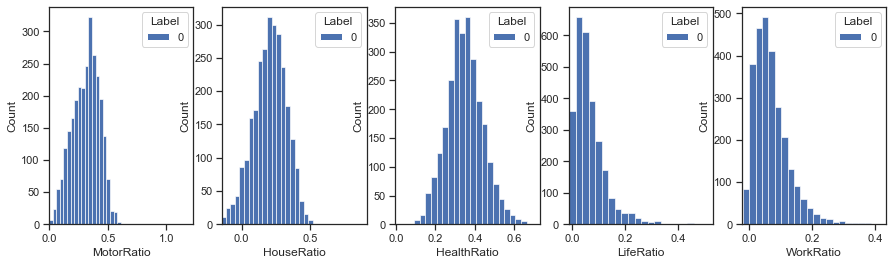

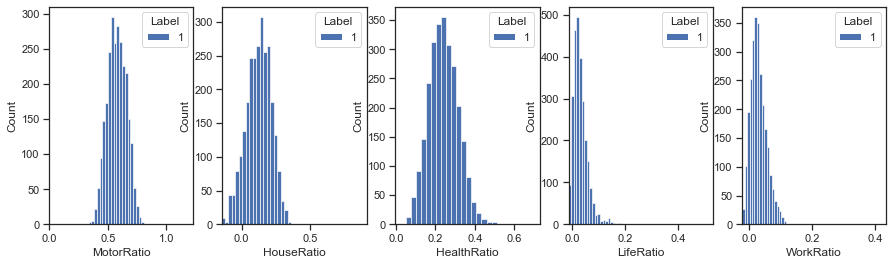

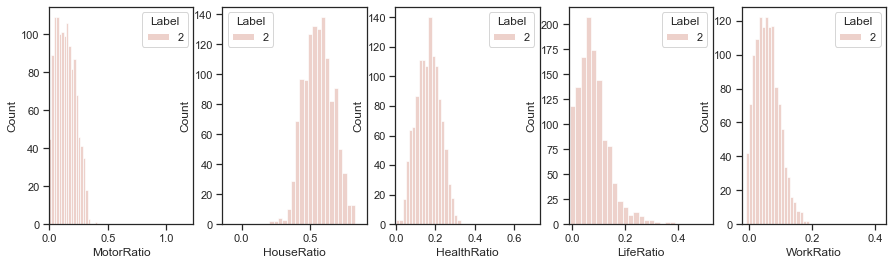

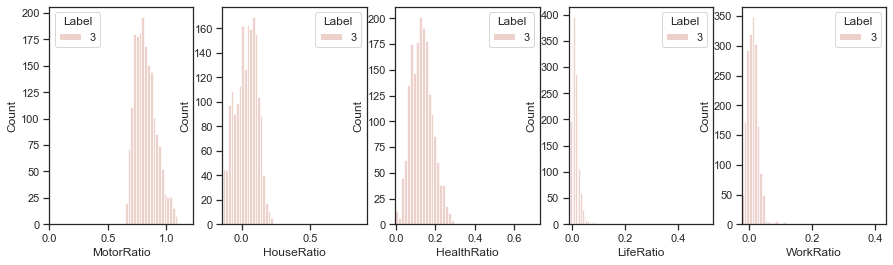

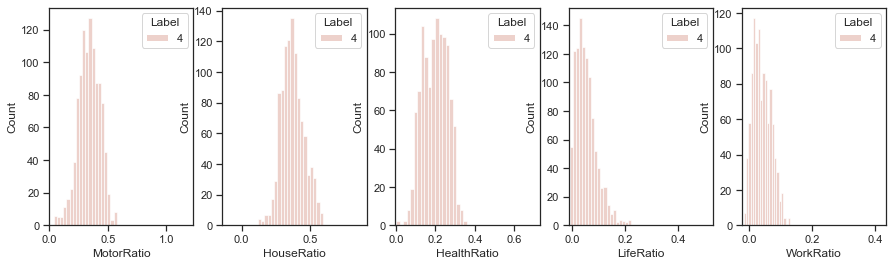

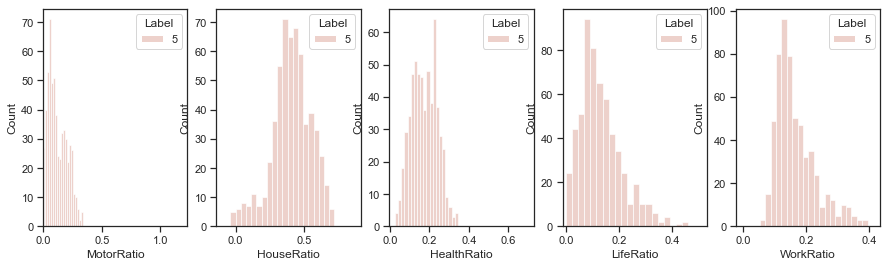

In [ ]:
visualize_clustering(df_product[ratio_features], df.Label, ratio_features)

#### 3.3.4. Birch

In [455]:
## non-ratio premiums

# scale data
minmax_scaler, birch_product_minmax = data_scaler(df_product_raw, "minmax")
standard_scaler, birch_product_standard = data_scaler(df_product_raw, "standard")
robust_scaler, birch_product_robust = data_scaler(df_product_raw, "robust")

# model and labels
# for threshold in np.arange(0.1, 1, 0.1):
#     birch_product_clusters = Birch(threshold = threshold).fit(birch_product_minmax)
#     birch_product_labels = birch_product_clusters.labels_
#     print(threshold, set(birch_product_labels))

birch_product_clusters = Birch(threshold = 0.3).fit(birch_product_standard)
birch_product_labels = birch_product_clusters.labels_

# overview of the clusters
df["Label"] = birch_product_labels
evaluate_clustering(birch_product_standard, df.Label)
summarise_clustering(df_product[raw_features], df.Label, "Motor")

Silhouette score: 0.26
Davies-Bouldin score: 1.46
Calinski-Harabasz score: 4386.4
Cluster sizes:
           obs     %
Cluster            
0        2671  26.6
1        5454  54.3
2        1913  19.1


Motor       House      Health       Life       Work
Cluster                                                          
0        164.456185  445.410389  170.822580  84.427600  80.308136
2        202.309054  151.825771  262.262279  46.821704  46.690695
1        400.158993   96.557774  134.033328  16.942233  17.449569

In [457]:
r2_variables(df[["Motor", "House", "Health", "Life", "Work", "Label"]], 'Label').drop("Label")

Motor     0.650284
House     0.458910
Health    0.420231
Life      0.392876
Work      0.364317
dtype: float64

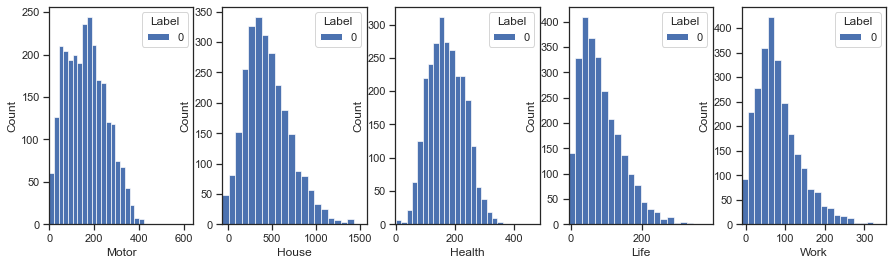

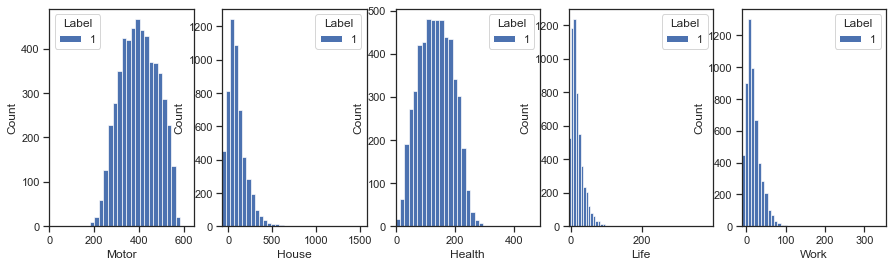

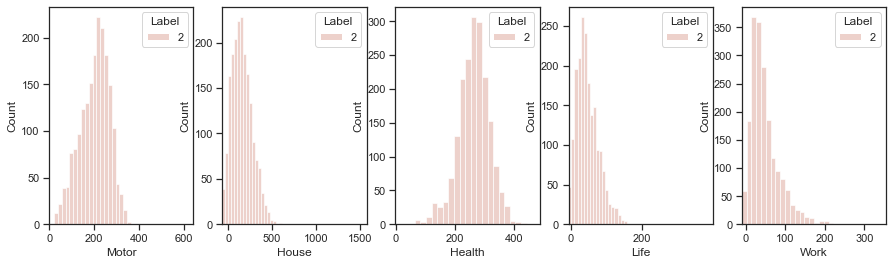

In [456]:
visualize_clustering(df_product[raw_features], df.Label, raw_features)

In [ ]:
## ratio premiums

# scale data
minmax_scaler, birch_product_minmax = data_scaler(df_product_ratios, "minmax")
standard_scaler, birch_product_standard = data_scaler(df_product_ratios, "standard")
robust_scaler, birch_product_robust = data_scaler(df_product_ratios, "robust")

# model and labels
# for threshold in np.arange(0.1, 1, 0.1):
#     birch_product_clusters = Birch(threshold = threshold).fit(birch_product_minmax)
#     birch_product_labels = birch_product_clusters.labels_
#     print(threshold, set(birch_product_labels))

birch_product_clusters = Birch(threshold = 0.2).fit(birch_product_minmax)
birch_product_labels = birch_product_clusters.labels_

# overview of the clusters
df["Label"] = birch_product_labels
evaluate_clustering(birch_product_minmax, df.Label)
summarise_clustering(df_product[ratio_features], df.Label, "MotorRatio")

Silhouette score: 0.26
Davies-Bouldin score: 1.2
Calinski-Harabasz score: 2825.58
Cluster sizes:
           obs     %
Cluster            
0        7571  75.4
1         482   4.8
2        1985  19.8


MotorRatio  HouseRatio  HealthRatio  LifeRatio  WorkRatio
Cluster                                                           
2          0.148852    0.506259     0.168762   0.087880   0.088247
1          0.212059    0.175118     0.343094   0.173417   0.096311
0          0.536465    0.151167     0.240902   0.034109   0.037358

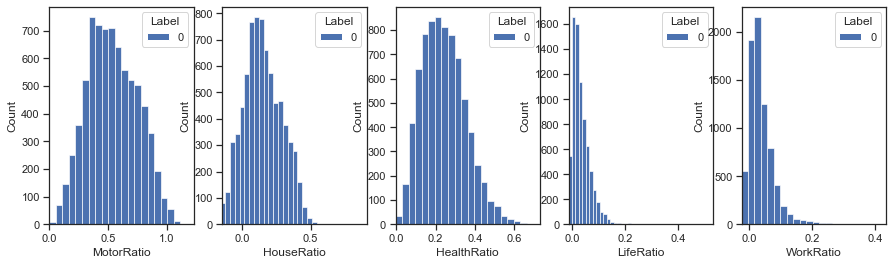

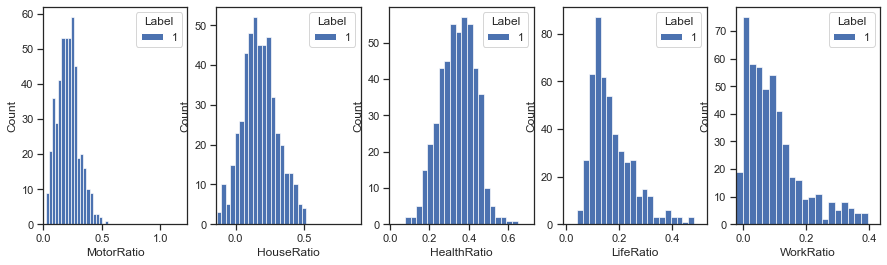

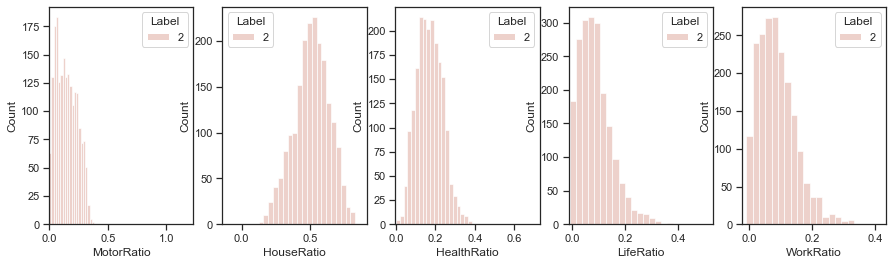

In [ ]:
visualize_clustering(df_product[ratio_features], df.Label, ratio_features)

#### 3.3.5. SOM + HC

In [451]:
## non-ratio premiums

som_product = df_product_raw.copy()
minmax_scaler, som_product_minmax = data_scaler(som_product, "minmax")
standard_scaler, som_product_standard = data_scaler(som_product, "standard")
robust_scaler, som_product_robust = data_scaler(som_product, "robust")

names = list(df_product_raw.columns)

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_product_standard.values,
    mapsize = (20, 20),
    # normalization = "var",
    initialization = "random",
    component_names = names,
    lattice = "rect",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

 Training...
 random_initialization took: 0.003000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  0.147000, quantization error: 1.151928

 epoch: 2 ---> elapsed time:  0.113000, quantization error: 1.713354

 epoch: 3 ---> elapsed time:  0.121000, quantization error: 1.257135

 epoch: 4 ---> elapsed time:  0.115000, quantization error: 1.198148

 epoch: 5 ---> elapsed time:  0.208000, quantization error: 1.187557

 epoch: 6 ---> elapsed time:  0.297000, quantization error: 1.173081

 epoch: 7 ---> elapsed time:  0.230000, quantization error: 1.158066

 epoch: 8 ---> elapsed time:  0.120000, quantization error: 1.140507

 epoch: 9 ---> elapsed time:  0.117000, quantization error: 1.125652

 epoch: 10 ---> elapsed time:  0.135000, quantization error: 1.117060

 epoch: 11 ---> elapsed time:  0.099000, quantization error: 1.112385

 epoch: 12 ---> elapsed time:  0.144000, quantization error: 1.109363

 epoch: 13 ---> 

ValueError: Number of rows must be a positive integer, not 2.0

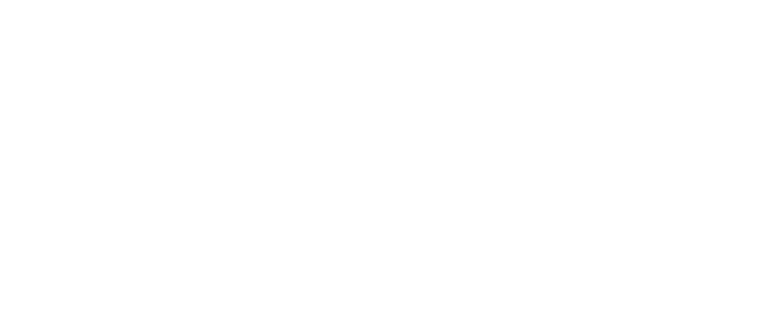

In [ ]:
# SOM results
final_clusters = pd.DataFrame(sm._data, columns = raw_features)
my_labels = pd.Series(sm._bmu[0], name = "Label")
final_clusters = pd.concat([final_clusters, my_labels], axis = 1)

# visualization 1
view2D  = View2DPacked(10, 10, "", text_size = 7)
view2D.show(sm, col_sz = 5, what = 'codebook',) #which_dim="all", denormalize=True)
plt.show()

# visualization 2
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=10, cmap="Blues", logaritmic=False)

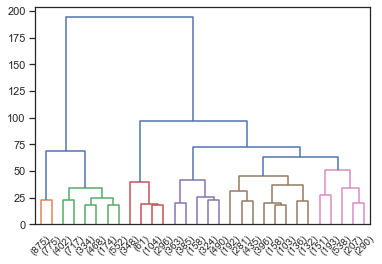

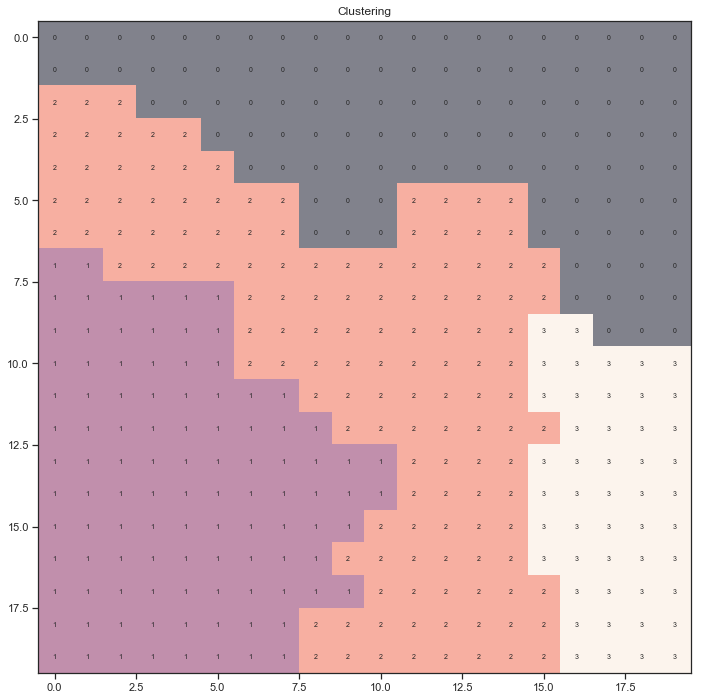

In [452]:
# apply HC to SOM results
som_product_linkage = hierarchy.linkage(sm._data, method = "ward")
hierarchy.dendrogram(
    som_product_linkage,
    truncate_mode = "lastp",
    p = 30,
    orientation = "top",
    color_threshold = 60
)

# k = 2 or k = 4 (from dendrogram)
hc_product_labels = AgglomerativeClustering(4).fit_predict(sm.codebook.matrix)
sm.cluster_labels = hc_product_labels

# visualize clusters
hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [453]:
# final SOM + HC clusters
db_final_clusters = AgglomerativeClustering(4).fit(sm._data)
db_final_labels = db_final_clusters.labels_

# overview of the clusters
df["Label"] = db_final_labels
evaluate_clustering(som_product_minmax, df.Label)
summarise_clustering(df_product[raw_features], df.Label)

Silhouette score: 0.2
Davies-Bouldin score: 1.65
Calinski-Harabasz score: 4293.54
Cluster sizes:
           obs     %
Cluster            
0        4297  42.8
1        3212  32.0
2         809   8.1
3        1720  17.1


Motor       House      Health        Life       Work
Cluster                                                           
0        427.354487   69.460996  116.308960   15.193526  14.983840
1        194.656803  260.099798  212.865760   61.959645  67.561192
2         98.201965  602.584858  145.204561  129.073857  96.236897
3        271.931145  224.043227  225.591692   22.533297  23.107279

In [454]:
r2_variables(df[["Motor", "House", "Health", "Life", "Work", "Label"]], 'Label').drop("Label")

Motor     0.744038
House     0.445109
Health    0.433946
Life      0.529707
Work      0.413894
dtype: float64

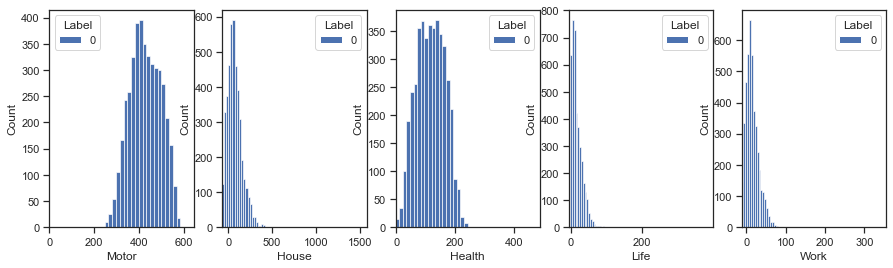

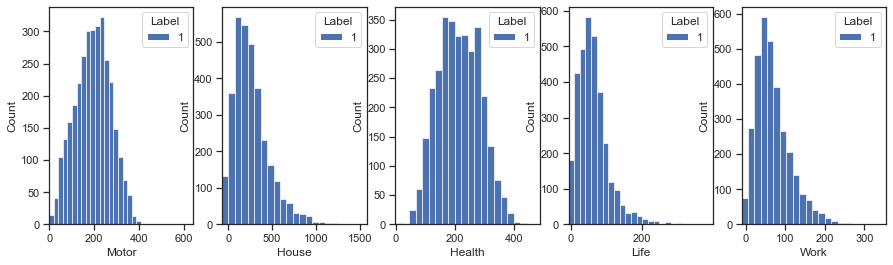

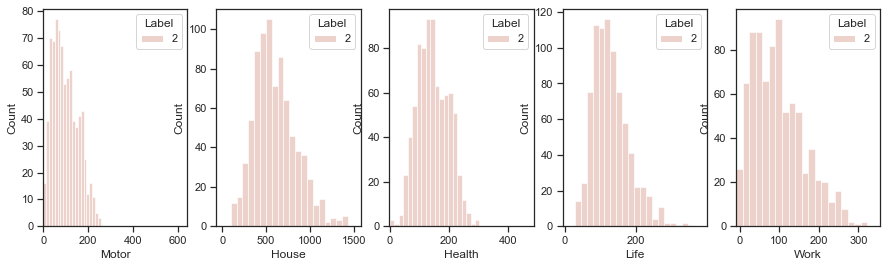

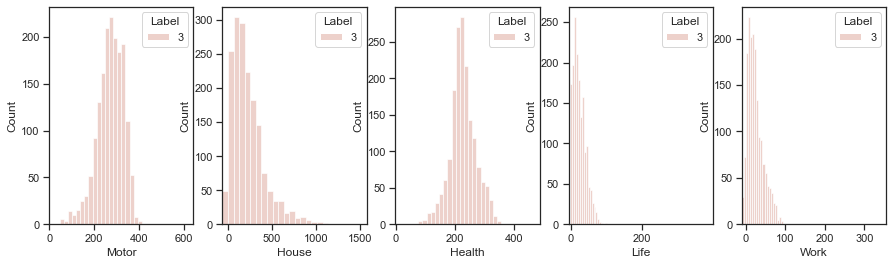

In [ ]:
visualize_clustering(df_product[raw_features], df.Label, raw_features)

In [ ]:
## ratio premiums

som_product = df_product_ratios.copy()
minmax_scaler, som_product_minmax = data_scaler(som_product, "minmax")
standard_scaler, som_product_standard = data_scaler(som_product, "standard")
robust_scaler, som_product_robust = data_scaler(som_product, "robust")

names = list(df_product_ratios.columns)

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_product_standard.values,
    mapsize = (20, 20),
    # normalization = "var",
    initialization = "random",
    component_names = names,
    lattice = "rect",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

 Training...
 random_initialization took: 0.001000 seconds
 Rough training...
 radius_ini: 7.000000 , radius_final: 1.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  0.106000, quantization error: 1.188949

 epoch: 2 ---> elapsed time:  0.098000, quantization error: 1.760581

 epoch: 3 ---> elapsed time:  0.121000, quantization error: 1.315124

 epoch: 4 ---> elapsed time:  0.100000, quantization error: 1.234111

 epoch: 5 ---> elapsed time:  0.100000, quantization error: 1.215018

 epoch: 6 ---> elapsed time:  0.094000, quantization error: 1.206226

 epoch: 7 ---> elapsed time:  0.088000, quantization error: 1.197809

 epoch: 8 ---> elapsed time:  0.091000, quantization error: 1.188920

 epoch: 9 ---> elapsed time:  0.104000, quantization error: 1.179373

 epoch: 10 ---> elapsed time:  0.107000, quantization error: 1.170613

 epoch: 11 ---> elapsed time:  0.102000, quantization error: 1.163464

 epoch: 12 ---> elapsed time:  0.084000, quantization error: 1.157321

 epoch: 13 ---> 

ValueError: Number of rows must be a positive integer, not 2.0

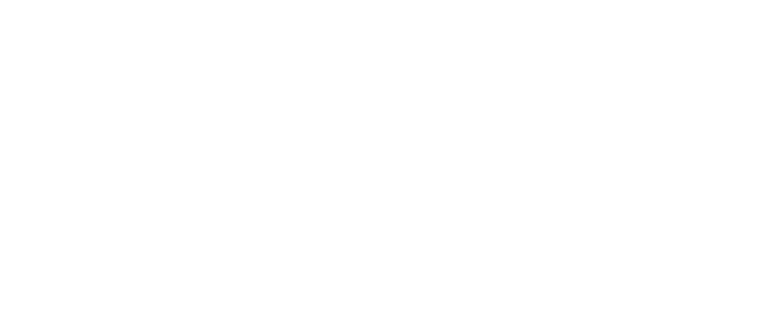

In [ ]:
# SOM results
final_clusters = pd.DataFrame(sm._data, columns = ratio_features)
my_labels = pd.Series(sm._bmu[0], name = "Label")
final_clusters = pd.concat([final_clusters, my_labels], axis = 1)

# visualization 1
view2D  = View2DPacked(10, 10, "", text_size = 7)
view2D.show(sm, col_sz = 5, what = 'codebook',)
plt.show()

# visualization 2
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=10, cmap="Blues", logaritmic=False)

In [ ]:
# apply HC to SOM results
som_product_linkage = hierarchy.linkage(sm._data, method = "ward")
hierarchy.dendrogram(
    som_product_linkage,
    truncate_mode = "lastp",
    p = 30,
    orientation = "top",
    color_threshold = 60
)

# k = 2 or k = 4 (from dendrogram)
hc_product_labels = AgglomerativeClustering(3).fit_predict(sm.codebook.matrix)
sm.cluster_labels = hc_product_labels

# visualize clusters
hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [ ]:
# final SOM + HC clusters
db_final_clusters = AgglomerativeClustering(3).fit(sm._data)
db_final_labels = db_final_clusters.labels_

# overview of the clusters
df["Label"] = db_final_labels
evaluate_clustering(som_product_standard, df.Label)
summarise_clustering(df_product[ratio_features], df.Label, sort_by = "MotorRatio")

In [ ]:
visualize_clustering(df_product[ratio_features], df.Label, ratio_features)

#### 3.3.6. SOM + KMeans

In [ ]:
## non-ratio premiums

som_product = df_product_raw.copy()
minmax_scaler, som_product_minmax = data_scaler(som_product, "minmax")
standard_scaler, som_product_standard = data_scaler(som_product, "standard")
robust_scaler, som_product_robust = data_scaler(som_product, "robust")

names = list(df_product_raw.columns)

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_product_standard.values,
    mapsize = (10, 10),
    # normalization = "var",
    initialization = "pca",
    component_names = names,
    lattice = "hexa",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

 Training...
 pca_linear_initialization took: 0.057000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.071000, quantization error: 0.978027

 epoch: 2 ---> elapsed time:  0.076000, quantization error: 1.514313

 epoch: 3 ---> elapsed time:  0.074000, quantization error: 1.377845

 epoch: 4 ---> elapsed time:  0.078000, quantization error: 1.367939

 epoch: 5 ---> elapsed time:  0.091000, quantization error: 1.362106

 epoch: 6 ---> elapsed time:  0.080000, quantization error: 1.357200

 epoch: 7 ---> elapsed time:  0.081000, quantization error: 1.352679

 epoch: 8 ---> elapsed time:  0.082000, quantization error: 1.348209

 epoch: 9 ---> elapsed time:  0.080000, quantization error: 1.343781

 epoch: 10 ---> elapsed time:  0.094000, quantization error: 1.339389

 epoch: 11 ---> elapsed time:  0.085000, quantization error: 1.335001

 epoch: 12 ---> elapsed time:  0.092000, quantization error: 1.330573

 epoch: 13 -

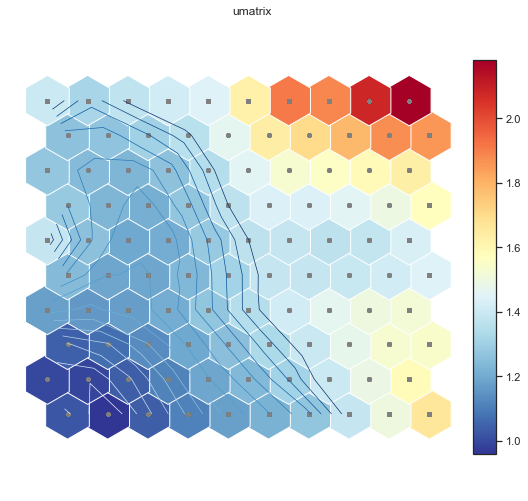

In [ ]:
# Here you have U-matrix
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=12, show_text=True)

UMAT = u.show(
    sm, 
    distance=10, 
    row_normalized=False,
    show_data=True, 
    contour=True, # Visualize isomorphic curves
    blob=False
)

np.flip(UMAT[1], axis=1); # U-matrix values - they match with the plot colors

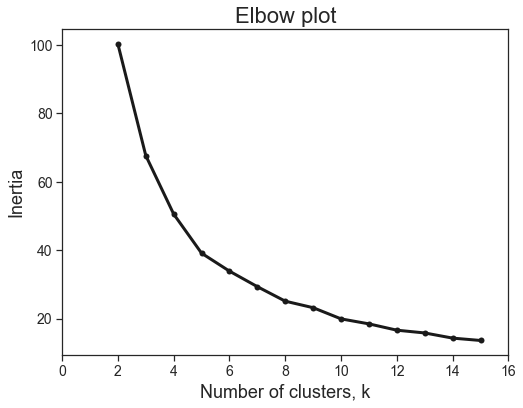

In [ ]:
# SOM + KMeans
plot_elbow(sm.codebook.matrix, 15, "kmeans")

ValueError: Number of rows must be a positive integer, not 2.0

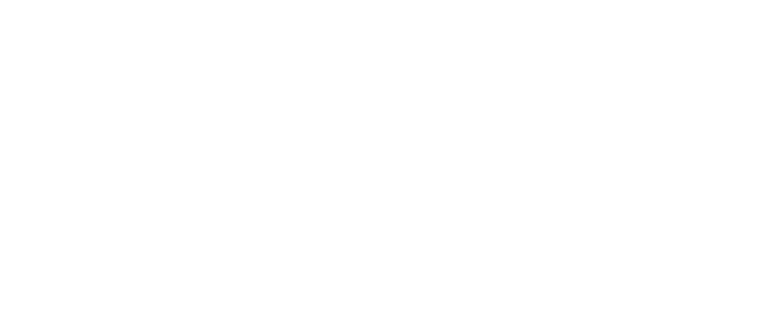

In [ ]:
# SOM results
final_clusters = pd.DataFrame(sm._data, columns = raw_features)
my_labels = pd.Series(sm._bmu[0], name = "Label")
final_clusters = pd.concat([final_clusters, my_labels], axis = 1)

# visualization 1
view2D  = View2DPacked(10, 10, "", text_size = 7)
view2D.show(sm, col_sz = 5, what = 'codebook',) #which_dim="all", denormalize=True)
plt.show()

# visualization 2
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=10, cmap="Blues", logaritmic=False)

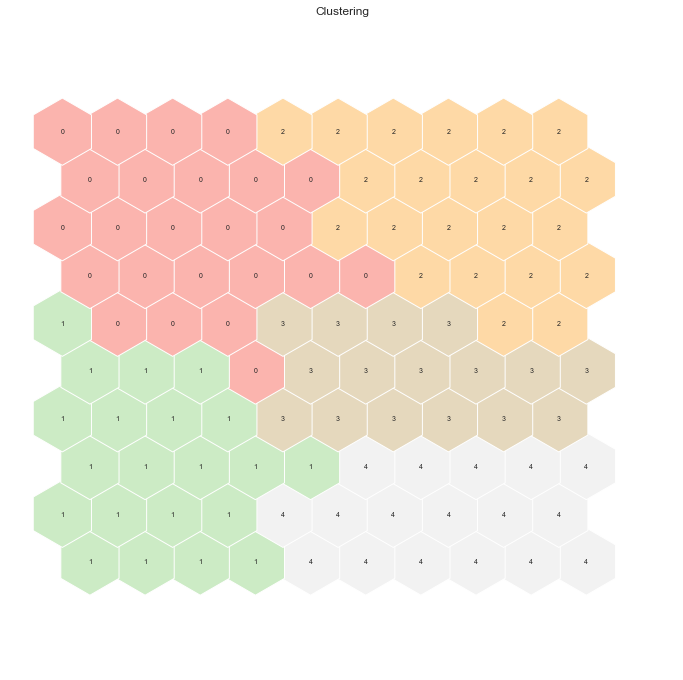

In [ ]:
kmeans = KMeans(n_clusters = 5, random_state = 15)
km_product_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = km_product_labels

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate = True, onlyzeros = False, labelsize = 7, cmap = "Pastel1")

plt.show()

In [ ]:
# final SOM + KMeans clusters
km_final_clusters = KMeans(5).fit(sm._data)
km_final_labels = km_final_clusters.labels_

df["Label"] = km_final_labels
evaluate_clustering(som_product_standard, df.Label)
summarise_clustering(df_product[raw_features], df.Label, "Motor")

Silhouette score: 0.23
Davies-Bouldin score: 1.41
Calinski-Harabasz score: 4447.91
Cluster sizes:
           obs     %
Cluster            
0        2453  24.4
1        2002  19.9
2        1788  17.8
3        1446  14.4
4        2349  23.4


Motor       House      Health        Life        Work
Cluster                                                            
3        105.435235  536.195228  160.461722  109.602248  107.116618
1        185.004670  208.534041  273.430799   44.654695   43.894775
2        278.545157  269.537444  154.915604   52.374038   49.859508
0        352.616351   97.289258  177.808496   18.980330   19.251488
4        478.033840   39.741592   83.611396    8.255385    8.451090

In [ ]:
r2_variables(df[["Motor", "House", "Health", "Life", "Work", "Label"]], 'Label').drop("Label")

Motor     0.870021
House     0.530256
Health    0.713979
Life      0.512417
Work      0.511758
dtype: float64

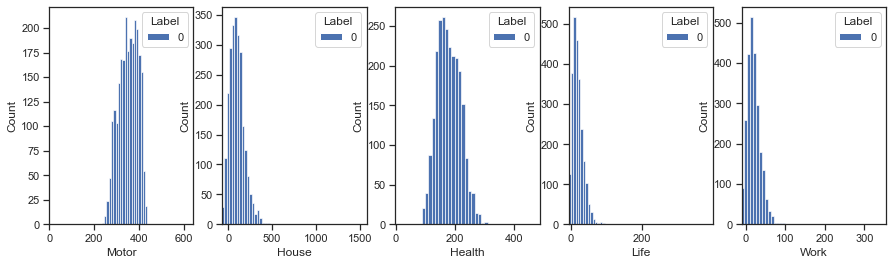

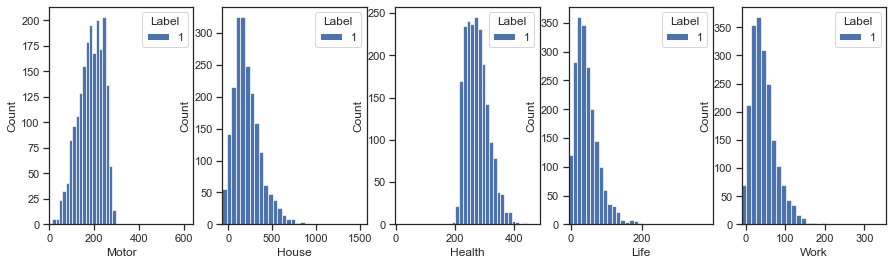

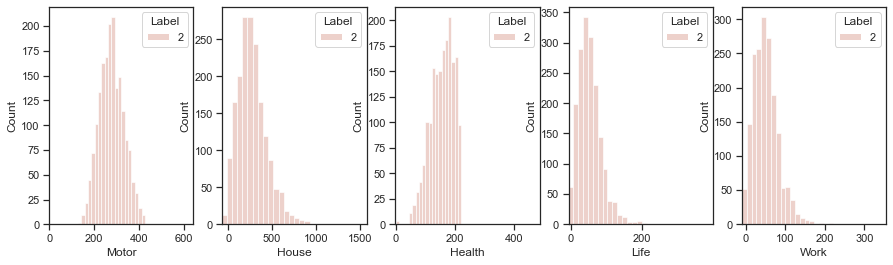

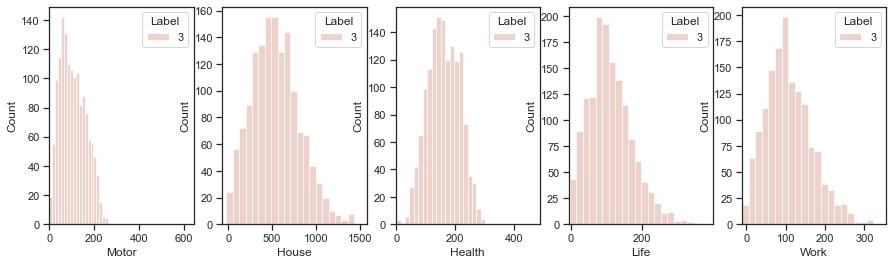

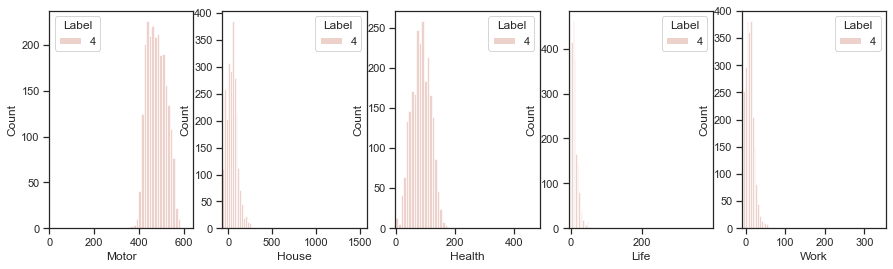

In [ ]:
visualize_clustering(df_product[raw_features], df.Label, raw_features)

#### Final Sociodemographic clustering solution

In [ ]:
# final sociodemographic clustering solution
df_sociodem = df[["Generation", "Age", "YearSal", "EducDeg", "Children"]]

# scale data
kp_sociodem = df_sociodem[["YearSal", "EducDeg", "Children"]]
minmax_scaler, kp_sociodem_minmax = data_scaler(kp_sociodem, "minmax")
standard_scaler, kp_sociodem_standard = data_scaler(kp_sociodem, "standard")

# # elbow plot
# plot_elbow(kp_sociodem_minmax, nmax_clusters = 10, algorithm = "kprototypes", cat_index = [1, 2])

# compute centroids and labels with k = 4
kp_sociodem_centroids, kp_sociodem_labels = kprototypes_clustering(kp_sociodem_minmax, k = 4, cat_index = [1, 2], init = "Huang")

# cluster overview
df["Label"] = kp_sociodem_labels
evaluate_clustering(kp_sociodem_minmax, kp_sociodem_labels)
summarise_clustering(kp_sociodem, df.Label, sort_by = "YearSal")

Silhouette score: 0.4
Davies-Bouldin score: 1.98
Calinski-Harabasz score: 5660.86
Cluster sizes:
           obs     %
Cluster            
0        3680  36.7
1        1133  11.3
2        2463  24.5
3        2762  27.5


YearSal   EducDeg  Children
Cluster                                  
1        19618.209562  1.431598  0.855252
3        25809.571071  2.055033  0.903331
0        27390.982350  3.066576  0.964130
2        43678.514860  2.610637  0.041007

In [ ]:
r2_variables(df[["YearSal", "EducDeg", "Children", "Label"]], 'Label').drop("Label")

YearSal     0.475524
EducDeg     0.488244
Children    0.707830
dtype: float64

In [ ]:
sociodem_labels = kp_sociodem_labels

#### Final Value clustering solution

In [ ]:
df_value = df_transformed[[
    "FirstPolAge",
    # "CustYears",
    "CMV",
    "ClaimsRate",
    "PremTotal",
    "EffortRatio"
]]

# scale data
som_value = df_value[["FirstPolAge", "PremTotal", "EffortRatio"]]
minmax_scaler, som_value_minmax = data_scaler(som_value, "minmax")
standard_scaler, som_value_standard = data_scaler(som_value, "standard")
robust_scaler, som_value_robust = data_scaler(som_value, "robust")

names = ["FirstPolAge", "PremTotal", "EffortRatio"]

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_value_standard.values,
    mapsize = (20, 20),
    # normalization = "var",
    initialization = "pca",
    # neighborhood = "gaussian",
    component_names = names,
    lattice = "hexa",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

 Training...
 pca_linear_initialization took: 0.025000 seconds
 Rough training...
 radius_ini: 3.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.105000, quantization error: 0.515076

 epoch: 2 ---> elapsed time:  0.085000, quantization error: 1.030437

 epoch: 3 ---> elapsed time:  0.079000, quantization error: 0.941759

 epoch: 4 ---> elapsed time:  0.089000, quantization error: 0.928155

 epoch: 5 ---> elapsed time:  0.084000, quantization error: 0.918518

 epoch: 6 ---> elapsed time:  0.087000, quantization error: 0.910466

 epoch: 7 ---> elapsed time:  0.082000, quantization error: 0.903184

 epoch: 8 ---> elapsed time:  0.084000, quantization error: 0.896358

 epoch: 9 ---> elapsed time:  0.079000, quantization error: 0.889506

 epoch: 10 ---> elapsed time:  0.078000, quantization error: 0.882607

 epoch: 11 ---> elapsed time:  0.080000, quantization error: 0.875789

 epoch: 12 ---> elapsed time:  0.079000, quantization error: 0.869018

 epoch: 13 -

In [ ]:
# SOM results
final_clusters = pd.DataFrame(sm._data, columns = ["FirstPolAge", "PremTotal", "EffortRatio"])
my_labels = pd.Series(sm._bmu[0], name = "Label")
final_clusters = pd.concat([final_clusters, my_labels], axis = 1)

# visualization 1
view2D  = View2DPacked(10, 10, "", text_size = 7)
view2D.show(sm, col_sz = 3, what = 'codebook',) #which_dim="all", denormalize=True)
plt.show()

# visualization 2
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=10, cmap="Blues", logaritmic=False)

ValueError: Number of rows must be a positive integer, not 2.0

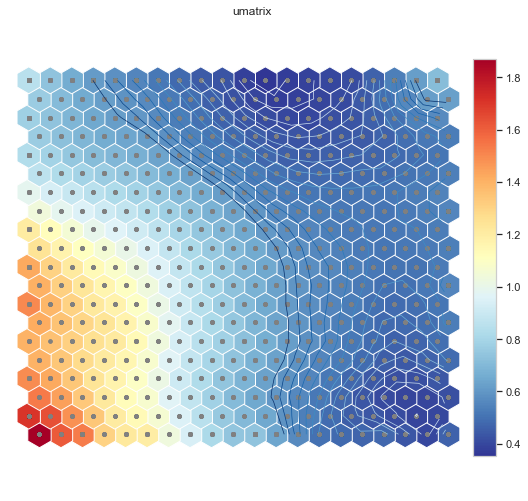

In [ ]:
# Here you have U-matrix
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=12, show_text=True)

UMAT = u.show(
    sm, 
    distance=10, 
    row_normalized=False,
    show_data=True, 
    contour=True, # Visualize isomorphic curves
    blob=False
)

np.flip(UMAT[1], axis=1); # U-matrix values - they match with the plot colors

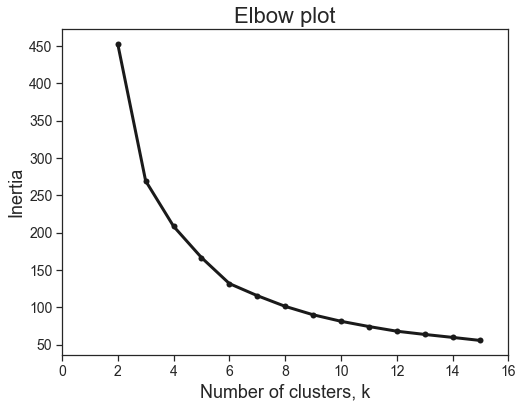

In [ ]:
# SOM + KMeans
plot_elbow(sm.codebook.matrix, 15, "kmeans")

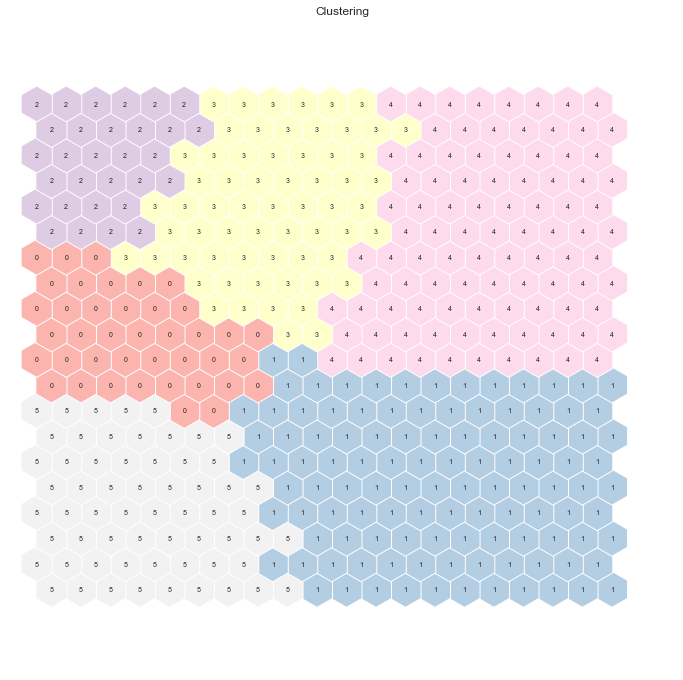

In [ ]:
kmeans = KMeans(n_clusters = 6, random_state = 15)
km_value_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = km_value_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate = True, onlyzeros = False, labelsize = 7, cmap = "Pastel1")

plt.show()

In [ ]:
# final SOM + KMeans clusters
km_final_clusters = KMeans(6).fit(sm._data)
km_final_labels = km_final_clusters.labels_

df["Label"] = km_final_labels
evaluate_clustering(som_value_standard, df.Label)
summarise_clustering(som_value, df.Label, "FirstPolAge")

Silhouette score: 0.33
Davies-Bouldin score: 0.91
Calinski-Harabasz score: 8064.79
Cluster sizes:
           obs     %
Cluster            
0         676   6.7
1        2439  24.3
2        1870  18.6
3        2480  24.7
4        1070  10.7
5        1503  15.0


FirstPolAge  PremTotal  EffortRatio
Cluster                                     
5           7.753160  31.145272     0.232043
3           7.870968  27.749138     0.178803
0           9.467456  35.844099     0.321182
1          23.976630  27.750354     0.150705
4          34.673832  32.649454     0.164194
2          42.649198  28.354708     0.138123

In [ ]:
r2_variables(df[["FirstPolAge", "PremTotal", "EffortRatio", "Label"]], 'Label').drop("Label")

FirstPolAge    0.840791
PremTotal      0.734107
EffortRatio    0.727088
dtype: float64

In [ ]:
value_labels = km_final_labels

#### Final Product clustering solution

In [ ]:
df_product = df[[
    "Motor",
    "MotorRatio",
    "House",
    "HouseRatio",
    "Health",
    "HealthRatio",
    "Life",
    "LifeRatio",
    "Work",
    "WorkRatio",
]]

# potentially relevant features to perform customer segmentation based on product
df_product_raw = df_transformed[[
    "Motor",
    "House",
    "Health",
    "Life",
    "Work"
]]

df_product_ratios = df_transformed[[
    "MotorRatio",
    "HouseRatio",
    "HealthRatio",
    "LifeRatio",
    "WorkRatio"
]]

raw_features = ["Motor", "House", "Health", "Life", "Work"]
ratio_features = ["MotorRatio", "HouseRatio", "HealthRatio", "LifeRatio", "WorkRatio"]

## non-ratio premiums
som_product = df_product_raw.copy()
minmax_scaler, som_product_minmax = data_scaler(som_product, "minmax")
standard_scaler, som_product_standard = data_scaler(som_product, "standard")
robust_scaler, som_product_robust = data_scaler(som_product, "robust")

names = list(df_product_raw.columns)

np.random.seed(15)

sm = sompy.SOMFactory().build(
    data = som_product_standard.values,
    mapsize = (10, 10),
    # normalization = "var",
    initialization = "pca",
    component_names = names,
    lattice = "hexa",
    training = "batch"
)

sm.train(
    n_job = 4,
    train_rough_len = 100,
    train_finetune_len = 100
)

 Training...
 pca_linear_initialization took: 0.007000 seconds
 Rough training...
 radius_ini: 2.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.030000, quantization error: 0.978027

 epoch: 2 ---> elapsed time:  0.031000, quantization error: 1.514313

 epoch: 3 ---> elapsed time:  0.030000, quantization error: 1.377845

 epoch: 4 ---> elapsed time:  0.022000, quantization error: 1.367939

 epoch: 5 ---> elapsed time:  0.022000, quantization error: 1.362106

 epoch: 6 ---> elapsed time:  0.023000, quantization error: 1.357200

 epoch: 7 ---> elapsed time:  0.026000, quantization error: 1.352679

 epoch: 8 ---> elapsed time:  0.021000, quantization error: 1.348209

 epoch: 9 ---> elapsed time:  0.021000, quantization error: 1.343781

 epoch: 10 ---> elapsed time:  0.019000, quantization error: 1.339389

 epoch: 11 ---> elapsed time:  0.020000, quantization error: 1.335001

 epoch: 12 ---> elapsed time:  0.020000, quantization error: 1.330573

 epoch: 13 -

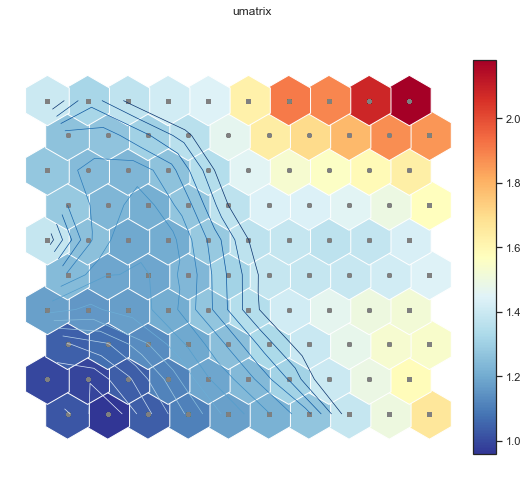

In [ ]:
# Here you have U-matrix
u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=12, show_text=True)

UMAT = u.show(
    sm, 
    distance=10, 
    row_normalized=False,
    show_data=True, 
    contour=True, # Visualize isomorphic curves
    blob=False
)

np.flip(UMAT[1], axis=1); # U-matrix values - they match with the plot colors

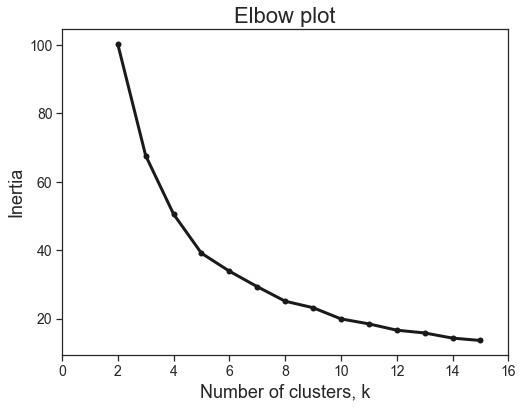

In [ ]:
# SOM + KMeans
plot_elbow(sm.codebook.matrix, 15, "kmeans")

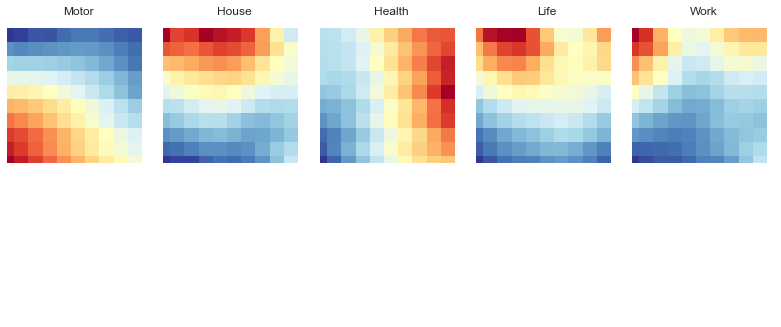

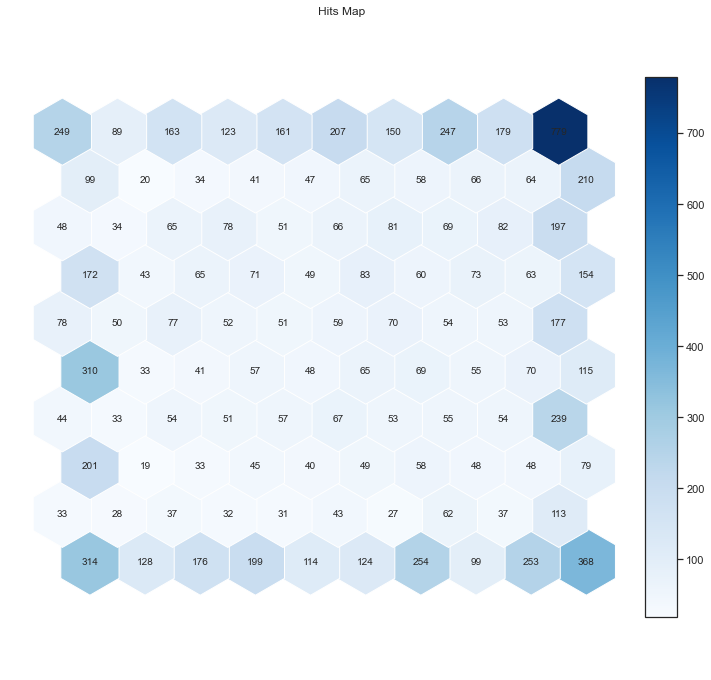

In [ ]:
# SOM results
final_clusters = pd.DataFrame(sm._data, columns = raw_features)
my_labels = pd.Series(sm._bmu[0], name = "Label")
final_clusters = pd.concat([final_clusters, my_labels], axis = 1)

# visualization 1
view2D  = View2DPacked(10, 10, "", text_size = 7)
view2D.show(sm, col_sz = 5, what = 'codebook',) #which_dim="all", denormalize=True)
plt.show()

# visualization 2
vhts  = BmuHitsView(12,12,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=10, cmap="Blues", logaritmic=False)

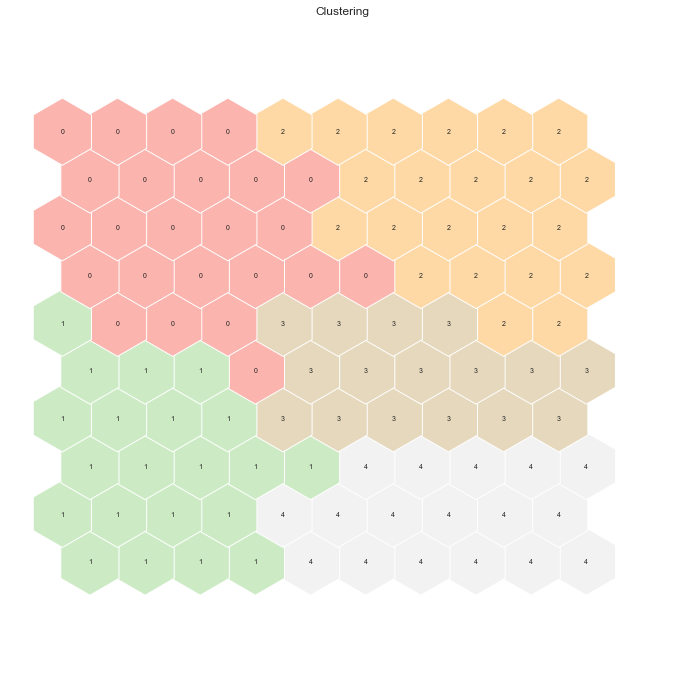

In [ ]:
kmeans = KMeans(n_clusters = 5, random_state = 15)
km_product_labels = kmeans.fit_predict(sm.codebook.matrix)
sm.cluster_labels = km_product_labels

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate = True, onlyzeros = False, labelsize = 7, cmap = "Pastel1")

plt.show()

In [ ]:
# final SOM + KMeans clusters
km_final_clusters = KMeans(5).fit(sm._data)
km_final_labels = km_final_clusters.labels_

df["Label"] = km_final_labels
evaluate_clustering(som_product_standard, df.Label)
summarise_clustering(df_product[raw_features], df.Label, "Motor")

Silhouette score: 0.23
Davies-Bouldin score: 1.41
Calinski-Harabasz score: 4447.91
Cluster sizes:
           obs     %
Cluster            
0        2453  24.4
1        2002  19.9
2        1788  17.8
3        1446  14.4
4        2349  23.4


Motor       House      Health        Life        Work
Cluster                                                            
3        105.435235  536.195228  160.461722  109.602248  107.116618
1        185.004670  208.534041  273.430799   44.654695   43.894775
2        278.545157  269.537444  154.915604   52.374038   49.859508
0        352.616351   97.289258  177.808496   18.980330   19.251488
4        478.033840   39.741592   83.611396    8.255385    8.451090

In [ ]:
r2_variables(df[["Motor", "House", "Health", "Life", "Work", "Label"]], 'Label').drop("Label")

Motor     0.870021
House     0.530256
Health    0.713979
Life      0.512417
Work      0.511758
dtype: float64

In [ ]:
product_labels = km_final_labels

#### Joining clusters (Hierarchical)

In [ ]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()


def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars


def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [ ]:
print("Sociodemographic labels:", Counter(sociodem_labels))
print("Value labels:", Counter(value_labels))
print("Product labels:", Counter(product_labels))

In [ ]:
df_ = pd.concat(
    [
    kp_sociodem_minmax.rename(columns = {"Label": "sociodem"}), 
    som_value_standard.rename(columns = {"Label": "value"}),
    km_product_standard.rename(columns = {"Label": "product"})
    ], axis = 1
)

In [ ]:
# merging with hierarchical
df_ = pd.concat(
    [
    kp_sociodem_minmax.rename(columns = {"Label": "sociodem"}), 
    som_value_standard.rename(columns = {"Label": "value"}),
    km_product_standard.rename(columns = {"Label": "product"})
    ], axis = 1
)

df_centroids = df_.groupby(["sociodem", "value", "product"]).mean()

hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 1.5
hierarchy.dendrogram(
    linkage_matrix, 
    truncate_mode='level', 
    labels=df_centroids.index, 
    p=5, 
    color_threshold=y_threshold, 
    above_threshold_color='k'
)
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage = 'ward', 
    affinity = 'euclidean', 
    n_clusters = 3
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_final = df_.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_final['merged_labels'] = df_final.apply(
    lambda row: cluster_mapper[
        (row['sociodem'], row['value'], row["product"])
    ], axis=1
)

# Merged cluster centroids
cluster_profiles(
    df = df_final[["Age", "EducDeg", "Motor", "House", "Health", "Life", "Work", "CMV", "PremTotal", "sociodem", "value", "product"]], 
    label_columns = ['sociodem', 'value', 'product'], 
    figsize = (28, 13), 
    compar_titles = ["Sociodem clustering", "Value clustering", "Product clusters", "merged_labels"]
)

# umap of hierarchical
import umap

reducer = umap.UMAP(metric = 'euclidean')
cluster_data = df_final[["Age", "Motor", "House", "Health", "Life", "Work", "CMV", "PremTotal"]].values
# scaled_cluster_data = MinMaxScaler().fit_transform(cluster_data)
embedding = reducer.fit_transform(cluster_data)

plt.subplots(figsize = (10, 10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in df_final.merged_labels])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)

In [ ]:
feats = ["Age", "EducDeg", "Children", "CMV", "ClaimsRate", "Motor", "House", "Health", "Life", "Work", "PremTotal"]

df["Label"] = df_final["merged_labels"]
df.groupby("Label")[feats].mean().sort_values("Age")

In [ ]:
two_dim = TSNE(random_state=15).fit_transform(df_final[["Age", "Motor", "House", "Health", "Life", "Work", "CMV", "PremTotal"]])
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['Label'], colormap='tab10', figsize=(15,10))
plt.show()

In [ ]:
# r2 variables used
r2_variables(df_final[["Age", "EducDeg", "Children", "Motor", "House", "Health", "Life", "Work", "CMV", "PremTotal", "merged_labels"]], 'merged_labels').drop('merged_labels')

In [ ]:
# classifying outliers
X = df.drop(columns = "Label")
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)

# Fitting the decision tree
# max_depth of 3 was based on feature importance after building full tree
# print(pd.Series(dt.feature_importances_, index = X_train.columns).sort_values(ascending = False))
dt = DecisionTreeClassifier(random_state = 15, max_depth = 3).fit(X_train, y_train)

print("Predicting {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

In [ ]:
# removing row where FirstPolAge = 51836 as that is impossible
df_outliers = df_outliers[~(df_outliers.FirstPolAge == 51836)]

# predicting the labels of the remaining outliers
df_outliers["Label"] = dt.predict(df_outliers)

# visualising classification tree
dot_data = export_graphviz(
    dt, out_file=None, 
    feature_names=X.columns.to_list(),
    filled=True,
    rounded=True,
    special_characters=True
)  
graphviz.Source(dot_data)

In [ ]:
final_cluster_solution = pd.concat([df, df_outliers])
final_cluster_solution.describe().T

#### Joining clusters (Classification Tree)

In [ ]:
# create a dataframe with the labels obtained from sociodemographic, value, and product clustering
df_clusters = df.copy().drop(columns = "Label")
df_clusters["Sociodem"] = sociodem_labels
df_clusters["Value"] = value_labels
df_clusters["Product"] = product_labels

# combine the clusters into a single label
df_clusters["Composite"] = df_clusters["Sociodem"].astype("str") + df_clusters["Value"].astype("str") + df_clusters["Product"].astype("str")
df_clusters.groupby("Composite").size().sort_values(ascending = False)

df_clusters.head()

Generation   Age  YearSal  EducDeg  Children  FirstPolAge  CustYears  \
CustID                                                                         
1              4.0  34.0  26124.0      2.0       1.0          3.0       31.0   
2              4.0  35.0   8124.0      2.0       1.0         14.0       21.0   
3              3.0  46.0  27324.0      1.0       0.0         21.0       25.0   
4              4.0  35.0  13188.0      3.0       1.0          9.0       26.0   
5              3.0  43.0  21156.0      3.0       1.0         13.0       30.0   

           CMV  ClaimsRate   Motor  ...    Life  LifeRatio    Work  WorkRatio  \
CustID                              ...                                         
1       380.97        0.39  375.85  ...   47.01   0.070632   16.89   0.025377   
2      -131.13        1.12   77.46  ...  194.48   0.213489  106.13   0.116503   
3       504.67        0.28  206.15  ...   86.35   0.116595   99.02   0.133702   
4       -16.99        0.99  182.48  ...   35.34   0.058833   28.34   0.047180   
5        35.23        0.90  338.62  ...   18.78   0.029846   41.45   0.065873   

        PremTotal  EffortRatio  Sociodem  Value  Product  Composite  
CustID                                                               
1          665.56     0.025477         3      3        0        330  
2          910.96     0.112132         3      0        3        303  
3          740.60     0.027104         1      1        3        113  
4          600.68     0.045547         0      3        1        031  
5          629.24     0.029743         0      3        0        030  

[5 rows x 25 columns]

In [ ]:
label_names = list(df_clusters.groupby("Composite").size().index)
label_sizes = list(df_clusters.groupby("Composite").size())
size_dict = {}

# create a dictionary with name and size of each clusters
for name, size in zip(label_names, label_sizes):
    size_dict[name] = size

# create a column with the size of the cluster each observation belongs to
df_clusters["Size"] = df_clusters.Composite.apply(lambda x: size_dict.get(x))

print(f"Number of unique clusters: {len(df_clusters.Composite.unique())}")
df_clusters.groupby("Composite").mean().sort_values("Size", ascending = False).head(30)

Number of unique clusters: 105


Generation        Age       YearSal   EducDeg  Children  \
Composite                                                            
014          2.510417  51.388021  32248.514247  3.154948  1.000000   
221          1.357013  72.207650  45540.970796  2.540984  0.007286   
030          3.375000  36.843750  22692.424992  3.031250  0.976103   
034          3.100746  42.154851  25743.184400  3.055970  0.985075   
220          1.385106  71.512766  45529.638838  2.989362  0.063830   
010          2.330247  54.030864  33895.741456  3.104938  0.990741   
103          3.742857  30.139683  11474.742857  1.000000  0.717460   
314          2.543689  51.148867  32071.706763  2.103560  0.964401   
330          3.193916  39.247148  24082.331135  2.167300  0.992395   
351          3.656388  32.991189  17197.533040  2.008811  0.911894   
051          3.671233  32.808219  16716.821918  3.000000  0.899543   
303          3.747619  31.233333  12982.514286  2.000000  0.742857   
241          1.546341  69.907317  43989.482927  2.331707  0.000000   
242          1.642157  67.666667  43316.882353  2.299020  0.034314   
353          3.625616  32.763547  17896.965517  2.000000  0.798030   
334          3.045455  43.247475  27001.515152  2.272727  0.959596   
243          1.628272  68.560209  43828.182611  1.926702  0.020942   
031          3.627027  34.081081  21137.002266  3.010811  0.972973   
310          2.463687  51.670391  32896.874651  2.000000  0.910615   
222          1.460674  70.904494  45051.303371  2.443820  0.050562   
331          3.517241  35.413793  21354.783091  2.080460  0.908046   
352          3.410405  36.202312  19885.387283  2.011561  0.890173   
153          3.638037  32.036810  16250.057877  1.018405  0.815951   
052          3.496855  35.534591  19377.180911  3.000000  0.861635   
210          1.953947  63.236842  40019.052632  3.039474  0.013158   
342          2.028169  58.992958  36560.619718  2.000000  0.908451   
224          1.471014  70.137681  44980.869565  3.101449  0.210145   
312          2.255639  55.421053  34357.714286  2.000000  0.879699   
020          1.895161  63.217742  38663.322581  3.120968  1.000000   
024          1.887097  62.887097  38539.064516  3.169355  1.000000   

           FirstPolAge  CustYears         CMV  ClaimsRate       Motor  ...  \
Composite                                                              ...   
014          23.117188  28.270833  214.260299    0.607526  492.253867  ...   
221          44.211293  27.996357  138.395628    0.770510  198.480146  ...   
030           6.950368  29.893382  180.785533    0.682868  355.522004  ...   
034           8.589552  33.565299  211.789011    0.615522  478.906306  ...   
220          43.755319  27.757447  183.641574    0.685723  342.309213  ...   
010          24.021605  30.009259  194.422130    0.668056  365.605957  ...   
103          10.422222  19.717460  383.728730    0.662286   60.044444  ...   
314          23.032362  28.116505  214.472071    0.615922  475.459644  ...   
330           8.266160  30.980989  163.103574    0.717529  349.994221  ...   
351           6.872247  26.118943  216.269075    0.714890  160.058150  ...   
051           6.817352  25.990868  205.062237    0.718128  179.549817  ...   
303           9.338095  21.895238  356.779333    0.680095   89.939286  ...   
241          39.185366  30.721951  239.621756    0.714244  160.485561  ...   
242          37.632353  30.034314  314.358725    0.637010  255.951863  ...   
353           8.379310  24.384236  193.971232    0.757833  114.848768  ...   
334           9.409091  33.838384  214.001061    0.620253  466.864091  ...   
243          39.350785  29.209424  329.769005    0.655183  131.443089  ...   
031           6.372973  27.708108  131.427676    0.765622  209.203351  ...   
310          22.787709  28.882682  180.452682    0.686983  364.804413  ...   
222          43.443820  27.460674  188.620281    0.706798  269.344213  ...   
331           7.436782  27.977011  111.310115    0.799

In [ ]:
# separate the rows to be relabelled from the labelled rows
orphan_obs_df = df_clusters[df_clusters["Size"] < 300].drop(columns = "Size")
labelled_obs_df = df_clusters[~(df_clusters["Size"] < 300)].drop(columns = "Size")

# use the same features used to obtain the clusters
training_features = [
    "YearSal",
    "EducDeg",
    "Children",
    # "CMV",
    "PremTotal",
    "FirstPolAge",
    # "CustYears",
    "EffortRatio",
    "Motor",
    "House",
    "Health",
    "Life",
    "Work"
]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# independent, X, and dependent, y, variables
X = labelled_obs_df[training_features]
y = labelled_obs_df.Composite

# split train and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 15)

clf = RandomForestClassifier(
    random_state = 15,
    max_depth = 8,
    criterion = "gini"
).fit(X_train, y_train)

y_pred = clf.predict(X_val)

# evaluate predictions
accuracy = round(metrics.accuracy_score(y_val, y_pred)*100, 2)
print(f"Classification Tree Accuracy: {accuracy} %")

Classification Tree Accuracy: 95.63 %


In [ ]:
# classify orphan observations
X_test = orphan_obs_df[training_features]
y_pred = clf.predict(X_test)

orphan_obs_df["Composite"] = y_pred

final_final = pd.concat([labelled_obs_df, orphan_obs_df])
final_cluster_sizes=final_final.groupby("Composite").size().rename("Size")

#calculates the size of each cluster
final_final_grouped=final_final.groupby("Composite").mean().merge(final_cluster_sizes,left_index=True,right_index=True)
#calculates the value of each cluster
final_final_grouped["ClusterValue"]=final_final_grouped["CMV"]*final_final_grouped["Size"]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(final_final_grouped[["YearSal", "EducDeg", "Children", "CMV", "PremTotal", "FirstPolAge", "CustYears", "EffortRatio", "Motor", "House", "Health", "Life", "Work", "Size", "ClusterValue"]].sort_values("YearSal"))

YearSal   EducDeg  Children         CMV   PremTotal  \
Composite                                                             
103        18544.270075  1.771368  0.771368  297.704872  998.813136   
030        21105.208131  2.655505  0.942202  178.311638  691.466573   
034        25034.024021  3.075606  0.941512  208.797175  618.075378   
314        31974.228028  1.906815  0.920723  205.261182  644.544270   
014        33605.975041  3.165339  0.932271  214.823247  614.491554   
010        34869.358142  2.744637  0.861083  203.942513  702.644648   
220        43402.343533  2.791373  0.291373  198.713504  689.062430   
221        43847.514144  2.311679  0.126469  196.435902  794.390898   

           FirstPolAge  CustYears  EffortRatio       Motor       House  \
Composite                                                                
103          11.307158  24.606838     0.069144  138.001902  510.939770   
030           7.154587  28.928899     0.035867  286.690156  129.067385   
034           8.436519  33.242511     0.026242  475.442539   39.753138   
314          21.022253  29.798331     0.020808  443.362406   72.149861   
014          25.708167  27.941235     0.018924  487.355548   34.256175   
010          24.417773  31.023493     0.020678  325.985301  141.713023   
220          41.068662  27.436620     0.016177  347.199868  126.057350   
221          40.597097  28.747063     0.018410  186.935950  257.663925   

               Health       Life       Work  Size  ClusterValue  
Composite                                                        
103        175.990684  87.138734  86.742046  1872     557303.52  
030        206.144179  35.689523  33.875330  2180     388719.37  
034         87.535949   7.714593   7.629158   701     146366.82  
314         91.745730  18.567107  18.719166   719     147582.79  
014         77.976574   7.385807   7.517450  1004     215682.54  
010        170.936650  32.192768  31.816905   979     199659.72  
220        166.320097  25.090044  24.395070  1136     225738.54  
221        240.663981  55.535639  53.591403  1447     284242.75

In [ ]:
# manually merge some clusters
# the micromanagement approach
final_final.loc[final_final.Composite == "030", "Composite"] = "034"
final_final.loc[final_final.Composite == "014", "Composite"] = "010"
final_final.loc[final_final.Composite == "220", "Composite"] = "221"
final_final.loc[final_final.Composite == "314", "Composite"] = "010"


final_final.groupby("Composite")[["Age", "YearSal", "EducDeg", "Children", "CMV", "PremTotal", "FirstPolAge", "EffortRatio", "Motor", "House", "Health", "Life", "Work"]].mean().sort_values("YearSal")

Age       YearSal   EducDeg  Children         CMV  \
Composite                                                            
103        35.913996  18544.270075  1.771368  0.771368  297.704872   
034        37.444984  22061.160904  2.757723  0.942034  185.729327   
010        53.545892  33629.522767  2.678016  0.903405  208.336436   
221        68.975223  43651.728696  2.522648  0.198993  197.437588   

            PremTotal  FirstPolAge  EffortRatio       Motor       House  \
Composite                                                                 
103        998.813136    11.307158     0.069144  138.001902  510.939770   
034        673.609153     7.466505     0.033525  332.617064  107.335595   
010        654.428557    23.993708     0.020061  417.180662   83.273871   
221        748.067576    40.804491     0.017428  257.419810  199.783527   

               Health       Life       Work  
Composite                                    
103        175.990684  87.138734  86.742046  
034        177.284627  28.882711  27.489157  
010        115.322221  19.349304  19.302498  
221        207.967638  42.145707  40.750894

In [ ]:
final_final.groupby("Composite").size()

Composite
010    2702
034    2881
103    1872
221    2583
dtype: int64

In [ ]:
r2_variables(final_final[["YearSal", "EducDeg", "Children", "PremTotal", "FirstPolAge", "EffortRatio", "Motor", "House", "Health", "Life", "Work", "Composite"]], 'Composite').drop("Composite")

Children       0.452413
EducDeg        0.203477
EffortRatio    0.467738
FirstPolAge    0.778860
Health         0.216170
House          0.497651
Life           0.270081
Motor          0.500745
PremTotal      0.489035
Work           0.288452
YearSal        0.683958
dtype: float64

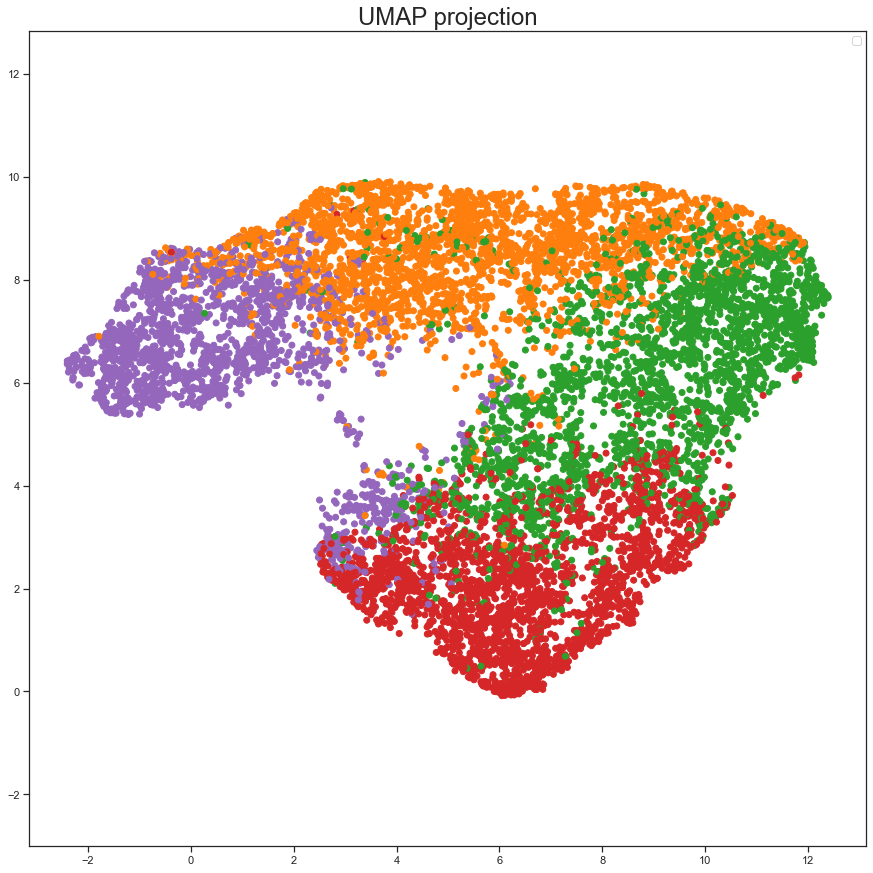

In [ ]:
import umap

# create a color dictionary for UMAP, one color per composite label
color_dic = {}
i = 1
for label in final_final.Composite.unique():
    color_dic[label] = i
    i += 1
    
reducer = umap.UMAP()
cluster_data = final_final[[
    "YearSal", 
    "PremTotal",
    # "EducDeg",
    # "Children",
    # "CMV",
    "FirstPolAge", 
    # "CustYears", 
    "EffortRatio",
    "Motor", 
    "House", 
    "Health", 
    "Life", 
    "Work"
]].values
scaled_cluster_data = StandardScaler().fit_transform(cluster_data)
embedding = reducer.fit_transform(scaled_cluster_data)


plt.subplots(figsize = (15, 15))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = [sns.color_palette("tab10")[color_dic[x]] for x in final_final.Composite]
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection', fontsize=24)
plt.legend().set_visible(True)

In [ ]:
# # the macromanagement approach
# final_final.loc[final_final.Composite == "114", "Composite"] = "214"
# final_final.loc[final_final.Composite == "114", "Composite"] = "214"
# final_final.loc[final_final.Composite == "203", "Composite"] = "253"
# final_final.loc[final_final.Composite == "130", "Composite"] = "253"

# final_final.groupby("Composite")[["YearSal", "EducDeg", "Children", "CMV", "PremTotal", "FirstPolAge", "EffortRatio", "Motor", "House", "Health", "Life", "Work"]].mean().sort_values("YearSal")

YearSal   EducDeg  Children         CMV   PremTotal  \
Composite                                                             
103        18544.270075  1.771368  0.771368  297.704872  998.813136   
030        21105.208131  2.655505  0.942202  178.311638  691.466573   
034        25034.024021  3.075606  0.941512  208.797175  618.075378   
314        31974.228028  1.906815  0.920723  205.261182  644.544270   
014        33605.975041  3.165339  0.932271  214.823247  614.491554   
010        34869.358142  2.744637  0.861083  203.942513  702.644648   
220        43402.343533  2.791373  0.291373  198.713504  689.062430   
221        43847.514144  2.311679  0.126469  196.435902  794.390898   

           FirstPolAge  EffortRatio       Motor       House      Health  \
Composite                                                                 
103          11.307158     0.069144  138.001902  510.939770  175.990684   
030           7.154587     0.035867  286.690156  129.067385  206.144179   
034           8.436519     0.026242  475.442539   39.753138   87.535949   
314          21.022253     0.020808  443.362406   72.149861   91.745730   
014          25.708167     0.018924  487.355548   34.256175   77.976574   
010          24.417773     0.020678  325.985301  141.713023  170.936650   
220          41.068662     0.016177  347.199868  126.057350  166.320097   
221          40.597097     0.018410  186.935950  257.663925  240.663981   

                Life       Work  
Composite                        
103        87.138734  86.742046  
030        35.689523  33.875330  
034         7.714593   7.629158  
314        18.567107  18.719166  
014         7.385807   7.517450  
010        32.192768  31.816905  
220        25.090044  24.395070  
221        55.535639  53.591403

In [ ]:
#analysis of cancelled insurances
df_temp=df.copy()
#health and motor are removed as its only one person
for premium in ["Work","Life","House"]:
    df_temp["Canceled"]=df_temp[premium]<0
    print(premium)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df_temp.groupby("Canceled").mean())
print("Any cancelation")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    df_temp["Canceled"]=(df.Health<0) | (df.Life<0) | (df.Work<0) | (df.House<0) | (df.Motor<0)
    display(df_temp.groupby("Canceled").mean())